In [ ]:
!pip install tensorflow
!pip install opencv-python
!pip install pyyaml h5py

In [4]:
import os
import re
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D, InputLayer, Input, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

import random
random.seed(123456)

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
ROOT = "/content/drive/MyDrive/Final Project"

# **Clean CSV Data**

In [ ]:
# Create dataframes
calc_train_df = pd.read_csv(ROOT + '/csv/calc_case_description_train_set.csv')
calc_test_df = pd.read_csv(ROOT + '/csv/calc_case_description_test_set.csv')
mass_train_df = pd.read_csv(ROOT + '/csv/mass_case_description_train_set.csv')
mass_test_df = pd.read_csv(ROOT + '/csv/mass_case_description_test_set.csv')
dicom_df = pd.read_csv(ROOT + '/csv/dicom_info.csv')

In [ ]:
# Ensure column names are uniform
calc_train_df.rename(columns={'breast density': 'breast_density', 'left or right breast': 'left_or_right_breast', 'image view': 'image_view', 'abnormality id': 'abnormality_id', 'abnormality type': 'abnormality_type', 'calc type': 'calc_type', 'calc distribution': 'calc_distribution', 'image file path': 'image_file_path', 'cropped image file path': 'cropped_image_file_path', 'ROI mask file path': 'ROI_mask_file_path'}, inplace=True)
calc_test_df.rename(columns={'breast density': 'breast_density', 'left or right breast': 'left_or_right_breast', 'image view': 'image_view', 'abnormality id': 'abnormality_id', 'abnormality type': 'abnormality_type', 'calc type': 'calc_type', 'calc distribution': 'calc_distribution', 'image file path': 'image_file_path', 'cropped image file path': 'cropped_image_file_path', 'ROI mask file path': 'ROI_mask_file_path'}, inplace=True)
mass_train_df.rename(columns={'left or right breast': 'left_or_right_breast', 'image view': 'image_view', 'abnormality id': 'abnormality_id', 'abnormality type': 'abnormality_type', 'mass_shape': 'mass_shape', 'mass margins': 'mass_margins', 'image file path': 'image_file_path', 'cropped image file path': 'cropped_image_file_path', 'ROI mask file path': 'ROI_mask_file_path'}, inplace=True)
mass_test_df.rename(columns={'left or right breast': 'left_or_right_breast', 'image view': 'image_view', 'abnormality id': 'abnormality_id', 'abnormality type': 'abnormality_type', 'mass shape': 'mass_shape', 'mass margins': 'mass_margins', 'image file path': 'image_file_path', 'cropped image file path': 'cropped_image_file_path', 'ROI mask file path': 'ROI_mask_file_path'}, inplace=True)

In [ ]:
# Only need two distinct labels, not three
calc_train_df['pathology'] = calc_train_df['pathology'].replace('BENIGN_WITHOUT_CALLBACK', 'BENIGN')
calc_test_df['pathology'] = calc_test_df['pathology'].replace('BENIGN_WITHOUT_CALLBACK', 'BENIGN')
mass_train_df['pathology'] = mass_train_df['pathology'].replace('BENIGN_WITHOUT_CALLBACK', 'BENIGN')
mass_test_df['pathology'] = mass_test_df['pathology'].replace('BENIGN_WITHOUT_CALLBACK', 'BENIGN')

In [ ]:
# Remove unnecessary substring from image path in dicom_df
dicom_df['image_path'] = dicom_df['image_path'].replace("CBIS-DDSM/jpeg/", "", regex=True)

In [ ]:
# Drop all rows with missing values in SeriesDescription
dicom_df = dicom_df.dropna(subset=['SeriesDescription'])

In [ ]:
dicom_df['SeriesDescription'].value_counts()

SeriesDescription
cropped images           3567
ROI mask images          3247
full mammogram images    2857
Name: count, dtype: int64

In [ ]:
# Add columns to hold jpeg file paths
calc_train_df['jpeg_image_file_path'] = ''
calc_train_df['jpeg_cropped_image_file_path'] = ''
calc_train_df['jpeg_ROI_mask_file_path'] = ''

calc_test_df['jpeg_image_file_path'] = ''
calc_test_df['jpeg_cropped_image_file_path'] = ''
calc_test_df['jpeg_ROI_mask_file_path'] = ''

mass_train_df['jpeg_image_file_path'] = ''
mass_train_df['jpeg_cropped_image_file_path'] = ''
mass_train_df['jpeg_ROI_mask_file_path'] = ''

mass_test_df['jpeg_image_file_path'] = ''
mass_test_df['jpeg_cropped_image_file_path'] = ''
mass_test_df['jpeg_ROI_mask_file_path'] = ''

# Match PatientID in dicom with correct row in DFs, add jpeg file paths to respective columns
df_dict = {"Calc-Training": calc_train_df, "Calc-Test": calc_test_df, "Mass-Training": mass_train_df, "Mass-Test": mass_test_df}
col_dict = {"full mammogram images": "image_file_path", "cropped images": "cropped_image_file_path", "ROI mask images": "ROI_mask_file_path"}
for ind, val in dicom_df.iterrows():
    df = df_dict[val['PatientID'].split("_")[0]]
    col = col_dict[val['SeriesDescription']]
    jpeg_col = "jpeg_" + col
    df.loc[df[col].str.contains(val['PatientID']), jpeg_col] = val['image_path']

# **Image Preprocessing**

In [ ]:
# Moves all images to calc_imgs and mass_imgs
# Performs augmentation on training images only

source_dir = ROOT + "/jpeg/"
calc_dir = ROOT + "/calc_imgs/"
mass_dir = ROOT + "/mass_imgs/"

sub_dirs = {"calc": calc_dir, "mass": mass_dir}

def sort_imgs(df, calc_or_mass, train_or_test):
  fn_count = 0
  for ind, row in df.iterrows():
    if len(row['jpeg_image_file_path']) > 0:
        full_source = source_dir + row['jpeg_image_file_path']
        full_filename = str(fn_count) + ".jpg"
        modify_and_copy_img(full_source, full_filename, calc_or_mass, train_or_test, row['pathology'].lower())
        fn_count += 1
    if len(row['jpeg_cropped_image_file_path']) > 0:
        cropped_source = source_dir + row['jpeg_cropped_image_file_path']
        cropped_filename = str(fn_count) + ".jpg"
        modify_and_copy_img(cropped_source, cropped_filename, calc_or_mass, train_or_test, row['pathology'].lower())
        fn_count += 1
    if len(row['jpeg_ROI_mask_file_path']) > 0:
        ROI_source = source_dir + row['jpeg_ROI_mask_file_path']
        ROI_filename = str(fn_count) + ".jpg"
        modify_and_copy_img(ROI_source, ROI_filename, calc_or_mass, train_or_test, row['pathology'].lower())
        fn_count += 1

def modify_and_copy_img(source_path, filename, calc_or_mass, train_or_test, pathology):
  pathology_sub_dirs = {"benign": "0", "malignant": "1"}
  grayscale_img=cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)

  # Convert grayscale image to RGB
  if grayscale_img is None:
      print("Error: Could not load image.")
  else:
      rgb_img = cv2.cvtColor(grayscale_img, cv2.COLOR_GRAY2RGB)

  # Resize image to 224x244
  rgb_img = cv2.resize(rgb_img, (224,224))

  new_dir = sub_dirs[calc_or_mass] + train_or_test + "/" + pathology_sub_dirs[pathology]
  os.chdir(new_dir)

  cv2.imwrite(filename, rgb_img)

  if train_or_test == "train":
    # Rotate image by 90, 180, and 270 degrees
    rotate90 = cv2.rotate(rgb_img, cv2.ROTATE_90_CLOCKWISE)
    rotate180 = cv2.rotate(rgb_img, cv2.ROTATE_180)
    rotate270 = cv2.rotate(rgb_img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # Flip image along x- and y-axes, adjust for brightness and contrast
    x_flip = cv2.flip(rgb_img, 0)
    y_flip = cv2.flip(rgb_img, 1)
    bc = cv2.convertScaleAbs(rgb_img, alpha=1.5, beta=30)

    rotate90_filename = "rotate90_" + filename
    rotate180_filename = "rotate180_" + filename
    rotate270_filename = "rotate270_" + filename
    x_flip_filename = "x_flip_" + filename
    y_flip_filename = "y_flip_" + filename
    bc_filename = "bc_" + filename

    cv2.imwrite(rotate90_filename, rotate90)
    cv2.imwrite(rotate180_filename, rotate180)
    cv2.imwrite(rotate270_filename, rotate270)
    cv2.imwrite(x_flip_filename, x_flip)
    cv2.imwrite(y_flip_filename, y_flip)
    cv2.imwrite(bc_filename, bc)

In [ ]:
# Moves only ROI images to calc_imgs2 and mass_imgs2
# Dataframes are merged and custom train/test split is performed.
# Performs augmentation on training images only

source_dir = ROOT + "/jpeg/"
calc_dir = ROOT + "/calc_imgs2/"
mass_dir = ROOT + "/mass_imgs2/"

sub_dirs = {"calc": calc_dir, "mass": mass_dir}

calc_combined = pd.concat([calc_train_df, calc_test_df])
mass_combined = pd.concat([mass_train_df, mass_test_df])

calc_combined.reset_index(drop=True, inplace=True)
mass_combined.reset_index(drop=True, inplace=True)

def sort_imgs2(df, calc_or_mass):
  fn_count = 0
  test_size = 0

  temp_df = df.loc[df['jpeg_ROI_mask_file_path'].str.len() > 0]
  test_size = int(len(temp_df) * .3)
  test_samples = random.sample(range(temp_df.shape[0]), test_size)

  i = 0
  while i < len(temp_df):
    for ind, row in temp_df.iterrows():
      if len(row['jpeg_ROI_mask_file_path']) > 0:
        i += 1
        ROI_source = source_dir + row['jpeg_ROI_mask_file_path']
        ROI_filename = str(fn_count) + ".jpg"
        if i in test_samples:
          modify_and_copy_img2(ROI_source, ROI_filename, calc_or_mass, "test", row['pathology'].lower())
          fn_count += 1
          # i = 0
        else:
          modify_and_copy_img2(ROI_source, ROI_filename, calc_or_mass, "train", row['pathology'].lower())
          fn_count += 1

def modify_and_copy_img2(source_path, filename, calc_or_mass, train_or_test, pathology):
  train_sub_dirs = {"benign": "0", "malignant": "1"}
  grayscale_img=cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)

  # Convert grayscale image to RGB
  if grayscale_img is None:
      print("Error: Could not load image.")
  else:
      rgb_img = cv2.cvtColor(grayscale_img, cv2.COLOR_GRAY2RGB)

  # Resize image to 224x244
  rgb_img = cv2.resize(rgb_img, (224,224))

  if train_or_test == "train":
    new_dir = sub_dirs[calc_or_mass] + train_or_test + "/" + train_sub_dirs[pathology]
    os.chdir(new_dir)
    cv2.imwrite(filename, rgb_img)

    rotate90 = cv2.rotate(rgb_img, cv2.ROTATE_90_CLOCKWISE)
    rotate180 = cv2.rotate(rgb_img, cv2.ROTATE_180)
    rotate270 = cv2.rotate(rgb_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    x_flip = cv2.flip(rgb_img, 0)
    y_flip = cv2.flip(rgb_img, 1)
    bc = cv2.convertScaleAbs(rgb_img, alpha=1.5, beta=30)

    rotate90_filename = "rotate90_" + filename
    rotate180_filename = "rotate180_" + filename
    rotate270_filename = "rotate270_" + filename
    x_flip_filename = "x_flip_" + filename
    y_flip_filename = "y_flip_" + filename
    bc_filename = "bc_" + filename

    cv2.imwrite(rotate90_filename, rotate90)
    cv2.imwrite(rotate180_filename, rotate180)
    cv2.imwrite(rotate270_filename, rotate270)
    cv2.imwrite(x_flip_filename, x_flip)
    cv2.imwrite(y_flip_filename, y_flip)
    cv2.imwrite(bc_filename, bc)
  else:
    new_dir = sub_dirs[calc_or_mass] + train_or_test + "/" + train_sub_dirs[pathology]
    os.chdir(new_dir)
    cv2.imwrite(filename, rgb_img)

In [ ]:
# Moves only cropped and ROI images to calc_imgs3 and mass_imgs3 train directories
# Moves all images - full mammogram, cropped, and ROI - to respective test directories
# Performs rotations on training images only

source_dir = ROOT + "/jpeg/"
calc_dir = ROOT + "/calc_imgs3/"
mass_dir = ROOT + "/mass_imgs3/"

sub_dirs = {"calc": calc_dir, "mass": mass_dir}

def sort_imgs3(df, calc_or_mass, train_or_test):
  train_sub_dirs = {"benign": "0", "malignant": "1"}
  fn_count = 0
  for ind, row in df.iterrows():
    if train_or_test == "train":
        if len(row['jpeg_cropped_image_file_path']) > 0:
            cropped_source = source_dir + row['jpeg_cropped_image_file_path']
            cropped_filename = str(fn_count) + ".jpg"
            modify_and_copy_img3(cropped_source, cropped_filename, calc_or_mass, train_or_test, row['pathology'].lower())
            fn_count += 1
        if len(row['jpeg_ROI_mask_file_path']) > 0:
            ROI_source = source_dir + row['jpeg_ROI_mask_file_path']
            ROI_filename = str(fn_count) + ".jpg"
            modify_and_copy_img3(ROI_source, ROI_filename, calc_or_mass, train_or_test, row['pathology'].lower())
            fn_count += 1
    else:
      if len(row['jpeg_image_file_path']) > 0:
            image_source = source_dir + row['jpeg_image_file_path']
            image_filename = str(fn_count) + ".jpg"
            modify_and_copy_img3(image_source, image_filename, calc_or_mass, train_or_test, row['pathology'].lower())
            fn_count += 1
      if len(row['jpeg_cropped_image_file_path']) > 0:
            cropped_source = source_dir + row['jpeg_cropped_image_file_path']
            cropped_filename = str(fn_count) + ".jpg"
            modify_and_copy_img3(cropped_source, cropped_filename, calc_or_mass, train_or_test, row['pathology'].lower())
            fn_count += 1
      if len(row['jpeg_ROI_mask_file_path']) > 0:
            ROI_source = source_dir + row['jpeg_ROI_mask_file_path']
            ROI_filename = str(fn_count) + ".jpg"
            modify_and_copy_img3(ROI_source, ROI_filename, calc_or_mass, train_or_test, row['pathology'].lower())
            fn_count += 1

def modify_and_copy_img3(source_path, filename, calc_or_mass, train_or_test, pathology):
  train_sub_dirs = {"benign": "0", "malignant": "1"}
  grayscale_img=cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)

  # Convert grayscale image to RGB
  if grayscale_img is None:
      print("Error: Could not load image.")
  else:
      rgb_img = cv2.cvtColor(grayscale_img, cv2.COLOR_GRAY2RGB)

  # Resize image to 224x244
  rgb_img = cv2.resize(rgb_img, (224,224))
  if train_or_test == "train":
    new_dir = sub_dirs[calc_or_mass] + train_or_test + "/" + train_sub_dirs[pathology]
    os.chdir(new_dir)
    cv2.imwrite(filename, rgb_img)

    # Rotate image by 90, 180, and 270 degrees
    rotate90 = cv2.rotate(rgb_img, cv2.ROTATE_90_CLOCKWISE)
    rotate180 = cv2.rotate(rgb_img, cv2.ROTATE_180)
    rotate270 = cv2.rotate(rgb_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    x_flip = cv2.flip(rgb_img, 0)
    y_flip = cv2.flip(rgb_img, 1)
    bc = cv2.convertScaleAbs(rgb_img, alpha=1.5, beta=30)

    rotate90_filename = "rotate90_" + filename
    rotate180_filename = "rotate180_" + filename
    rotate270_filename = "rotate270_" + filename
    x_flip_filename = "x_flip_" + filename
    y_flip_filename = "y_flip_" + filename
    bc_filename = "bc_" + filename

    cv2.imwrite(rotate90_filename, rotate90)
    cv2.imwrite(rotate180_filename, rotate180)
    cv2.imwrite(rotate270_filename, rotate270)
    cv2.imwrite(x_flip_filename, x_flip)
    cv2.imwrite(y_flip_filename, y_flip)
    cv2.imwrite(bc_filename, bc)

  else:
    new_dir = sub_dirs[calc_or_mass] + train_or_test + "/" + train_sub_dirs[pathology]
    os.chdir(new_dir)
    cv2.imwrite(filename, rgb_img)

In [ ]:
# Moves only ROI images to "calc_imgs4" and "mass_imgs4" train and test directories
# Train/test split of 10% for calcification only
# Performs augmentation on training images only

source_dir = ROOT + "/jpeg/"
calc_dir = ROOT + "/calc_imgs4/"
mass_dir = ROOT + "/mass_imgs4/"

sub_dirs = {"calc": calc_dir, "mass": mass_dir}

def sort_imgs4(df, calc_or_mass, train_or_test):
  train_sub_dirs = {"benign": "0", "malignant": "1"}
  fn_count = 0
  test_size = 0

  if calc_or_mass == "calc" and train_or_test == "train":
    temp_df = df.loc[df['jpeg_ROI_mask_file_path'].str.len() > 0]
    test_size = int(len(temp_df) * .1)
    test_samples = random.sample(range(temp_df.shape[0]), test_size)

  i = 0
  if calc_or_mass == "calc" and train_or_test == "train":
    for ind, row in temp_df.iterrows():
      if len(row['jpeg_ROI_mask_file_path']) > 0:
        i += 1
        ROI_source = source_dir + row['jpeg_ROI_mask_file_path']
        ROI_filename = str(fn_count) + ".jpg"
        if i in test_samples:
          modify_and_copy_img4(ROI_source, ROI_filename, calc_or_mass, "test", row['pathology'].lower())
          fn_count += 1
          i = 0
        else:
          modify_and_copy_img4(ROI_source, ROI_filename, calc_or_mass, train_or_test, row['pathology'].lower())
          fn_count += 1
  else:
    for ind, row in df.iterrows():
      if len(row['jpeg_ROI_mask_file_path']) > 0:
        ROI_source = source_dir + row['jpeg_ROI_mask_file_path']
        ROI_filename = str(fn_count) + ".jpg"
        modify_and_copy_img4(ROI_source, ROI_filename, calc_or_mass, train_or_test, row['pathology'].lower())
        fn_count += 1

def modify_and_copy_img4(source_path, filename, calc_or_mass, train_or_test, pathology):
  train_sub_dirs = {"benign": "0", "malignant": "1"}
  grayscale_img=cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)

  # Convert grayscale image to RGB
  if grayscale_img is None:
      print("Error: Could not load image.")
  else:
      rgb_img = cv2.cvtColor(grayscale_img, cv2.COLOR_GRAY2RGB)

  # Resize image to 224x244
  rgb_img = cv2.resize(rgb_img, (224,224))
  if train_or_test == "train":
    new_dir = sub_dirs[calc_or_mass] + train_or_test + "/" + train_sub_dirs[pathology]
    os.chdir(new_dir)
    cv2.imwrite(filename, rgb_img)

    rotate90 = cv2.rotate(rgb_img, cv2.ROTATE_90_CLOCKWISE)
    rotate180 = cv2.rotate(rgb_img, cv2.ROTATE_180)
    rotate270 = cv2.rotate(rgb_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    x_flip = cv2.flip(rgb_img, 0)
    y_flip = cv2.flip(rgb_img, 1)
    bc = cv2.convertScaleAbs(rgb_img, alpha=1.5, beta=30)

    rotate90_filename = "rotate90_" + filename
    rotate180_filename = "rotate180_" + filename
    rotate270_filename = "rotate270_" + filename
    x_flip_filename = "x_flip_" + filename
    y_flip_filename = "y_flip_" + filename
    bc_filename = "bc_" + filename

    cv2.imwrite(rotate90_filename, rotate90)
    cv2.imwrite(rotate180_filename, rotate180)
    cv2.imwrite(rotate270_filename, rotate270)
    cv2.imwrite(x_flip_filename, x_flip)
    cv2.imwrite(y_flip_filename, y_flip)
    cv2.imwrite(bc_filename, bc)
  else:
    new_dir = sub_dirs[calc_or_mass] + train_or_test + "/" + train_sub_dirs[pathology]
    os.chdir(new_dir)
    cv2.imwrite(filename, rgb_img)

In [ ]:
# Moves only cropped images to "calc_imgs5" and "mass_imgs5" train and test directories
# Performs augmentation on training images only

source_dir = ROOT + "/jpeg/"
calc_dir = ROOT + "/calc_imgs5/"
mass_dir = ROOT + "/mass_imgs5/"

sub_dirs = {"calc": calc_dir, "mass": mass_dir}

def sort_imgs5(df, calc_or_mass, train_or_test):
  train_sub_dirs = {"benign": "0", "malignant": "1"}
  fn_count = 0
  for ind, row in df.iterrows():
    if len(row['jpeg_cropped_image_file_path']) > 0:
      cropped_source = source_dir + row['jpeg_cropped_image_file_path']
      cropped_filename = str(fn_count) + ".jpg"
      modify_and_copy_img5(cropped_source, cropped_filename, calc_or_mass, train_or_test, row['pathology'].lower())
      fn_count += 1

def modify_and_copy_img5(source_path, filename, calc_or_mass, train_or_test, pathology):
  train_sub_dirs = {"benign": "0", "malignant": "1"}
  grayscale_img=cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)

  # Convert grayscale image to RGB
  if grayscale_img is None:
      print("Error: Could not load image.")
  else:
      rgb_img = cv2.cvtColor(grayscale_img, cv2.COLOR_GRAY2RGB)

  # Resize image to 224x244
  rgb_img = cv2.resize(rgb_img, (224,224))
  if train_or_test == "train":
    new_dir = sub_dirs[calc_or_mass] + train_or_test + "/" + train_sub_dirs[pathology]
    os.chdir(new_dir)
    cv2.imwrite(filename, rgb_img)

    rotate90 = cv2.rotate(rgb_img, cv2.ROTATE_90_CLOCKWISE)
    rotate180 = cv2.rotate(rgb_img, cv2.ROTATE_180)
    rotate270 = cv2.rotate(rgb_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    x_flip = cv2.flip(rgb_img, 0)
    y_flip = cv2.flip(rgb_img, 1)
    bc = cv2.convertScaleAbs(rgb_img, alpha=1.5, beta=30)

    rotate90_filename = "rotate90_" + filename
    rotate180_filename = "rotate180_" + filename
    rotate270_filename = "rotate270_" + filename
    x_flip_filename = "x_flip_" + filename
    y_flip_filename = "y_flip_" + filename
    bc_filename = "bc_" + filename

    cv2.imwrite(rotate90_filename, rotate90)
    cv2.imwrite(rotate180_filename, rotate180)
    cv2.imwrite(rotate270_filename, rotate270)
    cv2.imwrite(x_flip_filename, x_flip)
    cv2.imwrite(y_flip_filename, y_flip)
    cv2.imwrite(bc_filename, bc)
  else:
    new_dir = sub_dirs[calc_or_mass] + train_or_test + "/" + train_sub_dirs[pathology]
    os.chdir(new_dir)
    cv2.imwrite(filename, rgb_img)

In [ ]:
# Moves only cropped and ROI images to "calc_imgs6" and "mass_imgs6"
# Dataframes are merged and train/test split of 30% is performed.
# Performs augmentation on training images only

source_dir = ROOT + "/jpeg/"
calc_dir = ROOT + "/calc_imgs6/"
mass_dir = ROOT + "/mass_imgs6/"

sub_dirs = {"calc": calc_dir, "mass": mass_dir}

calc_combined = pd.concat([calc_train_df, calc_test_df])
mass_combined = pd.concat([mass_train_df, mass_test_df])

calc_combined.reset_index(drop=True, inplace=True)
mass_combined.reset_index(drop=True, inplace=True)

calc_combined['jpeg_cropped_image_file_path'] = calc_combined['jpeg_cropped_image_file_path'].str.replace('\n', '')
calc_combined['jpeg_ROI_mask_file_path'] = calc_combined['jpeg_ROI_mask_file_path'].str.replace('\n', '')
mass_combined['jpeg_cropped_image_file_path'] = mass_combined['jpeg_cropped_image_file_path'].str.replace('\n', '')
mass_combined['jpeg_ROI_mask_file_path'] = mass_combined['jpeg_ROI_mask_file_path'].str.replace('\n', '')

def sort_imgs6(df, calc_or_mass):
  fn_count = 0
  test_size = 0

  temp1 = df.loc[df['jpeg_cropped_image_file_path'].str.len() > 0]
  temp2 = df.loc[df['jpeg_ROI_mask_file_path'].str.len() > 0]
  temp_df = pd.concat([temp1, temp2])
  test_size = int(len(temp_df) * .3)
  test_samples = random.sample(range(temp_df.shape[0]), test_size)

  i = 0
  while i < len(temp_df):
    for ind, row in temp_df.iterrows():
      if len(row['jpeg_ROI_mask_file_path']) > 0:
        i += 1
        ROI_source = source_dir + row['jpeg_ROI_mask_file_path']
        ROI_filename = str(fn_count) + ".jpg"
        if i in test_samples:
          modify_and_copy_img6(ROI_source, ROI_filename, calc_or_mass, "test", row['pathology'].lower())
          fn_count += 1
          # i = 0
        else:
          modify_and_copy_img6(ROI_source, ROI_filename, calc_or_mass, "train", row['pathology'].lower())
          fn_count += 1
      if len(row['jpeg_cropped_image_file_path']) > 0:
        i += 1
        ROI_source = source_dir + row['jpeg_cropped_image_file_path']
        ROI_filename = str(fn_count) + ".jpg"
        if i in test_samples:
          modify_and_copy_img6(ROI_source, ROI_filename, calc_or_mass, "test", row['pathology'].lower())
          fn_count += 1
          # i = 0
        else:
          modify_and_copy_img6(ROI_source, ROI_filename, calc_or_mass, "train", row['pathology'].lower())
          fn_count += 1

def modify_and_copy_img6(source_path, filename, calc_or_mass, train_or_test, pathology):
  train_sub_dirs = {"benign": "0", "malignant": "1"}
  grayscale_img=cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)

  # Convert grayscale image to RGB
  if grayscale_img is None:
      print("Error: Could not load image.", source_path)
  else:
      rgb_img = cv2.cvtColor(grayscale_img, cv2.COLOR_GRAY2RGB)

  # Resize image to 224x244
  rgb_img = cv2.resize(rgb_img, (224,224))

  if train_or_test == "train":
    new_dir = sub_dirs[calc_or_mass] + train_or_test + "/" + train_sub_dirs[pathology]
    os.chdir(new_dir)
    cv2.imwrite(filename, rgb_img)

    rotate90 = cv2.rotate(rgb_img, cv2.ROTATE_90_CLOCKWISE)
    rotate180 = cv2.rotate(rgb_img, cv2.ROTATE_180)
    rotate270 = cv2.rotate(rgb_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    x_flip = cv2.flip(rgb_img, 0)
    y_flip = cv2.flip(rgb_img, 1)
    bc = cv2.convertScaleAbs(rgb_img, alpha=1.5, beta=30)

    rotate90_filename = "rotate90_" + filename
    rotate180_filename = "rotate180_" + filename
    rotate270_filename = "rotate270_" + filename
    x_flip_filename = "x_flip_" + filename
    y_flip_filename = "y_flip_" + filename
    bc_filename = "bc_" + filename

    cv2.imwrite(rotate90_filename, rotate90)
    cv2.imwrite(rotate180_filename, rotate180)
    cv2.imwrite(rotate270_filename, rotate270)
    cv2.imwrite(x_flip_filename, x_flip)
    cv2.imwrite(y_flip_filename, y_flip)
    cv2.imwrite(bc_filename, bc)
  else:
    new_dir = sub_dirs[calc_or_mass] + train_or_test + "/" + train_sub_dirs[pathology]
    os.chdir(new_dir)
    cv2.imwrite(filename, rgb_img)

In [ ]:
# Moves cropped and ROI images for both calc and mass into "combined_imgs"
# Performs augmentation on training images only

source_dir = ROOT + "/jpeg/"
dest_dir = ROOT + "/combined_imgs/"

calc_train_subset = calc_train_df[['pathology', 'jpeg_image_file_path', 'jpeg_cropped_image_file_path', 'jpeg_ROI_mask_file_path']]
mass_train_subset = mass_train_df[['pathology', 'jpeg_image_file_path', 'jpeg_cropped_image_file_path', 'jpeg_ROI_mask_file_path']]
calc_test_subset = calc_test_df[['pathology', 'jpeg_image_file_path', 'jpeg_cropped_image_file_path', 'jpeg_ROI_mask_file_path']]
mass_test_subset = mass_test_df[['pathology', 'jpeg_image_file_path', 'jpeg_cropped_image_file_path', 'jpeg_ROI_mask_file_path']]
combined_train = pd.concat([calc_train_subset, mass_train_subset], ignore_index=True)
combined_test = pd.concat([calc_test_subset, mass_test_subset], ignore_index=True)

def sort_imgs7(df, train_or_test):
  fn_count = 0
  for ind, row in df.iterrows():
    if len(row['jpeg_cropped_image_file_path']) > 0:
      cropped_source = source_dir + row['jpeg_cropped_image_file_path']
      cropped_filename = str(fn_count) + ".jpg"
      modify_and_copy_img7(cropped_source, cropped_filename, train_or_test, row['pathology'].lower())
      fn_count += 1
    if len(row['jpeg_ROI_mask_file_path']) > 0:
      ROI_source = source_dir + row['jpeg_ROI_mask_file_path']
      ROI_filename = str(fn_count) + ".jpg"
      modify_and_copy_img7(ROI_source, ROI_filename, train_or_test, row['pathology'].lower())
      fn_count += 1

def modify_and_copy_img7(source_path, filename, train_or_test, pathology):
  sub_dirs = {"benign": "0", "malignant": "1"}
  grayscale_img=cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)

  # Convert grayscale image to RGB
  if grayscale_img is None:
      print("Error: Could not load image.")
  else:
      rgb_img = cv2.cvtColor(grayscale_img, cv2.COLOR_GRAY2RGB)

  # Resize image to 224x244
  rgb_img = cv2.resize(rgb_img, (224,224))

  if train_or_test == "train":
    new_dir = dest_dir + train_or_test + "/" + sub_dirs[pathology]
    os.chdir(new_dir)
    cv2.imwrite(filename, rgb_img)

    rotate90 = cv2.rotate(rgb_img, cv2.ROTATE_90_CLOCKWISE)
    rotate180 = cv2.rotate(rgb_img, cv2.ROTATE_180)
    rotate270 = cv2.rotate(rgb_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    x_flip = cv2.flip(rgb_img, 0)
    y_flip = cv2.flip(rgb_img, 1)
    bc = cv2.convertScaleAbs(rgb_img, alpha=1.5, beta=30)

    rotate90_filename = "rotate90_" + filename
    rotate180_filename = "rotate180_" + filename
    rotate270_filename = "rotate270_" + filename
    x_flip_filename = "x_flip_" + filename
    y_flip_filename = "y_flip_" + filename
    bc_filename = "bc_" + filename

    cv2.imwrite(rotate90_filename, rotate90)
    cv2.imwrite(rotate180_filename, rotate180)
    cv2.imwrite(rotate270_filename, rotate270)
    cv2.imwrite(x_flip_filename, x_flip)
    cv2.imwrite(y_flip_filename, y_flip)
    cv2.imwrite(bc_filename, bc)
  else:
    new_dir = dest_dir + train_or_test + "/" + sub_dirs[pathology]
    os.chdir(new_dir)
    cv2.imwrite(filename, rgb_img)

# **Train CNN Models**

In [7]:
# calc_imgs/mass_imgs contain all images - full mammogram, cropped, and ROI - in training and testing
# calc_imgs2/mass_imgs2 contain only ROI images in training and testing; a custom train/test split was used to make a larger training set
# calc_imgs3/mass_imgs3 contain only cropped and ROI images in training, all images - full mammogram, cropped, and ROI in testing
# calc_imgs4/mass_imgs4 contain only ROI images in training and testing
# calc_imgs5/mass_imgs5 contain only cropped images in training and testing
# calc_imgs6/mass_imgs6 contain only cropped and ROI images in training and testing; a custom train/test split was used to make a larger training set
# combined_imgs contain only cropped and ROI images in training and testing
calc_train_path = ROOT + "/calc_imgs4/train"
calc_test_path = ROOT + "/calc_imgs4/test"
mass_train_path = ROOT + "/mass_imgs4/train"
mass_test_path = ROOT + "/mass_imgs4/test"
combined_train_path = ROOT + "/combined_imgs/train"
combined_test_path = ROOT + "/combined_imgs/test"

# batch_size = 32
batch_size = 64
image_height = 224
image_width = 224

calc_train = tf.keras.utils.image_dataset_from_directory(calc_train_path, labels='inferred', label_mode='categorical', color_mode='rgb', batch_size=batch_size, image_size=(image_height, image_width), validation_split=0.1, subset='training', shuffle=True, seed = 123)
calc_val = tf.keras.utils.image_dataset_from_directory(calc_train_path, labels='inferred', label_mode='categorical', color_mode='rgb', batch_size=batch_size, image_size=(image_height, image_width), validation_split=0.1, subset='validation', shuffle=True, seed = 123)
calc_test = tf.keras.utils.image_dataset_from_directory(calc_test_path, labels='inferred', label_mode='categorical', color_mode='rgb', batch_size=batch_size, image_size=(image_height, image_width), shuffle=True)
mass_train = tf.keras.utils.image_dataset_from_directory(mass_train_path, labels='inferred', label_mode='categorical', color_mode='rgb', batch_size=batch_size, image_size=(image_height, image_width), validation_split=0.1, subset='training', shuffle=True, seed = 123)
mass_val = tf.keras.utils.image_dataset_from_directory(mass_train_path, labels='inferred', label_mode='categorical', color_mode='rgb', batch_size=batch_size, image_size=(image_height, image_width), validation_split=0.1, subset='validation', shuffle=True, seed = 123)
mass_test = tf.keras.utils.image_dataset_from_directory(mass_test_path, labels='inferred', label_mode='categorical', color_mode='rgb', batch_size=batch_size, image_size=(image_height, image_width), shuffle=True)
# combined_train = tf.keras.utils.image_dataset_from_directory(combined_train_path, labels='inferred', label_mode='categorical', color_mode='rgb', batch_size=batch_size, image_size=(image_height, image_width), validation_split=0.1, subset='training', shuffle=True, seed = 123)
# combined_val = tf.keras.utils.image_dataset_from_directory(combined_train_path, labels='inferred', label_mode='categorical', color_mode='rgb', batch_size=batch_size, image_size=(image_height, image_width), validation_split=0.1, subset='validation', shuffle=True, seed = 123)
# combined_test = tf.keras.utils.image_dataset_from_directory(combined_test_path, labels='inferred', label_mode='categorical', color_mode='rgb', batch_size=batch_size, image_size=(image_height, image_width), shuffle=True)

Found 8113 files belonging to 2 classes.
Using 7302 files for training.
Found 8113 files belonging to 2 classes.
Using 811 files for validation.
Found 391 files belonging to 2 classes.
Found 9226 files belonging to 2 classes.
Using 8304 files for training.
Found 9226 files belonging to 2 classes.
Using 922 files for validation.
Found 378 files belonging to 2 classes.


# **Sequential**

**Calcification Sequential Model 1**

In [ ]:
calc_sequential_1 = Sequential()
calc_sequential_1.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
calc_sequential_1.add(MaxPooling2D())
calc_sequential_1.add(Conv2D(32, (3,3), 1, activation='relu'))
calc_sequential_1.add(MaxPooling2D())
calc_sequential_1.add(Conv2D(16, (3,3), 1, activation='relu'))
calc_sequential_1.add(MaxPooling2D())
calc_sequential_1.add(Flatten())
calc_sequential_1.add(Dense(256, activation='relu'))
calc_sequential_1.add(Dense(2, activation='softmax'))

calc_sequential_1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,378 (10.60 MB)

 Trainable params: 2,779,378 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
calc_sequential_1.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_sequential_1_res = calc_sequential_1.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 3566s 8s/step - binary_accuracy: 0.5755 - loss: 7.0855 - recall: 0.5755 - val_binary_accuracy: 0.6160 - val_loss: 0.8736 - val_recall: 0.6160
Epoch 2/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 43s 95ms/step - binary_accuracy: 0.6577 - loss: 0.7160 - recall: 0.6577 - val_binary_accuracy: 0.6552 - val_loss: 0.7282 - val_recall: 0.6552
Epoch 3/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 43s 95ms/step - binary_accuracy: 0.7442 - loss: 0.5124 - recall: 0.7442 - val_binary_accuracy: 0.6770 - val_loss: 0.7001 - val_recall: 0.6770
Epoch 4/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 43s 94ms/step - binary_accuracy: 0.7958 - loss: 0.4134 - recall: 0.7958 - val_binary_accuracy: 0.6971 - val_loss: 0.7084 - val_recall: 0.6971
Epoch 5/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 43s 94ms/step - binary_accuracy: 0.8321 - loss: 0.3507 - recall: 0.8321 - val_binary_accuracy: 0.7060 - val_loss: 0.7011 - val_recall: 0.7060
Epoch 6/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 43s 94ms/step - binary_accuracy: 0.8622 - loss: 0.

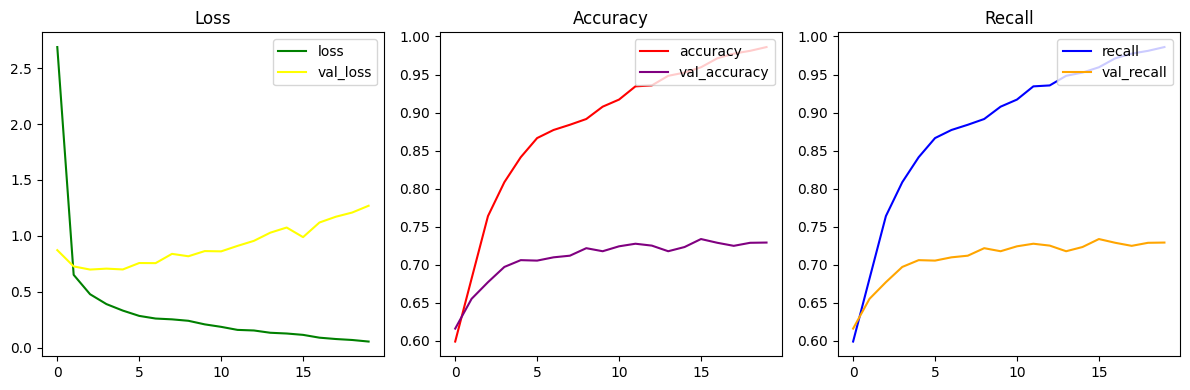

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_sequential_1_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_sequential_1_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_sequential_1_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_sequential_1_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_sequential_1_res.history['recall'], color='blue', label='recall')
axes[2].plot(calc_sequential_1_res.history['val_recall'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_sequential_1.save(ROOT + '/models/calc_sequential_1.keras')
# calc_sequential_1 = keras.models.load_model(ROOT + '/models/calc_sequential_1.keras')

In [ ]:
hist_df = pd.DataFrame(calc_sequential_1_res.history)
hist_df.to_csv(ROOT + '/history/calc_sequential_1_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_sequential_1.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - binary_accuracy: 0.6048 - loss: 1.2128 - recall: 0.6048
Loss:  1.1810016632080078
Accuracy:  0.6303191781044006
Recall:  0.6303191781044006


**Mass Sequential Model 1**

In [ ]:
mass_sequential_1 = Sequential()
mass_sequential_1.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
mass_sequential_1.add(MaxPooling2D())
mass_sequential_1.add(Conv2D(32, (3,3), 1, activation='relu'))
mass_sequential_1.add(MaxPooling2D())
mass_sequential_1.add(Conv2D(16, (3,3), 1, activation='relu'))
mass_sequential_1.add(MaxPooling2D())
mass_sequential_1.add(Flatten())
mass_sequential_1.add(Dense(256, activation='relu'))
mass_sequential_1.add(Dense(2, activation='sigmoid'))

mass_sequential_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,378 (10.60 MB)

 Trainable params: 2,779,378 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
mass_sequential_1.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_sequential_1_res = mass_sequential_1.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 3066s 8s/step - binary_accuracy: 0.5181 - loss: 1.4848 - recall_1: 0.6646 - val_binary_accuracy: 0.5264 - val_loss: 0.7284 - val_recall_1: 0.5533
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - binary_accuracy: 0.5772 - loss: 0.6284 - recall_1: 0.6159 - val_binary_accuracy: 0.5399 - val_loss: 0.7244 - val_recall_1: 0.5804
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - binary_accuracy: 0.6412 - loss: 0.5140 - recall_1: 0.6926 - val_binary_accuracy: 0.5488 - val_loss: 0.7419 - val_recall_1: 0.5978
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - binary_accuracy: 0.6909 - loss: 0.4236 - recall_1: 0.7423 - val_binary_accuracy: 0.5701 - val_loss: 0.7835 - val_recall_1: 0.6231
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - binary_accuracy: 0.7334 - loss: 0.3529 - recall_1: 0.7878 - val_binary_accuracy: 0.5813 - val_loss: 0.8334 - val_recall_1: 0.6382
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - binary_accurac

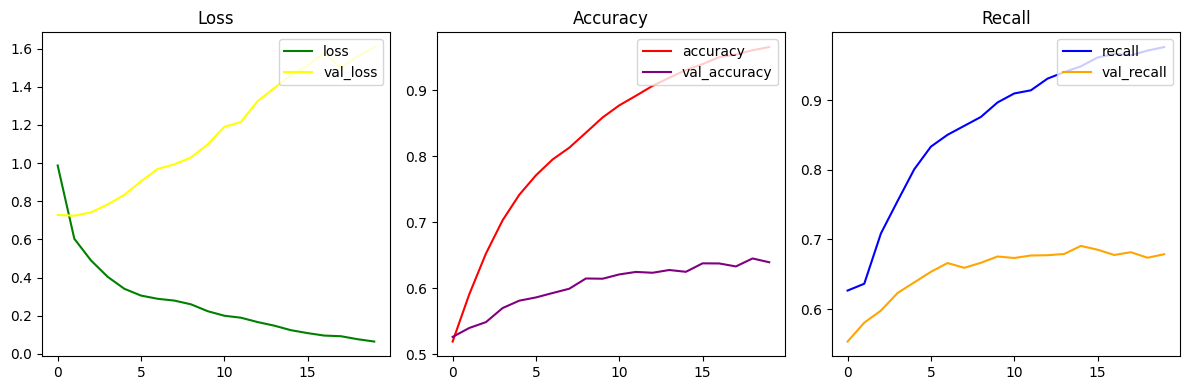

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_sequential_1_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_sequential_1_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_sequential_1_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_sequential_1_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_sequential_1_res.history['recall_1'], color='blue', label='recall')
axes[2].plot(mass_sequential_1_res.history['val_recall_1'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_sequential_1.save(ROOT + '/models/mass_sequential_1.keras')
# mass_sequential_1 = keras.models.load_model(ROOT + '/models/mass_sequential_1.keras')

In [ ]:
hist_df = pd.DataFrame(mass_sequential_1_res.history)
hist_df.to_csv(ROOT + '/history/mass_sequential_1_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_sequential_1.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

18/18 ━━━━━━━━━━━━━━━━━━━━ 117s 6s/step - binary_accuracy: 0.5696 - loss: 1.8207 - recall_1: 0.5714
Loss:  1.9759650230407715
Accuracy:  0.5524691343307495
Recall:  0.5582010746002197


**Calcification Sequential Model 2**

In [ ]:
calc_sequential_2 = Sequential()
calc_sequential_2.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
calc_sequential_2.add(MaxPooling2D())
calc_sequential_2.add(Conv2D(32, (3,3), 1, activation='relu'))
calc_sequential_2.add(MaxPooling2D())
calc_sequential_2.add(Conv2D(16, (3,3), 1, activation='relu'))
calc_sequential_2.add(MaxPooling2D())
calc_sequential_2.add(Flatten())
calc_sequential_2.add(Dense(256, activation='relu'))
calc_sequential_2.add(Dense(2, activation='softmax'))

calc_sequential_2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,378 (10.60 MB)

 Trainable params: 2,779,378 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
calc_sequential_2.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_sequential_2_res = calc_sequential_2.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - binary_accuracy: 0.6537 - loss: 0.7367 - recall_8: 0.6537 - val_binary_accuracy: 0.7118 - val_loss: 0.5835 - val_recall_8: 0.7118
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - binary_accuracy: 0.7274 - loss: 0.5728 - recall_8: 0.7274 - val_binary_accuracy: 0.7211 - val_loss: 0.5716 - val_recall_8: 0.7211
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - binary_accuracy: 0.7393 - loss: 0.5628 - recall_8: 0.7393 - val_binary_accuracy: 0.7342 - val_loss: 0.5647 - val_recall_8: 0.7342
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - binary_accuracy: 0.7571 - loss: 0.5421 - recall_8: 0.7571 - val_binary_accuracy: 0.7013 - val_loss: 0.5834 - val_recall_8: 0.7013
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - binary_accuracy: 0.7611 - loss: 0.5288 - recall_8: 0.7611 - val_binary_accuracy: 0.7013 - val_loss: 0.5740 - val_recall_8: 0.7013
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - binary_a

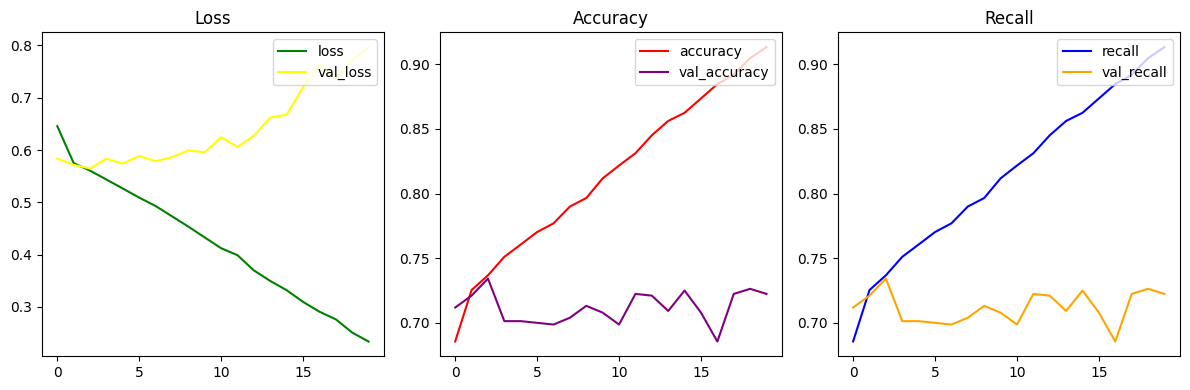

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_sequential_2_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_sequential_2_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_sequential_2_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_sequential_2_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_sequential_2_res.history['recall_8'], color='blue', label='recall')
axes[2].plot(calc_sequential_2_res.history['val_recall_8'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_sequential_2.save(ROOT + '/models/calc_sequential_2.keras')
# calc_sequential_2 = keras.models.load_model(ROOT + '/models/calc_sequential_2.keras')

In [ ]:
hist_df = pd.DataFrame(calc_sequential_2_res.history)
hist_df.to_csv(ROOT + '/history/calc_sequential_2_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_sequential_2.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - binary_accuracy: 0.6788 - loss: 1.0139 - recall_8: 0.6788
Loss:  1.0133891105651855
Accuracy:  0.6795699000358582
Recall:  0.6795699000358582


**Mass Sequential Model 2**

In [ ]:
mass_sequential_2 = Sequential()
mass_sequential_2.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
mass_sequential_2.add(MaxPooling2D())
mass_sequential_2.add(Conv2D(32, (3,3), 1, activation='relu'))
mass_sequential_2.add(MaxPooling2D())
mass_sequential_2.add(Conv2D(16, (3,3), 1, activation='relu'))
mass_sequential_2.add(MaxPooling2D())
mass_sequential_2.add(Flatten())
mass_sequential_2.add(Dense(256, activation='relu'))
mass_sequential_2.add(Dense(2, activation='softmax'))

mass_sequential_2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,378 (10.60 MB)

 Trainable params: 2,779,378 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
mass_sequential_2.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_sequential_2_res = mass_sequential_2.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 29s 187ms/step - binary_accuracy: 0.5225 - loss: 1.0218 - recall_9: 0.5225 - val_binary_accuracy: 0.5572 - val_loss: 0.6821 - val_recall_9: 0.5572
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - binary_accuracy: 0.5519 - loss: 0.6895 - recall_9: 0.5519 - val_binary_accuracy: 0.5608 - val_loss: 0.7160 - val_recall_9: 0.5608
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - binary_accuracy: 0.5721 - loss: 0.6862 - recall_9: 0.5721 - val_binary_accuracy: 0.6089 - val_loss: 0.6689 - val_recall_9: 0.6089
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - binary_accuracy: 0.5916 - loss: 0.6886 - recall_9: 0.5916 - val_binary_accuracy: 0.6294 - val_loss: 0.6578 - val_recall_9: 0.6294
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - binary_accuracy: 0.6134 - loss: 0.6574 - recall_9: 0.6134 - val_binary_accuracy: 0.6270 - val_loss: 0.6562 - val_recall_9: 0.6270
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - binary_a

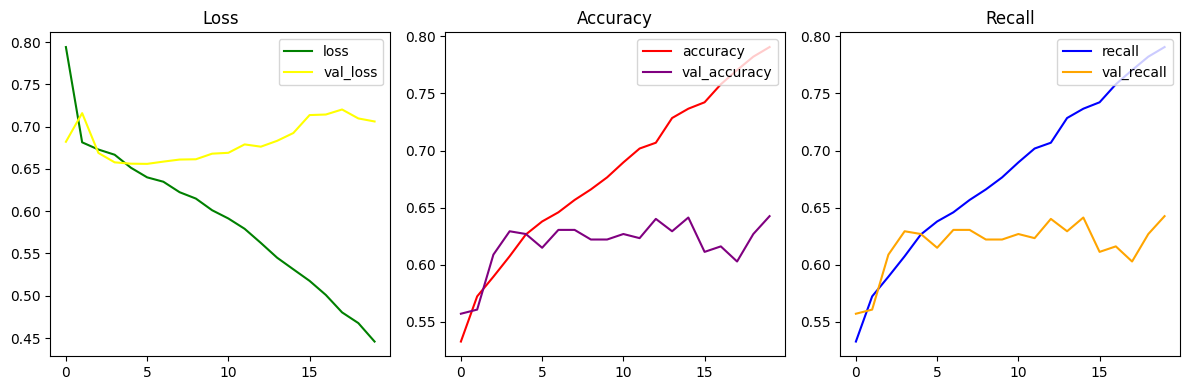

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_sequential_2_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_sequential_2_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_sequential_2_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_sequential_2_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_sequential_2_res.history['recall_9'], color='blue', label='recall')
axes[2].plot(mass_sequential_2_res.history['val_recall_9'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_sequential_2.save(ROOT + '/models/mass_sequential_2.keras')
# mass_sequential_2 = keras.models.load_model(ROOT + '/models/mass_sequential_2.keras')

In [ ]:
hist_df = pd.DataFrame(mass_sequential_2_res.history)
hist_df.to_csv(ROOT + '/history/mass_sequential_2_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_sequential_2.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - binary_accuracy: 0.5692 - loss: 0.8354 - recall_9: 0.5692
Loss:  0.8802034854888916
Accuracy:  0.5452755689620972
Recall:  0.5452755689620972


**Calcification Sequential Model 3**

In [ ]:
calc_sequential_3 = Sequential()
calc_sequential_3.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
calc_sequential_3.add(MaxPooling2D())
calc_sequential_3.add(Conv2D(32, (3,3), 1, activation='relu'))
calc_sequential_3.add(MaxPooling2D())
calc_sequential_3.add(Conv2D(16, (3,3), 1, activation='relu'))
calc_sequential_3.add(MaxPooling2D())
calc_sequential_3.add(Flatten())
calc_sequential_3.add(Dense(256, activation='relu'))
calc_sequential_3.add(Dense(2, activation='softmax'))

calc_sequential_3.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,378 (10.60 MB)

 Trainable params: 2,779,378 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
calc_sequential_3.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_sequential_3_res = calc_sequential_3.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 539s 5s/step - binary_accuracy: 0.5493 - loss: 3.1035 - recall_1: 0.5493 - val_binary_accuracy: 0.6447 - val_loss: 1.1094 - val_recall_1: 0.6447
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - binary_accuracy: 0.7594 - loss: 0.6243 - recall_1: 0.7594 - val_binary_accuracy: 0.6711 - val_loss: 0.9014 - val_recall_1: 0.6711
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - binary_accuracy: 0.8717 - loss: 0.3219 - recall_1: 0.8717 - val_binary_accuracy: 0.6816 - val_loss: 0.9139 - val_recall_1: 0.6816
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - binary_accuracy: 0.9270 - loss: 0.2059 - recall_1: 0.9270 - val_binary_accuracy: 0.6908 - val_loss: 0.9144 - val_recall_1: 0.6908
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - binary_accuracy: 0.9679 - loss: 0.1227 - recall_1: 0.9679 - val_binary_accuracy: 0.6974 - val_loss: 0.9427 - val_recall_1: 0.6974
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - binary_accur

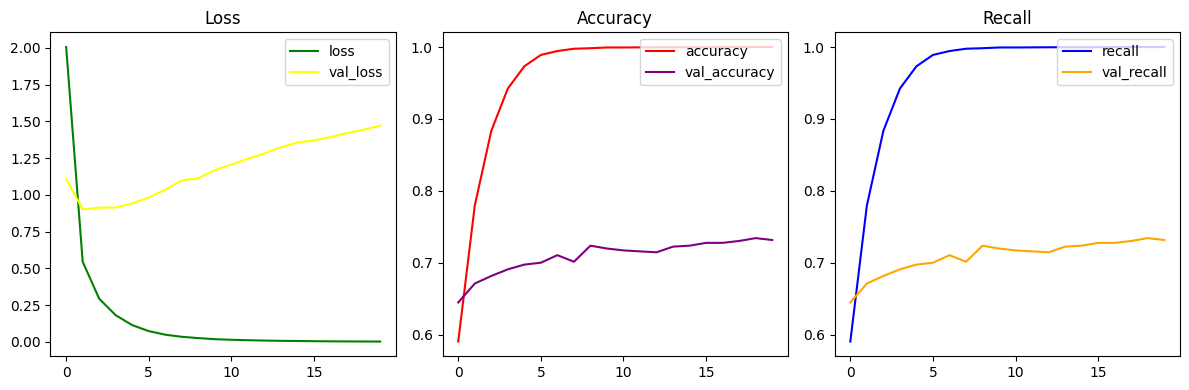

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_sequential_3_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_sequential_3_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_sequential_3_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_sequential_3_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_sequential_3_res.history['recall_1'], color='blue', label='recall')
axes[2].plot(calc_sequential_3_res.history['val_recall_1'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_sequential_3.save(ROOT + '/models/calc_sequential_3.keras')
# calc_sequential_3 = keras.models.load_model(ROOT + '/models/calc_sequential_3.keras')

In [ ]:
hist_df = pd.DataFrame(calc_sequential_3_res.history)
hist_df.to_csv(ROOT + '/history/calc_sequential_3_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_sequential_3.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

8/8 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - binary_accuracy: 0.6651 - loss: 1.5318 - recall_1: 0.6651
Loss:  1.730941891670227
Accuracy:  0.6430107355117798
Recall:  0.6430107355117798


**Mass Sequential Model 3**

In [ ]:
mass_sequential_3 = Sequential()
mass_sequential_3.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
mass_sequential_3.add(MaxPooling2D())
mass_sequential_3.add(Conv2D(32, (3,3), 1, activation='relu'))
mass_sequential_3.add(MaxPooling2D())
mass_sequential_3.add(Conv2D(16, (3,3), 1, activation='relu'))
mass_sequential_3.add(MaxPooling2D())
mass_sequential_3.add(Flatten())
mass_sequential_3.add(Dense(256, activation='relu'))
mass_sequential_3.add(Dense(2, activation='softmax'))

mass_sequential_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,378 (10.60 MB)

 Trainable params: 2,779,378 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
mass_sequential_3.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_sequential_3_res = mass_sequential_3.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 790s 7s/step - binary_accuracy: 0.5047 - loss: 4.2576 - recall_2: 0.5047 - val_binary_accuracy: 0.5319 - val_loss: 1.0872 - val_recall_2: 0.5319
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - binary_accuracy: 0.6457 - loss: 0.7534 - recall_2: 0.6457 - val_binary_accuracy: 0.5656 - val_loss: 0.9647 - val_recall_2: 0.5656
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - binary_accuracy: 0.8032 - loss: 0.4292 - recall_2: 0.8032 - val_binary_accuracy: 0.5776 - val_loss: 0.9708 - val_recall_2: 0.5776
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - binary_accuracy: 0.8986 - loss: 0.2695 - recall_2: 0.8986 - val_binary_accuracy: 0.5897 - val_loss: 0.9950 - val_recall_2: 0.5897
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - binary_accuracy: 0.9637 - loss: 0.1678 - recall_2: 0.9637 - val_binary_accuracy: 0.6101 - val_loss: 1.0430 - val_recall_2: 0.6101
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - binary_accu

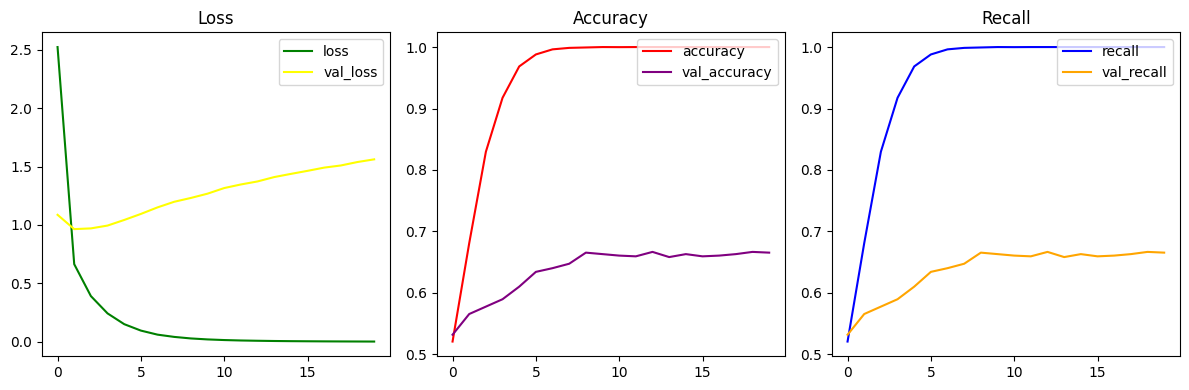

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_sequential_3_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_sequential_3_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_sequential_3_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_sequential_3_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_sequential_3_res.history['recall_2'], color='blue', label='recall')
axes[2].plot(mass_sequential_3_res.history['val_recall_2'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_sequential_3.save(ROOT + '/models/mass_sequential_3.keras')
# mass_sequential_3 = keras.models.load_model(ROOT + '/models/mass_sequential_3.keras')

In [ ]:
hist_df = pd.DataFrame(mass_sequential_3_res.history)
hist_df.to_csv(ROOT + '/history/mass_sequential_3_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_sequential_3.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - binary_accuracy: 0.4864 - loss: 2.5399 - recall_2: 0.4864
Loss:  2.351032257080078
Accuracy:  0.49803149700164795
Recall:  0.49803149700164795


**Calcification Sequential Model 4**

In [ ]:
calc_sequential_4 = Sequential()
calc_sequential_4.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
calc_sequential_4.add(MaxPooling2D())
calc_sequential_4.add(Conv2D(32, (3,3), 1, activation='relu'))
calc_sequential_4.add(MaxPooling2D())
calc_sequential_4.add(Conv2D(16, (3,3), 1, activation='relu'))
calc_sequential_4.add(MaxPooling2D())
calc_sequential_4.add(Flatten())
calc_sequential_4.add(Dense(256, activation='relu'))
calc_sequential_4.add(Dense(2, activation='softmax'))

calc_sequential_4.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,378 (10.60 MB)

 Trainable params: 2,779,378 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
calc_sequential_4.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_sequential_4_res = calc_sequential_4.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - binary_accuracy: 0.6027 - loss: 5.3604 - recall: 0.6027 - val_binary_accuracy: 0.6276 - val_loss: 1.2652 - val_recall: 0.6276
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - binary_accuracy: 0.7301 - loss: 0.7800 - recall: 0.7301 - val_binary_accuracy: 0.6547 - val_loss: 1.0181 - val_recall: 0.6547
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - binary_accuracy: 0.8414 - loss: 0.3860 - recall: 0.8414 - val_binary_accuracy: 0.6658 - val_loss: 0.9731 - val_recall: 0.6658
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - binary_accuracy: 0.9114 - loss: 0.2229 - recall: 0.9114 - val_binary_accuracy: 0.6708 - val_loss: 0.9813 - val_recall: 0.6708
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - binary_accuracy: 0.9568 - loss: 0.1388 - recall: 0.9568 - val_binary_accuracy: 0.6597 - val_loss: 1.0063 - val_recall: 0.6597
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - binary_accuracy: 0.9797 - loss: 0.0

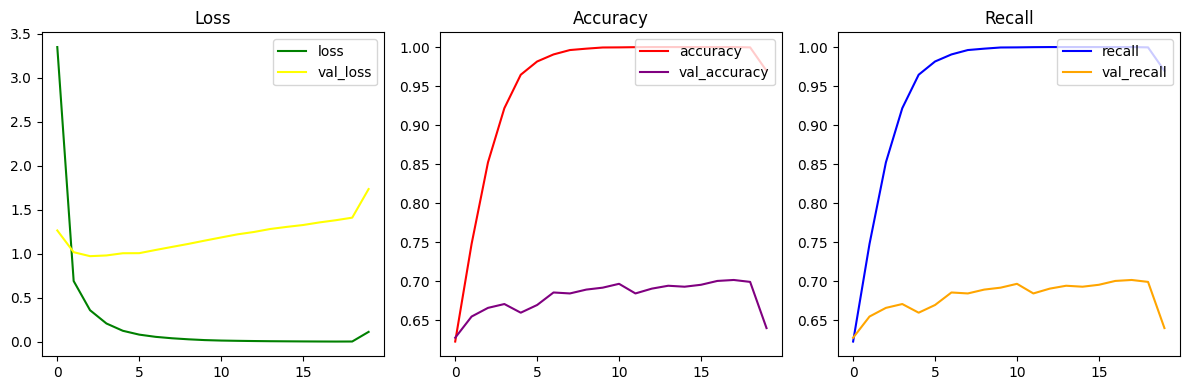

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_sequential_4_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_sequential_4_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_sequential_4_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_sequential_4_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_sequential_4_res.history['recall'], color='blue', label='recall')
axes[2].plot(calc_sequential_4_res.history['val_recall'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_sequential_4.save(ROOT + '/models/calc_sequential_4.keras')
# cal_sequential_4 = keras.models.load_model(ROOT + '/models/calc_sequential_4.keras')

In [ ]:
hist_df = pd.DataFrame(calc_sequential_4_res.history)
hist_df.to_csv(ROOT + '/history/calc_sequential_4_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_sequential_4.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - binary_accuracy: 0.6521 - loss: 1.9585 - recall: 0.6521
Loss:  1.892897605895996
Accuracy:  0.6547314524650574
Recall:  0.6547314524650574


**Mass Sequential Model 4**

In [ ]:
mass_sequential_4 = Sequential()
mass_sequential_4.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
mass_sequential_4.add(MaxPooling2D())
mass_sequential_4.add(Conv2D(32, (3,3), 1, activation='relu'))
mass_sequential_4.add(MaxPooling2D())
mass_sequential_4.add(Conv2D(16, (3,3), 1, activation='relu'))
mass_sequential_4.add(MaxPooling2D())
mass_sequential_4.add(Flatten())
mass_sequential_4.add(Dense(256, activation='relu'))
mass_sequential_4.add(Dense(2, activation='softmax'))

mass_sequential_4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,378 (10.60 MB)

 Trainable params: 2,779,378 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
mass_sequential_4.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_sequential_4_res = mass_sequential_4.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - binary_accuracy: 0.5281 - loss: 1.7918 - recall_1: 0.5281 - val_binary_accuracy: 0.5033 - val_loss: 0.8566 - val_recall_1: 0.5033
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - binary_accuracy: 0.6973 - loss: 0.5866 - recall_1: 0.6973 - val_binary_accuracy: 0.5477 - val_loss: 0.8557 - val_recall_1: 0.5477
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - binary_accuracy: 0.8455 - loss: 0.3752 - recall_1: 0.8455 - val_binary_accuracy: 0.5813 - val_loss: 0.8796 - val_recall_1: 0.5813
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - binary_accuracy: 0.9305 - loss: 0.2430 - recall_1: 0.9305 - val_binary_accuracy: 0.5922 - val_loss: 0.9476 - val_recall_1: 0.5922
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - binary_accuracy: 0.9697 - loss: 0.1515 - recall_1: 0.9697 - val_binary_accuracy: 0.6009 - val_loss: 1.0233 - val_recall_1: 0.6009
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - binary_accuracy

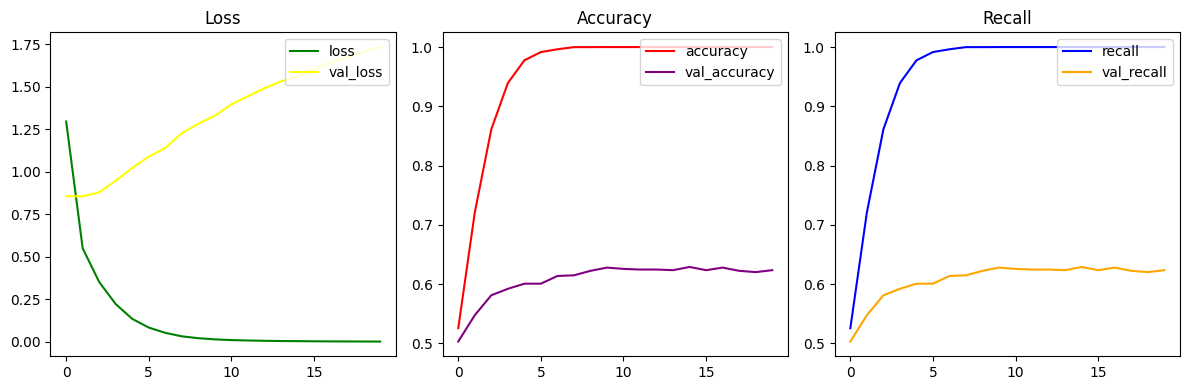

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_sequential_4_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_sequential_4_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_sequential_4_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_sequential_4_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_sequential_4_res.history['recall_1'], color='blue', label='recall')
axes[2].plot(mass_sequential_4_res.history['val_recall_1'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_sequential_4.save(ROOT + '/models/mass_sequential_4.keras')
# mass_sequential_4 = keras.models.load_model(ROOT + '/models/mass_sequential_4.keras')

In [ ]:
hist_df = pd.DataFrame(mass_sequential_4_res.history)
hist_df.to_csv(ROOT + '/history/mass_sequential_4_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_sequential_4.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - binary_accuracy: 0.5401 - loss: 1.9876 - recall_1: 0.5401
Loss:  2.123134136199951
Accuracy:  0.5555555820465088
Recall:  0.5555555820465088


**Calcification Sequential Model 5**

In [ ]:
calc_sequential_5 = Sequential()
calc_sequential_5.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
calc_sequential_5.add(MaxPooling2D())
calc_sequential_5.add(Conv2D(32, (3,3), 1, activation='relu'))
calc_sequential_5.add(MaxPooling2D())
calc_sequential_5.add(Conv2D(16, (3,3), 1, activation='relu'))
calc_sequential_5.add(MaxPooling2D())
calc_sequential_5.add(Flatten())
calc_sequential_5.add(Dense(256, activation='relu'))
calc_sequential_5.add(Dense(2, activation='softmax'))

calc_sequential_5.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,378 (10.60 MB)

 Trainable params: 2,779,378 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
calc_sequential_5.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_sequential_5_res = calc_sequential_5.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - binary_accuracy: 0.5804 - loss: 5.2351 - recall_3: 0.5804 - val_binary_accuracy: 0.6300 - val_loss: 0.7242 - val_recall_3: 0.6300
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - binary_accuracy: 0.6530 - loss: 0.6529 - recall_3: 0.6530 - val_binary_accuracy: 0.6537 - val_loss: 0.6249 - val_recall_3: 0.6537
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - binary_accuracy: 0.6797 - loss: 0.5917 - recall_3: 0.6797 - val_binary_accuracy: 0.6591 - val_loss: 0.5972 - val_recall_3: 0.6591
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - binary_accuracy: 0.7010 - loss: 0.5489 - recall_3: 0.7010 - val_binary_accuracy: 0.6634 - val_loss: 0.6010 - val_recall_3: 0.6634
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - binary_accuracy: 0.7383 - loss: 0.5075 - recall_3: 0.7383 - val_binary_accuracy: 0.6667 - val_loss: 0.6368 - val_recall_3: 0.6667
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - binary_a

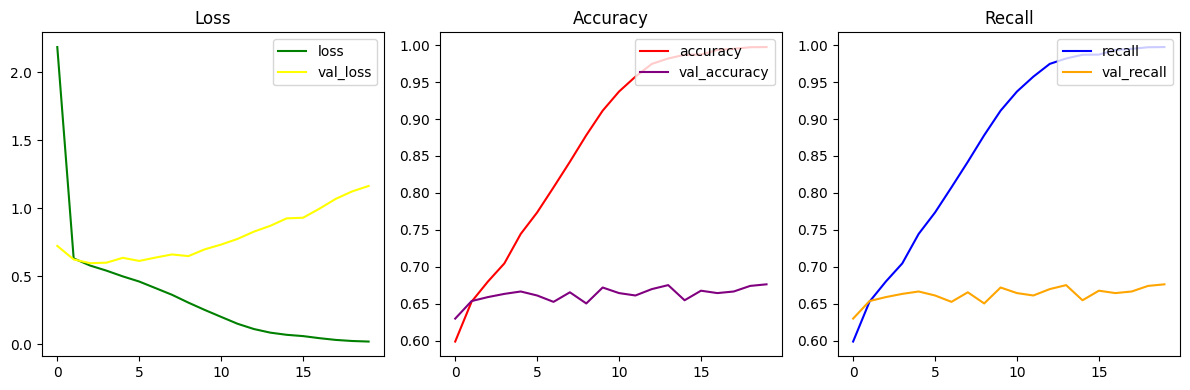

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_sequential_5_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_sequential_5_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_sequential_5_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_sequential_5_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_sequential_5_res.history['recall_3'], color='blue', label='recall')
axes[2].plot(calc_sequential_5_res.history['val_recall_3'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_sequential_5.save(ROOT + '/models/calc_sequential_5.keras')
# calc_sequential_5 = keras.models.load_model(ROOT + '/models/calc_sequential_5.keras')

In [ ]:
hist_df = pd.DataFrame(calc_sequential_5_res.history)
hist_df.to_csv(ROOT + '/history/calc_sequential_5_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_sequential_5.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - binary_accuracy: 0.6407 - loss: 1.3850 - recall_3: 0.6407
Loss:  1.4226456880569458
Accuracy:  0.6226993799209595
Recall:  0.6226993799209595


**Mass Sequential Model 5**

In [ ]:
mass_sequential_5 = Sequential()
mass_sequential_5.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
mass_sequential_5.add(MaxPooling2D())
mass_sequential_5.add(Conv2D(32, (3,3), 1, activation='relu'))
mass_sequential_5.add(MaxPooling2D())
mass_sequential_5.add(Conv2D(16, (3,3), 1, activation='relu'))
mass_sequential_5.add(MaxPooling2D())
mass_sequential_5.add(Flatten())
mass_sequential_5.add(Dense(256, activation='relu'))
mass_sequential_5.add(Dense(2, activation='softmax'))

mass_sequential_5.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,378 (10.60 MB)

 Trainable params: 2,779,378 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
mass_sequential_5.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_sequential_5_res = mass_sequential_5.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - binary_accuracy: 0.5379 - loss: 0.7060 - recall_4: 0.5379 - val_binary_accuracy: 0.5772 - val_loss: 0.6957 - val_recall_4: 0.5772
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - binary_accuracy: 0.5741 - loss: 0.6814 - recall_4: 0.5741 - val_binary_accuracy: 0.6000 - val_loss: 0.6728 - val_recall_4: 0.6000
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - binary_accuracy: 0.6041 - loss: 0.6593 - recall_4: 0.6041 - val_binary_accuracy: 0.5962 - val_loss: 0.6760 - val_recall_4: 0.5962
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - binary_accuracy: 0.6171 - loss: 0.6462 - recall_4: 0.6171 - val_binary_accuracy: 0.6139 - val_loss: 0.6641 - val_recall_4: 0.6139
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - binary_accuracy: 0.6544 - loss: 0.6240 - recall_4: 0.6544 - val_binary_accuracy: 0.6152 - val_loss: 0.6562 - val_recall_4: 0.6152
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - binary_a

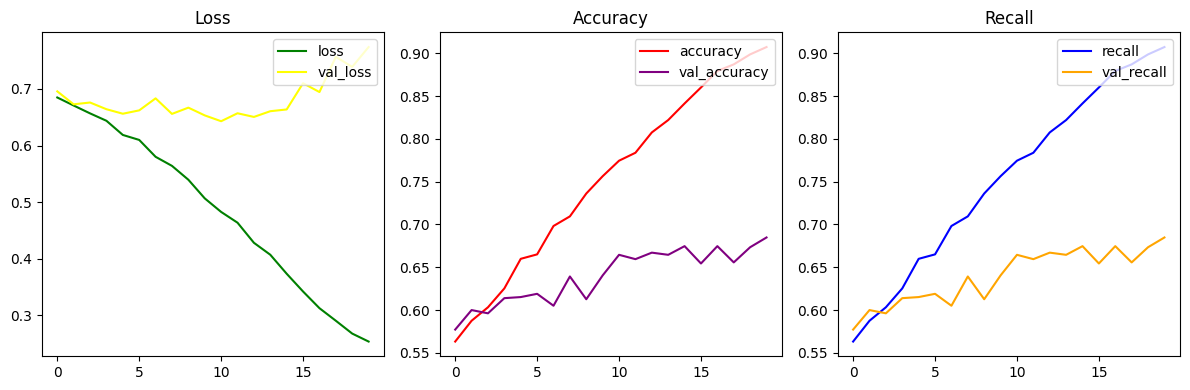

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_sequential_5_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_sequential_5_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_sequential_5_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_sequential_5_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_sequential_5_res.history['recall_4'], color='blue', label='recall')
axes[2].plot(mass_sequential_5_res.history['val_recall_4'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_sequential_5.save(ROOT + '/models/mass_sequential_5.keras')
# mass_sequential_5 = keras.models.load_model(ROOT + '/models/mass_sequential_5.keras')

In [ ]:
hist_df = pd.DataFrame(mass_sequential_5_res.history)
hist_df.to_csv(ROOT + '/history/mass_sequential_5_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_sequential_5.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - binary_accuracy: 0.6750 - loss: 0.7847 - recall_4: 0.6750
Loss:  0.7365120649337769
Accuracy:  0.6719576716423035
Recall:  0.6719576716423035


**Calcification Sequential Model 6**

In [ ]:
calc_sequential_6 = Sequential()
calc_sequential_6.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
calc_sequential_6.add(MaxPooling2D())
calc_sequential_6.add(Conv2D(32, (3,3), 1, activation='relu'))
calc_sequential_6.add(MaxPooling2D())
calc_sequential_6.add(Conv2D(16, (3,3), 1, activation='relu'))
calc_sequential_6.add(MaxPooling2D())
calc_sequential_6.add(Flatten())
calc_sequential_6.add(Dense(256, activation='relu'))
calc_sequential_6.add(Dense(2, activation='softmax'))

calc_sequential_6.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,378 (10.60 MB)

 Trainable params: 2,779,378 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
calc_sequential_6.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_sequential_6_res = calc_sequential_6.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - binary_accuracy: 0.6023 - loss: 5.3652 - recall_7: 0.6023 - val_binary_accuracy: 0.6645 - val_loss: 0.7159 - val_recall_7: 0.6645
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - binary_accuracy: 0.6624 - loss: 0.6400 - recall_7: 0.6624 - val_binary_accuracy: 0.6505 - val_loss: 0.6900 - val_recall_7: 0.6505
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - binary_accuracy: 0.7115 - loss: 0.5485 - recall_7: 0.7115 - val_binary_accuracy: 0.6526 - val_loss: 0.6478 - val_recall_7: 0.6526
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - binary_accuracy: 0.7594 - loss: 0.4676 - recall_7: 0.7594 - val_binary_accuracy: 0.6602 - val_loss: 0.6548 - val_recall_7: 0.6602
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - binary_accuracy: 0.7911 - loss: 0.4103 - recall_7: 0.7911 - val_binary_accuracy: 0.6753 - val_loss: 0.7099 - val_recall_7: 0.6753
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - binary_a

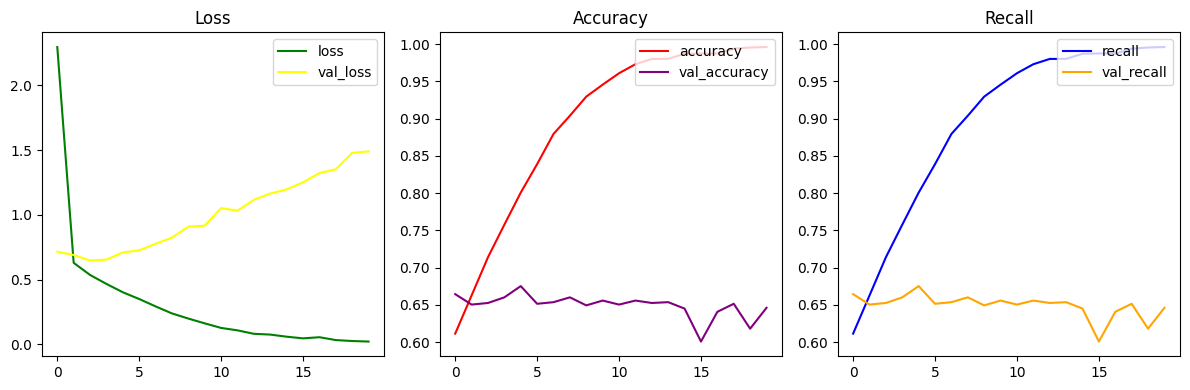

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_sequential_6_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_sequential_6_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_sequential_6_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_sequential_6_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_sequential_6_res.history['recall_7'], color='blue', label='recall')
axes[2].plot(calc_sequential_6_res.history['val_recall_7'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_sequential_6.save(ROOT + '/models/calc_sequential_6.keras')
# calc_sequential_6 = keras.models.load_model(ROOT + '/models/calc_sequential_6.keras')

In [ ]:
hist_df = pd.DataFrame(calc_sequential_6_res.history)
hist_df.to_csv(ROOT + '/history/calc_sequential_6_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_sequential_6.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - binary_accuracy: 0.5853 - loss: 1.6049 - recall_7: 0.5853
Loss:  1.6737641096115112
Accuracy:  0.5736196041107178
Recall:  0.5736196041107178


**Mass Sequential Model 6**

In [ ]:
mass_sequential_6 = Sequential()
mass_sequential_6.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
mass_sequential_6.add(MaxPooling2D())
mass_sequential_6.add(Conv2D(32, (3,3), 1, activation='relu'))
mass_sequential_6.add(MaxPooling2D())
mass_sequential_6.add(Conv2D(16, (3,3), 1, activation='relu'))
mass_sequential_6.add(MaxPooling2D())
mass_sequential_6.add(Flatten())
mass_sequential_6.add(Dense(256, activation='relu'))
mass_sequential_6.add(Dense(2, activation='softmax'))

mass_sequential_6.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,378 (10.60 MB)

 Trainable params: 2,779,378 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
mass_sequential_6.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_sequential_6_res = mass_sequential_6.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - binary_accuracy: 0.5024 - loss: 16.2577 - recall_8: 0.5024 - val_binary_accuracy: 0.5291 - val_loss: 1.5370 - val_recall_8: 0.5291
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - binary_accuracy: 0.5075 - loss: 0.8715 - recall_8: 0.5075 - val_binary_accuracy: 0.4709 - val_loss: 0.7863 - val_recall_8: 0.4709
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - binary_accuracy: 0.5058 - loss: 0.9302 - recall_8: 0.5058 - val_binary_accuracy: 0.4709 - val_loss: 0.8326 - val_recall_8: 0.4709
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - binary_accuracy: 0.4988 - loss: 0.7865 - recall_8: 0.4988 - val_binary_accuracy: 0.4722 - val_loss: 0.7013 - val_recall_8: 0.4722
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - binary_accuracy: 0.5104 - loss: 0.7127 - recall_8: 0.5104 - val_binary_accuracy: 0.5291 - val_loss: 0.6922 - val_recall_8: 0.5291
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - binary_

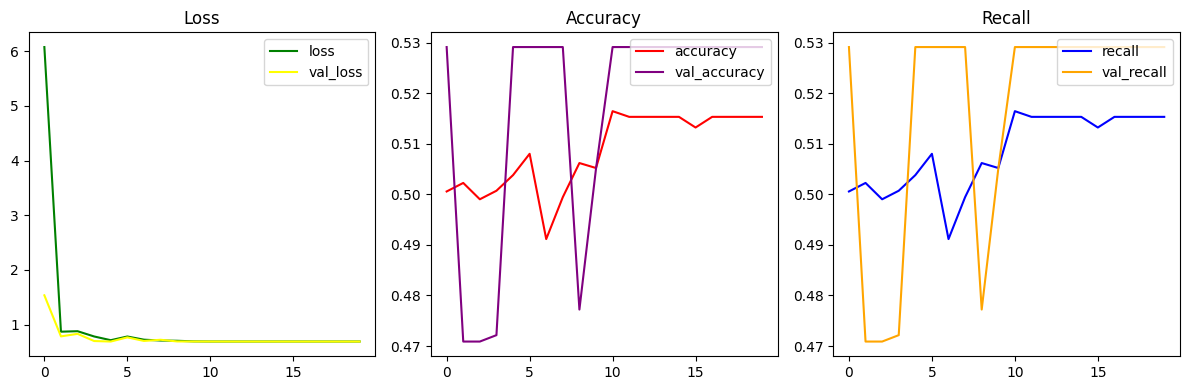

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_sequential_6_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_sequential_6_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_sequential_6_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_sequential_6_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_sequential_6_res.history['recall_8'], color='blue', label='recall')
axes[2].plot(mass_sequential_6_res.history['val_recall_8'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_sequential_6.save(ROOT + '/models/mass_sequential_6.keras')
# mass_sequential_6 = keras.models.load_model(ROOT + '/models/mass_sequential_6.keras')

In [ ]:
hist_df = pd.DataFrame(mass_sequential_6_res.history)
hist_df.to_csv(ROOT + '/history/mass_sequential_6_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_sequential_6.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - binary_accuracy: 0.6031 - loss: 0.6874 - recall_8: 0.6031
Loss:  0.686902642250061
Accuracy:  0.6111111044883728
Recall:  0.6111111044883728


**Combined Sequential**

In [ ]:
combined_sequential_1 = Sequential()
combined_sequential_1.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
combined_sequential_1.add(MaxPooling2D())
combined_sequential_1.add(Conv2D(32, (3,3), 1, activation='relu'))
combined_sequential_1.add(MaxPooling2D())
combined_sequential_1.add(Conv2D(16, (3,3), 1, activation='relu'))
combined_sequential_1.add(MaxPooling2D())
combined_sequential_1.add(Flatten())
combined_sequential_1.add(Dense(256, activation='relu'))
combined_sequential_1.add(Dense(2, activation='softmax'))

combined_sequential_1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779,378 (10.60 MB)

 Trainable params: 2,779,378 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
combined_sequential_1.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
combined_sequential_1_res = combined_sequential_1.fit(combined_train, epochs=20, verbose=1, validation_data=combined_val)

Epoch 1/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 4836s 9s/step - binary_accuracy: 0.5412 - loss: 5.2676 - recall_10: 0.5412 - val_binary_accuracy: 0.5916 - val_loss: 0.7724 - val_recall_10: 0.5916
Epoch 2/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 55s 97ms/step - binary_accuracy: 0.6020 - loss: 0.6810 - recall_10: 0.6020 - val_binary_accuracy: 0.5976 - val_loss: 0.7322 - val_recall_10: 0.5976
Epoch 3/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 55s 97ms/step - binary_accuracy: 0.6906 - loss: 0.5528 - recall_10: 0.6906 - val_binary_accuracy: 0.6100 - val_loss: 0.7353 - val_recall_10: 0.6100
Epoch 4/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 55s 97ms/step - binary_accuracy: 0.7514 - loss: 0.4650 - recall_10: 0.7514 - val_binary_accuracy: 0.6180 - val_loss: 0.7619 - val_recall_10: 0.6180
Epoch 5/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 54s 95ms/step - binary_accuracy: 0.7947 - loss: 0.3916 - recall_10: 0.7947 - val_binary_accuracy: 0.6252 - val_loss: 0.8037 - val_recall_10: 0.6252
Epoch 6/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 54s 96ms/step - bina

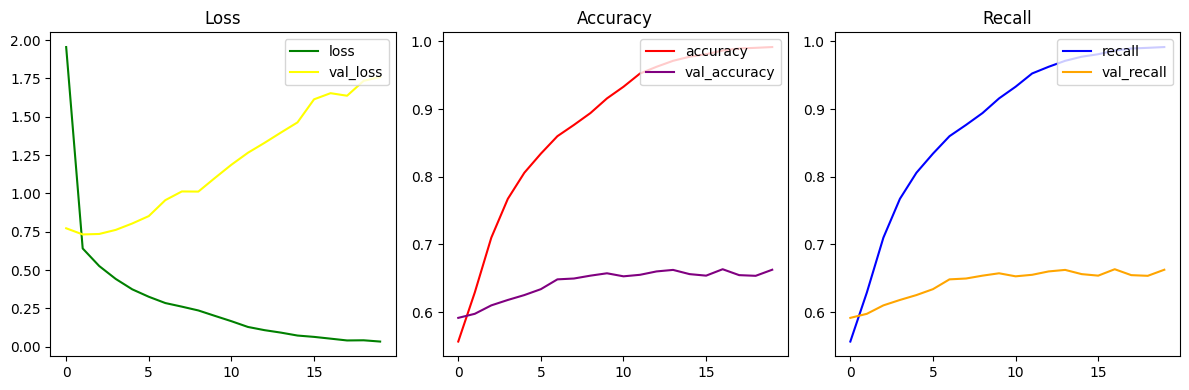

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(combined_sequential_1_res.history['loss'], color='green', label='loss')
axes[0].plot(combined_sequential_1_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(combined_sequential_1_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(combined_sequential_1_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(combined_sequential_1_res.history['recall_10'], color='blue', label='recall')
axes[2].plot(combined_sequential_1_res.history['val_recall_10'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
combined_sequential_1.save(ROOT + '/models/combined_sequential_1.keras')
# combined_sequential_1 = keras.models.load_model(ROOT + '/models/combined_sequential_1.keras')

In [ ]:
hist_df = pd.DataFrame(combined_sequential_1_res.history)
hist_df.to_csv(ROOT + '/history/combined_sequential_1_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
loss, accuracy, recall = combined_sequential_1.evaluate(combined_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)
print("Recall: ", recall)

17/17 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - binary_accuracy: 0.5878 - loss: 2.1329 - recall_10: 0.5878
Loss:  2.1648104190826416
Accuracy:  0.5698529481887817
Recall:  0.5698529481887817


# **VGG16**

**Calcification VGG16 Model 1**

In [ ]:
# I borrowed the model architecture from here: https://github.com/hema2107/VGG16-for-Brain-MRI-Images
def preprocess(image, label):
  image=tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (image_height, image_width, 3))

for layer in vgg16.layers:
    layer.trainable = False

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

output = lw(vgg16, 2)
calc_vgg16_1 = Model(inputs = vgg16.input, outputs = output)
calc_vgg16_1.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
calc_vgg16_1.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
calc_vgg16_1_res = calc_vgg16_1.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 831s 2s/step - binary_accuracy: 0.6875 - loss: 0.6715 - recall: 0.6875 - val_binary_accuracy: 0.7442 - val_loss: 0.4957 - val_recall: 0.7442
Epoch 2/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 155s 338ms/step - binary_accuracy: 0.7416 - loss: 0.4956 - recall: 0.7416 - val_binary_accuracy: 0.7587 - val_loss: 0.4725 - val_recall: 0.7587
Epoch 3/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 155s 338ms/step - binary_accuracy: 0.7711 - loss: 0.4546 - recall: 0.7711 - val_binary_accuracy: 0.7701 - val_loss: 0.4560 - val_recall: 0.7701
Epoch 4/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 155s 338ms/step - binary_accuracy: 0.7946 - loss: 0.4157 - recall: 0.7946 - val_binary_accuracy: 0.7821 - val_loss: 0.4673 - val_recall: 0.7821
Epoch 5/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 155s 338ms/step - binary_accuracy: 0.8145 - loss: 0.3814 - recall: 0.8145 - val_binary_accuracy: 0.7963 - val_loss: 0.4501 - val_recall: 0.7963
Epoch 6/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 155s 338ms/step - binary_accuracy: 0.8320 -

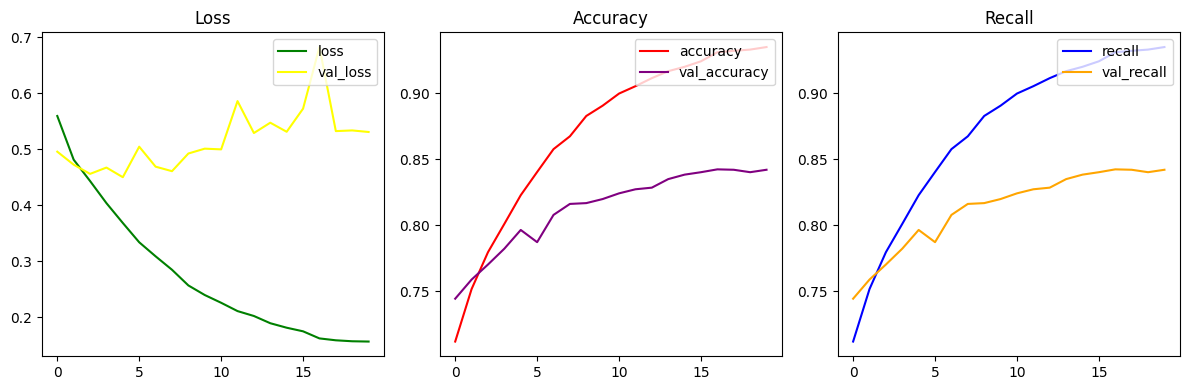

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_vgg16_1_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_vgg16_1_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_vgg16_1_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_vgg16_1_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_vgg16_1_res.history['recall'], color='blue', label='recall')
axes[2].plot(calc_vgg16_1_res.history['val_recall'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_vgg16_1.save(ROOT + '/models/calc_vgg16_1.keras')
# calc_vgg16_1 = keras.models.load_model(ROOT + '/models/calc_vgg16_1.keras')

In [ ]:
hist_df = pd.DataFrame(calc_vgg16_1_res.history)
hist_df.to_csv(ROOT + '/history/calc_vgg16_1_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_vgg16_1.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - binary_accuracy: 0.6049 - loss: 2.4647 - recall: 0.6049
Loss:  2.5284264087677
Accuracy:  0.6090425252914429
Recall:  0.6090425252914429


**Mass VGG16 Model 1**

In [ ]:
# I borrowed the model architecture from here: https://github.com/hema2107/VGG16-for-Brain-MRI-Images
def preprocess(image, label):
  image=tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (image_height, image_width, 3))

for layer in vgg16.layers:
    layer.trainable = False

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

output = lw(vgg16, 2)
mass_vgg16_1 = Model(inputs = vgg16.input, outputs = output)
mass_vgg16_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
mass_vgg16_1.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
mass_vgg16_1_res = mass_vgg16_1.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 738s 2s/step - binary_accuracy: 0.5880 - loss: 0.8048 - recall_1: 0.5880 - val_binary_accuracy: 0.6523 - val_loss: 0.6123 - val_recall_1: 0.6523
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 133s 341ms/step - binary_accuracy: 0.6752 - loss: 0.5919 - recall_1: 0.6752 - val_binary_accuracy: 0.6809 - val_loss: 0.5853 - val_recall_1: 0.6809
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 132s 338ms/step - binary_accuracy: 0.7088 - loss: 0.5435 - recall_1: 0.7088 - val_binary_accuracy: 0.6979 - val_loss: 0.5682 - val_recall_1: 0.6979
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 132s 338ms/step - binary_accuracy: 0.7325 - loss: 0.5062 - recall_1: 0.7325 - val_binary_accuracy: 0.7008 - val_loss: 0.5625 - val_recall_1: 0.7008
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 132s 338ms/step - binary_accuracy: 0.7520 - loss: 0.4705 - recall_1: 0.7520 - val_binary_accuracy: 0.7163 - val_loss: 0.5620 - val_recall_1: 0.7163
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 132s 338ms/step - binar

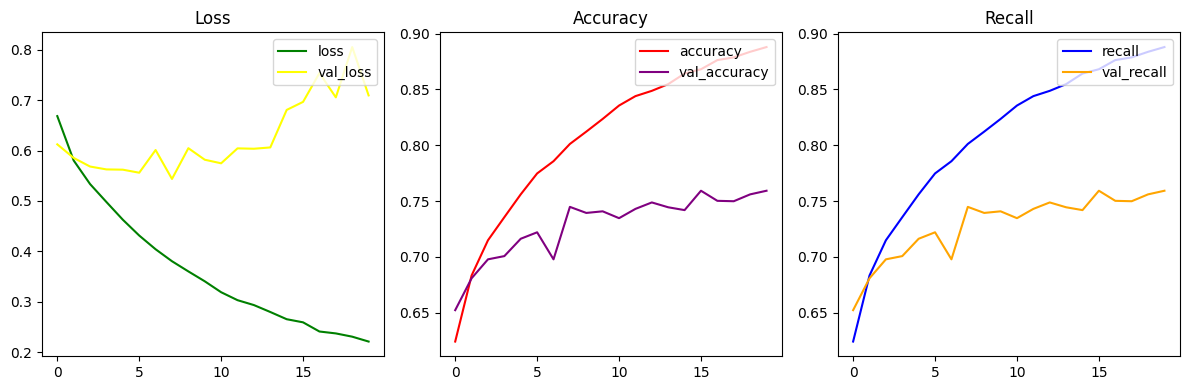

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_vgg16_1_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_vgg16_1_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_vgg16_1_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_vgg16_1_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_vgg16_1_res.history['recall_1'], color='blue', label='recall')
axes[2].plot(mass_vgg16_1_res.history['val_recall_1'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_vgg16_1.save(ROOT + '/models/mass_vgg16_1.keras')
# mass_vgg16_1 = keras.models.load_model(ROOT + '/models/mass_vgg16_1.keras')

In [ ]:
hist_df = pd.DataFrame(mass_vgg16_1_res.history)
hist_df.to_csv(ROOT + '/history/mass_vgg16_1_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_vgg16_1.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - binary_accuracy: 0.6153 - loss: 2.0041 - recall_1: 0.6153
Loss:  2.1989619731903076
Accuracy:  0.604938268661499
Recall:  0.604938268661499


**Calcification VGG16 Model 2**

In [ ]:
# I borrowed the model architecture from here: https://github.com/hema2107/VGG16-for-Brain-MRI-Images
def preprocess(image, label):
  image=tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (image_height, image_width, 3))

for layer in vgg16.layers:
    layer.trainable = False

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

output = lw(vgg16, 2)
calc_vgg16_2 = Model(inputs = vgg16.input, outputs = output)
calc_vgg16_2.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
calc_vgg16_2.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
calc_vgg16_2_res = calc_vgg16_2.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 601s 5s/step - binary_accuracy: 0.6855 - loss: 0.7819 - recall: 0.6855 - val_binary_accuracy: 0.7724 - val_loss: 0.4733 - val_recall: 0.7724
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 33s 308ms/step - binary_accuracy: 0.7671 - loss: 0.4950 - recall: 0.7671 - val_binary_accuracy: 0.7829 - val_loss: 0.4569 - val_recall: 0.7829
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 300ms/step - binary_accuracy: 0.7728 - loss: 0.4739 - recall: 0.7728 - val_binary_accuracy: 0.7803 - val_loss: 0.4402 - val_recall: 0.7803
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 33s 305ms/step - binary_accuracy: 0.7872 - loss: 0.4594 - recall: 0.7872 - val_binary_accuracy: 0.7724 - val_loss: 0.4843 - val_recall: 0.7724
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 33s 303ms/step - binary_accuracy: 0.8025 - loss: 0.4408 - recall: 0.8025 - val_binary_accuracy: 0.7987 - val_loss: 0.4310 - val_recall: 0.7987
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 33s 303ms/step - binary_accuracy: 0.8018 - loss

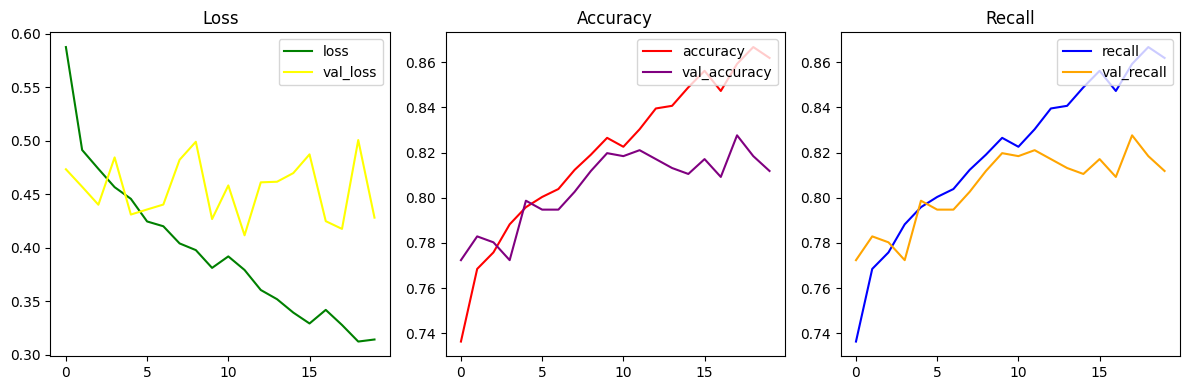

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_vgg16_2_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_vgg16_2_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_vgg16_2_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_vgg16_2_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_vgg16_2_res.history['recall'], color='blue', label='recall')
axes[2].plot(calc_vgg16_2_res.history['val_recall'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_vgg16_2.save(ROOT + '/models/calc_vgg16_2.keras')
# calc_vgg16_2 = keras.models.load_model(ROOT + '/models/calc_vgg16_2.keras')

In [ ]:
hist_df = pd.DataFrame(calc_vgg16_2_res.history)
hist_df.to_csv(ROOT + '/history/calc_vgg16_2_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_vgg16_2.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

8/8 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - binary_accuracy: 0.6785 - loss: 1.4536 - recall: 0.6785
Loss:  1.1958274841308594
Accuracy:  0.7053763270378113
Recall:  0.7053763270378113


**Mass VGG16 Model 2**

In [ ]:
# I borrowed the model architecture from here: https://github.com/hema2107/VGG16-for-Brain-MRI-Images
def preprocess(image, label):
  image=tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (image_height, image_width, 3))

for layer in vgg16.layers:
    layer.trainable = False

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

output = lw(vgg16, 2)
mass_vgg16_2 = Model(inputs = vgg16.input, outputs = output)
mass_vgg16_2.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
mass_vgg16_2.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
mass_vgg16_2_res = mass_vgg16_2.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 532s 4s/step - binary_accuracy: 0.5555 - loss: 0.9421 - recall: 0.5555 - val_binary_accuracy: 0.6113 - val_loss: 0.6706 - val_recall: 0.6113
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 40s 339ms/step - binary_accuracy: 0.6013 - loss: 0.6622 - recall: 0.6013 - val_binary_accuracy: 0.6185 - val_loss: 0.6482 - val_recall: 0.6185
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 39s 328ms/step - binary_accuracy: 0.6085 - loss: 0.6542 - recall: 0.6085 - val_binary_accuracy: 0.6270 - val_loss: 0.6460 - val_recall: 0.6270
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 40s 336ms/step - binary_accuracy: 0.6297 - loss: 0.6377 - recall: 0.6297 - val_binary_accuracy: 0.6149 - val_loss: 0.6504 - val_recall: 0.6149
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 39s 331ms/step - binary_accuracy: 0.6341 - loss: 0.6304 - recall: 0.6341 - val_binary_accuracy: 0.6414 - val_loss: 0.6350 - val_recall: 0.6414
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 39s 331ms/step - binary_accuracy: 0.6402 - loss

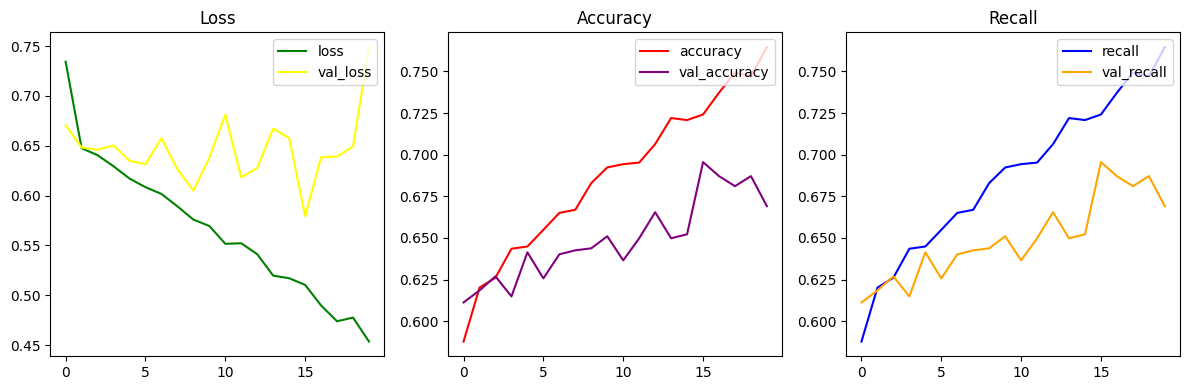

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_vgg16_2_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_vgg16_2_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_vgg16_2_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_vgg16_2_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_vgg16_2_res.history['recall'], color='blue', label='recall')
axes[2].plot(mass_vgg16_2_res.history['val_recall'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_vgg16_2.save(ROOT + '/models/mass_vgg16_2.keras')
# mass_vgg16_2 = keras.models.load_model(ROOT + '/models/mass_vgg16_2.keras')

In [ ]:
hist_df = pd.DataFrame(mass_vgg16_2_res.history)
hist_df.to_csv(ROOT + '/history/mass_vgg16_2_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_vgg16_2.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

8/8 ━━━━━━━━━━━━━━━━━━━━ 67s 9s/step - binary_accuracy: 0.5598 - loss: 1.1092 - recall: 0.5598
Loss:  1.2224152088165283
Accuracy:  0.537401556968689
Recall:  0.537401556968689


**Calcification VGG16 Model 3**

In [ ]:
# I borrowed the model architecture from here: https://github.com/hema2107/VGG16-for-Brain-MRI-Images
def preprocess(image, label):
  image=tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (image_height, image_width, 3))

for layer in vgg16.layers:
    layer.trainable = False

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Flatten()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dropout(0.1)(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

output = lw(vgg16, 2)
calc_vgg16_3 = Model(inputs = vgg16.input, outputs = output)
calc_vgg16_3.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
calc_vgg16_3.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
calc_vgg16_3_res = calc_vgg16_3.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 650s 2s/step - binary_accuracy: 0.6838 - loss: 0.7632 - recall_2: 0.6838 - val_binary_accuracy: 0.7337 - val_loss: 0.5088 - val_recall_2: 0.7337
Epoch 2/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 102s 334ms/step - binary_accuracy: 0.7345 - loss: 0.5153 - recall_2: 0.7345 - val_binary_accuracy: 0.7397 - val_loss: 0.4913 - val_recall_2: 0.7397
Epoch 3/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 102s 333ms/step - binary_accuracy: 0.7449 - loss: 0.4901 - recall_2: 0.7449 - val_binary_accuracy: 0.7499 - val_loss: 0.4861 - val_recall_2: 0.7499
Epoch 4/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 102s 334ms/step - binary_accuracy: 0.7572 - loss: 0.4744 - recall_2: 0.7572 - val_binary_accuracy: 0.7393 - val_loss: 0.4830 - val_recall_2: 0.7393
Epoch 5/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 102s 334ms/step - binary_accuracy: 0.7670 - loss: 0.4623 - recall_2: 0.7670 - val_binary_accuracy: 0.7610 - val_loss: 0.4617 - val_recall_2: 0.7610
Epoch 6/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 102s 333ms/step - binar

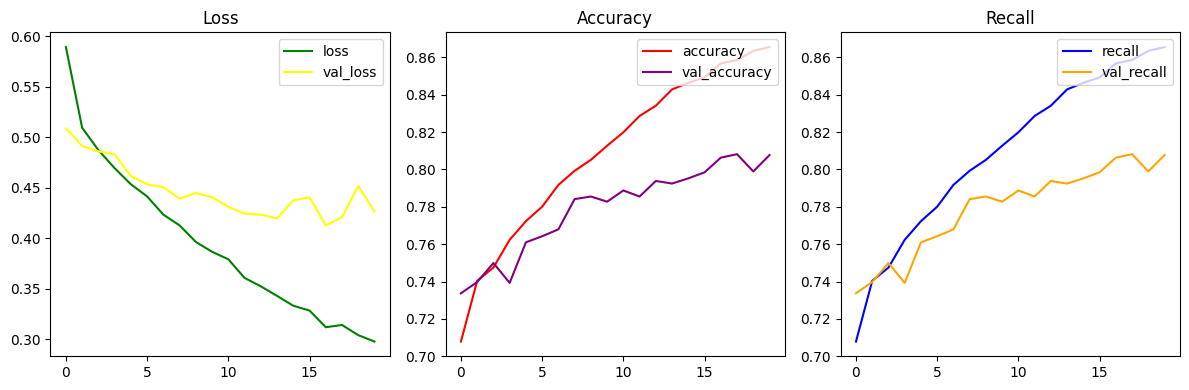

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_vgg16_3_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_vgg16_3_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_vgg16_3_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_vgg16_3_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_vgg16_3_res.history['recall_2'], color='blue', label='recall')
axes[2].plot(calc_vgg16_3_res.history['val_recall_2'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_vgg16_3.save(ROOT + '/models/calc_vgg16_3.keras')
# calc_vgg16_3 = keras.models.load_model(ROOT + '/models/calc_vgg16_3.keras')

NameError: name 'calc_vgg16_3' is not defined

In [ ]:
hist_df = pd.DataFrame(calc_vgg16_3_res.history)
hist_df.to_csv(ROOT + '/history/calc_vgg16_3_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_vgg16_3.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

73/73 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - binary_accuracy: 0.7836 - loss: 1.7757 - recall_2: 0.7836
Loss:  1.8538665771484375
Accuracy:  0.7817083597183228
Recall:  0.7817083597183228


**Mass VGG16 Model 3**

In [ ]:
# I borrowed the model architecture from here: https://github.com/hema2107/VGG16-for-Brain-MRI-Images
def preprocess(image, label):
  image=tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (image_height, image_width, 3))

for layer in vgg16.layers:
    layer.trainable = False

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Flatten()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

output = lw(vgg16, 2)
mass_vgg16_3 = Model(inputs = vgg16.input, outputs = output)
mass_vgg16_3.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
mass_vgg16_3.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
mass_vgg16_3_res = mass_vgg16_3.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 1258s 5s/step - binary_accuracy: 0.5857 - loss: 0.8217 - recall: 0.5857 - val_binary_accuracy: 0.6520 - val_loss: 0.6119 - val_recall: 0.6520
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 85s 327ms/step - binary_accuracy: 0.6624 - loss: 0.5988 - recall: 0.6624 - val_binary_accuracy: 0.6640 - val_loss: 0.6129 - val_recall: 0.6640
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 86s 330ms/step - binary_accuracy: 0.6902 - loss: 0.5694 - recall: 0.6902 - val_binary_accuracy: 0.6743 - val_loss: 0.5981 - val_recall: 0.6743
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 86s 330ms/step - binary_accuracy: 0.7057 - loss: 0.5398 - recall: 0.7057 - val_binary_accuracy: 0.6580 - val_loss: 0.6051 - val_recall: 0.6580
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 86s 330ms/step - binary_accuracy: 0.7218 - loss: 0.5124 - recall: 0.7218 - val_binary_accuracy: 0.6808 - val_loss: 0.5753 - val_recall: 0.6808
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 86s 331ms/step - binary_accuracy: 0.7327 - los

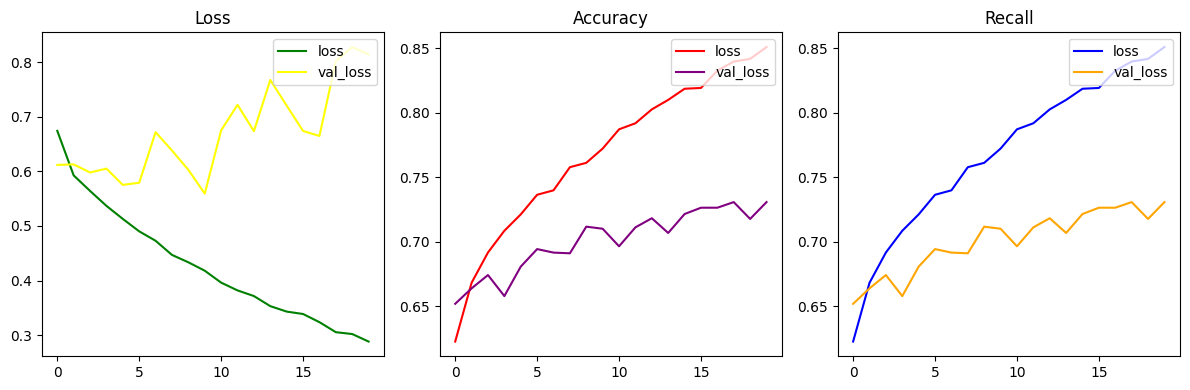

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_vgg16_3_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_vgg16_3_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_vgg16_3_res.history['binary_accuracy'], color='red', label='loss')
axes[1].plot(mass_vgg16_3_res.history['val_binary_accuracy'], color='purple', label='val_loss')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_vgg16_3_res.history['recall'], color='blue', label='loss')
axes[2].plot(mass_vgg16_3_res.history['val_recall'], color='orange', label='val_loss')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_vgg16_3.save(ROOT + '/models/mass_vgg16_3.keras')
# mass_vgg16_3 = keras.models.load_model(ROOT + '/models/mass_vgg16_3.keras')

In [ ]:
hist_df = pd.DataFrame(mass_vgg16_3_res.history)
hist_df.to_csv(ROOT + '/history/mass_vgg16_3_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_vgg16_3.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

18/18 ━━━━━━━━━━━━━━━━━━━━ 121s 7s/step - binary_accuracy: 0.6009 - loss: 4.1826 - recall: 0.6009
Loss:  3.986417770385742
Accuracy:  0.5934744477272034
Recall:  0.5934744477272034


**Calcification VGG16 Model 4**

In [15]:
# I borrowed the model architecture from here: https://github.com/hema2107/VGG16-for-Brain-MRI-Images
def preprocess(image, label):
  image=tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (image_height, image_width, 3))

for layer in vgg16.layers:
    layer.trainable = False

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Flatten()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

output = lw(vgg16, 2)
calc_vgg16_4 = Model(inputs = vgg16.input, outputs = output)
calc_vgg16_4.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
calc_vgg16_4.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
calc_vgg16_4_res = calc_vgg16_4.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 311ms/step - binary_accuracy: 0.6836 - loss: 1.7512 - recall_2: 0.6836 - val_binary_accuracy: 0.7559 - val_loss: 0.5429 - val_recall_2: 0.7559
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 293ms/step - binary_accuracy: 0.7682 - loss: 0.4988 - recall_2: 0.7682 - val_binary_accuracy: 0.7546 - val_loss: 0.4957 - val_recall_2: 0.7546
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 35s 296ms/step - binary_accuracy: 0.7811 - loss: 0.4714 - recall_2: 0.7811 - val_binary_accuracy: 0.7509 - val_loss: 0.5106 - val_recall_2: 0.7509
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 35s 300ms/step - binary_accuracy: 0.7869 - loss: 0.4532 - recall_2: 0.7869 - val_binary_accuracy: 0.7546 - val_loss: 0.5462 - val_recall_2: 0.7546
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 36s 305ms/step - binary_accuracy: 0.7950 - loss: 0.4475 - recall_2: 0.7950 - val_binary_accuracy: 0.7374 - val_loss: 0.5100 - val_recall_2: 0.7374
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 36s 306ms/step - binary_a

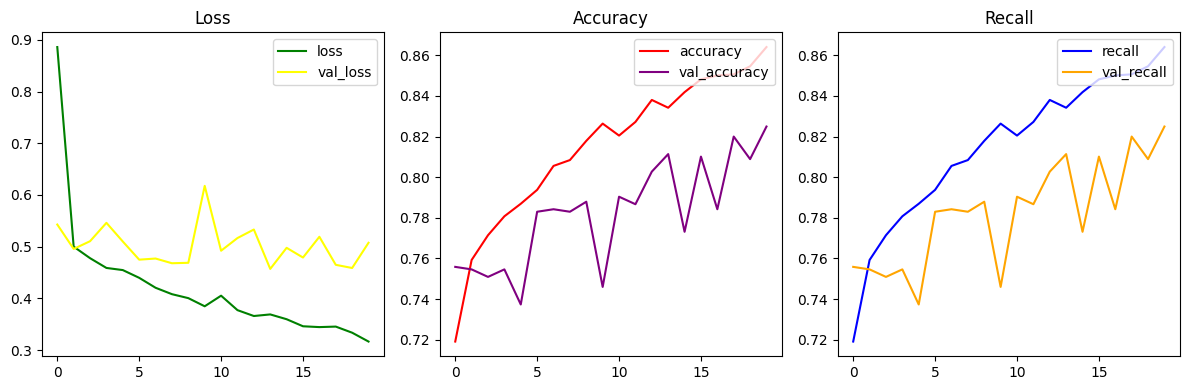

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_vgg16_4_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_vgg16_4_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_vgg16_4_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_vgg16_4_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_vgg16_4_res.history['recall_2'], color='blue', label='recall')
axes[2].plot(calc_vgg16_4_res.history['val_recall_2'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_vgg16_4.save(ROOT + '/models/calc_vgg16_4.keras')
# calc_vgg16_4 = keras.models.load_model(ROOT + '/models/calc_vgg16_4.keras')

NameError: name 'calc_vgg16_4' is not defined

In [ ]:
hist_df = pd.DataFrame(calc_vgg16_4_res.history)
hist_df.to_csv(ROOT + '/history/calc_vgg16_4_history.csv')

In [11]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_vgg16_4.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - binary_accuracy: 0.7437 - loss: 0.6449 - recall: 0.7437
Loss:  0.6450320482254028
Accuracy:  0.7442455291748047
Recall:  0.7442455291748047


**Mass VGG16 Model 4**

In [ ]:
# I borrowed the model architecture from here: https://github.com/hema2107/VGG16-for-Brain-MRI-Images
def preprocess(image, label):
  image=tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (image_height, image_width, 3))

for layer in vgg16.layers:
    layer.trainable = False

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

output = lw(vgg16, 2)
mass_vgg16_4 = Model(inputs = vgg16.input, outputs = output)
mass_vgg16_4.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
mass_vgg16_4.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
mass_vgg16_4_res = mass_vgg16_4.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - binary_accuracy: 0.5524 - loss: 0.9147 - recall: 0.5524 - val_binary_accuracy: 0.6063 - val_loss: 0.6592 - val_recall: 0.6063
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 44s 334ms/step - binary_accuracy: 0.6043 - loss: 0.6584 - recall: 0.6043 - val_binary_accuracy: 0.6345 - val_loss: 0.6530 - val_recall: 0.6345
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 320ms/step - binary_accuracy: 0.6160 - loss: 0.6498 - recall: 0.6160 - val_binary_accuracy: 0.6247 - val_loss: 0.6529 - val_recall: 0.6247
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 43s 327ms/step - binary_accuracy: 0.6218 - loss: 0.6357 - recall: 0.6218 - val_binary_accuracy: 0.6204 - val_loss: 0.6428 - val_recall: 0.6204
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 324ms/step - binary_accuracy: 0.6364 - loss: 0.6248 - recall: 0.6364 - val_binary_accuracy: 0.6171 - val_loss: 0.6508 - val_recall: 0.6171
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 325ms/step - binary_accuracy: 0.6365 - loss

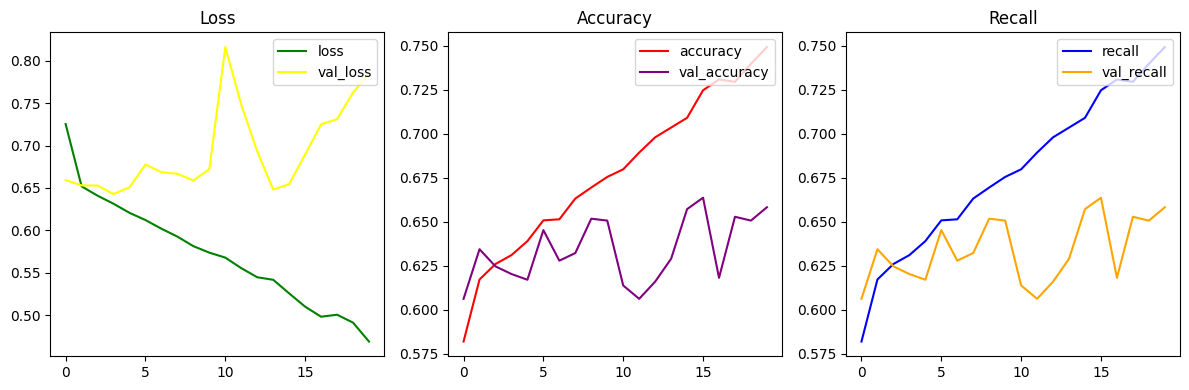

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_vgg16_4_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_vgg16_4_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_vgg16_4_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_vgg16_4_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_vgg16_4_res.history['recall'], color='blue', label='recall')
axes[2].plot(mass_vgg16_4_res.history['val_recall'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_vgg16_4.save(ROOT + '/models/mass_vgg16_4.keras')
# mass_vgg16_4 = keras.models.load_model(ROOT + '/models/mass_vgg16_4.keras')

In [ ]:
hist_df = pd.DataFrame(mass_vgg16_4_res.history)
hist_df.to_csv(ROOT + '/history/mass_vgg16_4_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_vgg16_4.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 50s 9s/step - binary_accuracy: 0.5531 - loss: 1.3569 - recall: 0.5531
Loss:  1.4494925737380981
Accuracy:  0.5502645373344421
Recall:  0.5502645373344421


**Calcification VGG16 Model 5**

In [ ]:
# I borrowed the model architecture from here: https://github.com/hema2107/VGG16-for-Brain-MRI-Images
def preprocess(image, label):
  image=tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (image_height, image_width, 3))

for layer in vgg16.layers:
    layer.trainable = False

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

output = lw(vgg16, 2)
calc_vgg16_5 = Model(inputs = vgg16.input, outputs = output)
calc_vgg16_5.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
calc_vgg16_5.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
calc_vgg16_5_res = calc_vgg16_5.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - binary_accuracy: 0.6633 - loss: 0.7901 - recall: 0.6633 - val_binary_accuracy: 0.7346 - val_loss: 0.4766 - val_recall: 0.7346
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 312ms/step - binary_accuracy: 0.7404 - loss: 0.4721 - recall: 0.7404 - val_binary_accuracy: 0.7756 - val_loss: 0.4564 - val_recall: 0.7756
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 315ms/step - binary_accuracy: 0.7723 - loss: 0.4225 - recall: 0.7723 - val_binary_accuracy: 0.7778 - val_loss: 0.4475 - val_recall: 0.7778
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 317ms/step - binary_accuracy: 0.8061 - loss: 0.3768 - recall: 0.8061 - val_binary_accuracy: 0.7648 - val_loss: 0.4551 - val_recall: 0.7648
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 324ms/step - binary_accuracy: 0.8326 - loss: 0.3266 - recall: 0.8326 - val_binary_accuracy: 0.8026 - val_loss: 0.4708 - val_recall: 0.8026
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 323ms/step - binary_accuracy: 0.8657 - loss

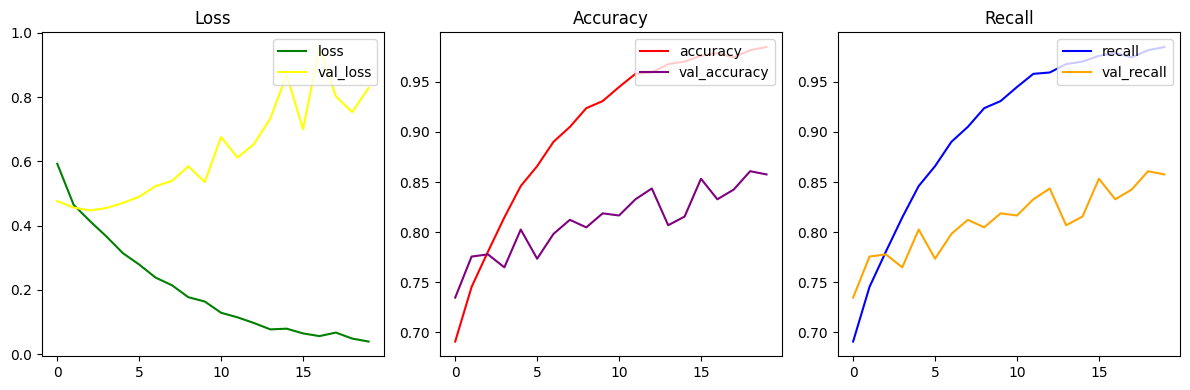

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_vgg16_5_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_vgg16_5_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_vgg16_5_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_vgg16_5_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_vgg16_5_res.history['recall'], color='blue', label='recall')
axes[2].plot(calc_vgg16_5_res.history['val_recall'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_vgg16_5.save(ROOT + '/models/calc_vgg16_5.keras')
# calc_vgg16_5 = keras.models.load_model(ROOT + '/models/calc_vgg16_5.keras')

In [ ]:
hist_df = pd.DataFrame(calc_vgg16_5_res.history)
hist_df.to_csv(ROOT + '/history/calc_vgg16_5_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_vgg16_5.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - binary_accuracy: 0.6340 - loss: 2.6418 - recall: 0.6340
Loss:  3.0270814895629883
Accuracy:  0.6165643930435181
Recall:  0.6165643930435181


**Mass VGG16 Model 5**

In [ ]:
# I borrowed the model architecture from here: https://github.com/hema2107/VGG16-for-Brain-MRI-Images
def preprocess(image, label):
  image=tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (image_height, image_width, 3))

for layer in vgg16.layers:
    layer.trainable = False

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

output = lw(vgg16, 2)
mass_vgg16_5 = Model(inputs = vgg16.input, outputs = output)
mass_vgg16_5.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
mass_vgg16_5.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
mass_vgg16_5_res = mass_vgg16_5.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - binary_accuracy: 0.5943 - loss: 0.9838 - recall_1: 0.5943 - val_binary_accuracy: 0.6759 - val_loss: 0.5917 - val_recall_1: 0.6759
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 37s 326ms/step - binary_accuracy: 0.7171 - loss: 0.5506 - recall_1: 0.7171 - val_binary_accuracy: 0.7063 - val_loss: 0.5548 - val_recall_1: 0.7063
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 37s 324ms/step - binary_accuracy: 0.7524 - loss: 0.4991 - recall_1: 0.7524 - val_binary_accuracy: 0.7380 - val_loss: 0.5099 - val_recall_1: 0.7380
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 36s 323ms/step - binary_accuracy: 0.7869 - loss: 0.4382 - recall_1: 0.7869 - val_binary_accuracy: 0.7519 - val_loss: 0.4951 - val_recall_1: 0.7519
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 36s 323ms/step - binary_accuracy: 0.8109 - loss: 0.3864 - recall_1: 0.8109 - val_binary_accuracy: 0.7380 - val_loss: 0.6214 - val_recall_1: 0.7380
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 36s 323ms/step - binary_acc

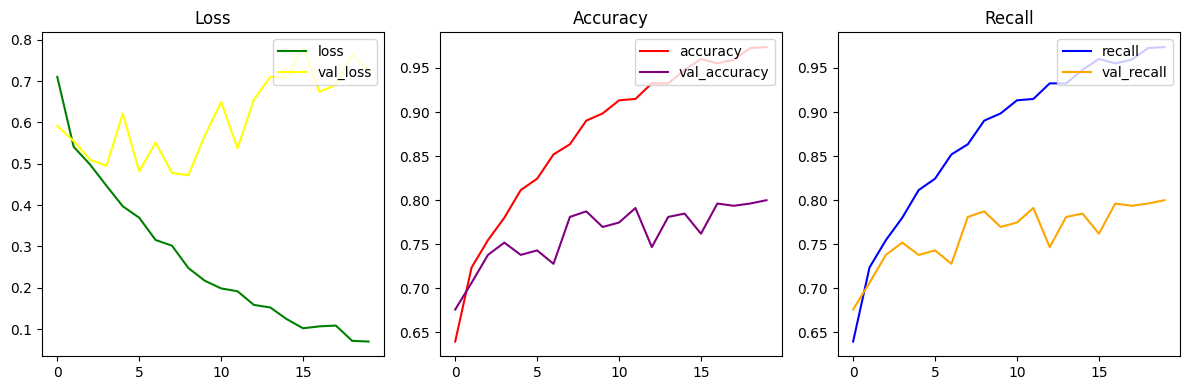

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_vgg16_5_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_vgg16_5_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_vgg16_5_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_vgg16_5_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_vgg16_5_res.history['recall_1'], color='blue', label='recall')
axes[2].plot(mass_vgg16_5_res.history['val_recall_1'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_vgg16_5.save(ROOT + '/models/mass_vgg16_5.keras')
# mass_vgg16_5 = keras.models.load_model(ROOT + '/models/mass_vgg16_5.keras')

In [ ]:
hist_df = pd.DataFrame(mass_vgg16_5_res.history)
hist_df.to_csv(ROOT + '/history/mass_vgg16_5_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_vgg16_5.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - binary_accuracy: 0.6361 - loss: 1.9962 - recall_1: 0.6361
Loss:  2.359877586364746
Accuracy:  0.6005290746688843
Recall:  0.6005290746688843


**Calcification VGG16 Model 6**

In [ ]:
# I borrowed the model architecture from here: https://github.com/hema2107/VGG16-for-Brain-MRI-Images
def preprocess(image, label):
  image=tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (image_height, image_width, 3))

for layer in vgg16.layers:
    layer.trainable = False

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

output = lw(vgg16, 2)
calc_vgg16_6 = Model(inputs = vgg16.input, outputs = output)
calc_vgg16_6.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
calc_vgg16_6.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
calc_vgg16_6_res = calc_vgg16_6.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 95s 531ms/step - binary_accuracy: 0.6679 - loss: 0.9368 - recall_9: 0.6679 - val_binary_accuracy: 0.7098 - val_loss: 0.5228 - val_recall_9: 0.7098
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - binary_accuracy: 0.7463 - loss: 0.4719 - recall_9: 0.7463 - val_binary_accuracy: 0.7659 - val_loss: 0.4440 - val_recall_9: 0.7659
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 45s 341ms/step - binary_accuracy: 0.7741 - loss: 0.4178 - recall_9: 0.7741 - val_binary_accuracy: 0.7594 - val_loss: 0.4505 - val_recall_9: 0.7594
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 46s 345ms/step - binary_accuracy: 0.8100 - loss: 0.3698 - recall_9: 0.8100 - val_binary_accuracy: 0.7627 - val_loss: 0.4617 - val_recall_9: 0.7627
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 46s 348ms/step - binary_accuracy: 0.8300 - loss: 0.3378 - recall_9: 0.8300 - val_binary_accuracy: 0.7659 - val_loss: 0.4557 - val_recall_9: 0.7659
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 46s 350ms/step - binary_a

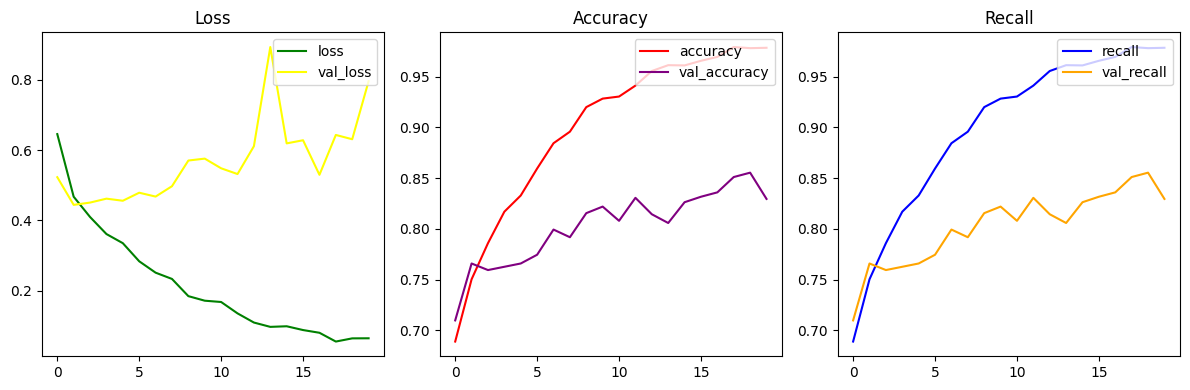

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_vgg16_6_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_vgg16_6_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_vgg16_6_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_vgg16_6_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_vgg16_6_res.history['recall_9'], color='blue', label='recall')
axes[2].plot(calc_vgg16_6_res.history['val_recall_9'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_vgg16_6.save(ROOT + '/models/calc_vgg16_6.keras')
# calc_vgg16_6 = keras.models.load_model(ROOT + '/models/calc_vgg16_6.keras')

In [ ]:
hist_df = pd.DataFrame(calc_vgg16_6_res.history)
hist_df.to_csv(ROOT + '/history/calc_vgg16_6_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_vgg16_6.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - binary_accuracy: 0.6338 - loss: 2.1427 - recall_9: 0.6338
Loss:  2.145749807357788
Accuracy:  0.6411042809486389
Recall:  0.6411042809486389


**Mass VGG16 Model 6**

In [ ]:
# I borrowed the model architecture from here: https://github.com/hema2107/VGG16-for-Brain-MRI-Images
def preprocess(image, label):
  image=tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (image_height, image_width, 3))

for layer in vgg16.layers:
    layer.trainable = False

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

output = lw(vgg16, 2)
mass_vgg16_6 = Model(inputs = vgg16.input, outputs = output)
mass_vgg16_6.summary()

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
mass_vgg16_6.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
mass_vgg16_6_res = mass_vgg16_6.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 60s 500ms/step - binary_accuracy: 0.5115 - loss: 1.1347 - recall_10: 0.5115 - val_binary_accuracy: 0.5291 - val_loss: 0.6915 - val_recall_10: 0.5291
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 38s 331ms/step - binary_accuracy: 0.4954 - loss: 0.7052 - recall_10: 0.4954 - val_binary_accuracy: 0.5291 - val_loss: 0.6941 - val_recall_10: 0.5291
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 38s 332ms/step - binary_accuracy: 0.5040 - loss: 0.6963 - recall_10: 0.5040 - val_binary_accuracy: 0.5291 - val_loss: 0.6915 - val_recall_10: 0.5291
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 38s 335ms/step - binary_accuracy: 0.5196 - loss: 0.6936 - recall_10: 0.5196 - val_binary_accuracy: 0.5291 - val_loss: 0.6929 - val_recall_10: 0.5291
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 38s 337ms/step - binary_accuracy: 0.5004 - loss: 0.6942 - recall_10: 0.5004 - val_binary_accuracy: 0.5291 - val_loss: 0.6917 - val_recall_10: 0.5291
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 38s 338ms/step 

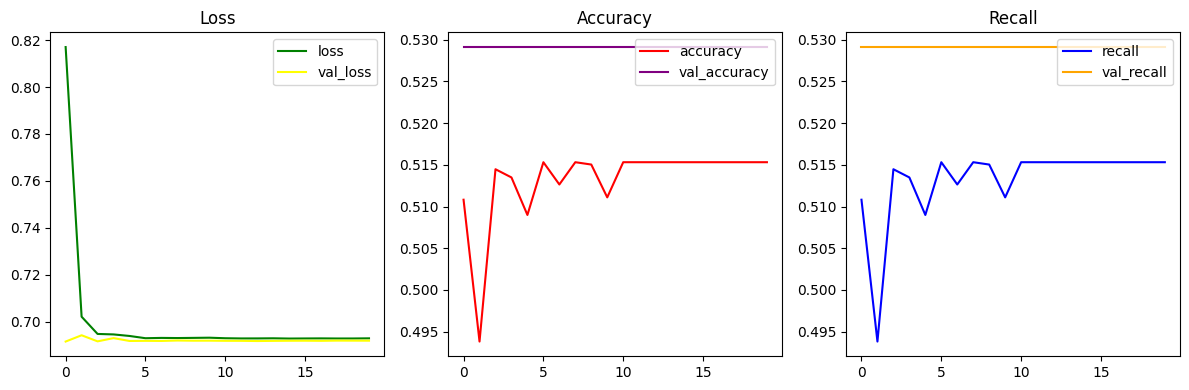

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_vgg16_6_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_vgg16_6_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_vgg16_6_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_vgg16_6_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_vgg16_6_res.history['recall_10'], color='blue', label='recall')
axes[2].plot(mass_vgg16_6_res.history['val_recall_10'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_vgg16_6.save(ROOT + '/models/mass_vgg16_6.keras')
# mass_vgg16_6 = keras.models.load_model(ROOT + '/models/mass_vgg16_6.keras')

In [ ]:
hist_df = pd.DataFrame(mass_vgg16_6_res.history)
hist_df.to_csv(ROOT + '/history/mass_vgg16_6_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_vgg16_6.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - binary_accuracy: 0.6364 - loss: 0.6852 - recall_10: 0.6364
Loss:  0.6867794990539551
Accuracy:  0.6111111044883728
Recall:  0.6111111044883728


**Combined VGG16 Model**

In [ ]:
# I borrowed the model architecture from here: https://github.com/hema2107/VGG16-for-Brain-MRI-Images
def preprocess(image, label):
  image=tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

combined_train = combined_train.map(preprocess)
combined_val = combined_val.map(preprocess)
combined_test = combined_test.map(preprocess)

vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (image_height, image_width, 3))

for layer in vgg16.layers:
    layer.trainable = False

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

output = lw(vgg16, 2)
combined_vgg16_1 = Model(inputs = vgg16.input, outputs = output)
combined_vgg16_1.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
combined_vgg16_1.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
combined_vgg16_1_res = combined_vgg16_1.fit(combined_train, epochs=20, verbose=1, validation_data=combined_val)

Epoch 1/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 233s 407ms/step - binary_accuracy: 0.6395 - loss: 0.7000 - recall_11: 0.6395 - val_binary_accuracy: 0.6984 - val_loss: 0.5627 - val_recall_11: 0.6984
Epoch 2/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 193s 343ms/step - binary_accuracy: 0.6947 - loss: 0.5594 - recall_11: 0.6947 - val_binary_accuracy: 0.7061 - val_loss: 0.5543 - val_recall_11: 0.7061
Epoch 3/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 194s 343ms/step - binary_accuracy: 0.7155 - loss: 0.5327 - recall_11: 0.7155 - val_binary_accuracy: 0.7021 - val_loss: 0.5609 - val_recall_11: 0.7021
Epoch 4/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 194s 343ms/step - binary_accuracy: 0.7313 - loss: 0.5087 - recall_11: 0.7313 - val_binary_accuracy: 0.7238 - val_loss: 0.5232 - val_recall_11: 0.7238
Epoch 5/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 194s 343ms/step - binary_accuracy: 0.7446 - loss: 0.4857 - recall_11: 0.7446 - val_binary_accuracy: 0.6986 - val_loss: 0.5759 - val_recall_11: 0.6986
Epoch 6/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 193s 342ms

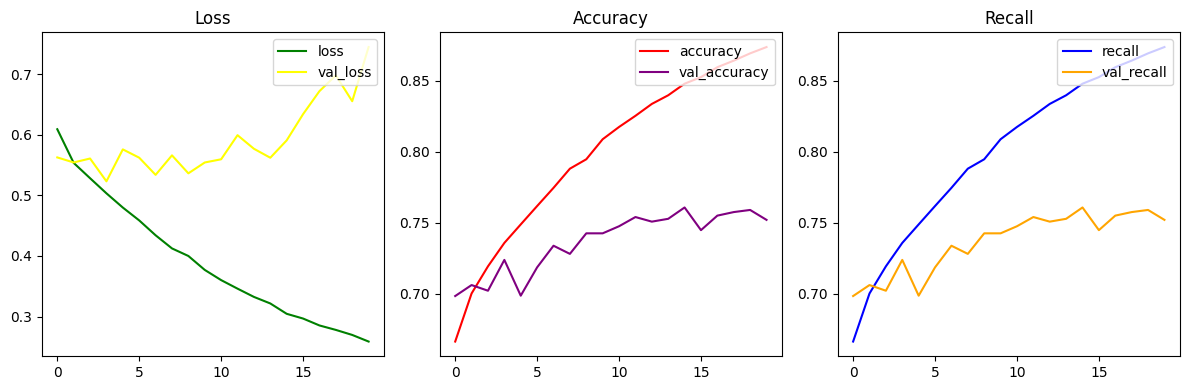

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(combined_vgg16_1_res.history['loss'], color='green', label='loss')
axes[0].plot(combined_vgg16_1_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(combined_vgg16_1_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(combined_vgg16_1_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(combined_vgg16_1_res.history['recall_11'], color='blue', label='recall')
axes[2].plot(combined_vgg16_1_res.history['val_recall_11'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
combined_vgg16_1.save(ROOT + '/models/combined_vgg16_1.keras')
# combined_vgg16_1 = keras.models.load_model(ROOT + '/models/combined_vgg16_1.keras')

In [ ]:
hist_df = pd.DataFrame(combined_vgg16_1_res.history)
hist_df.to_csv(ROOT + '/history/combined_vgg16_1_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
loss, accuracy, recall = combined_vgg16_1.evaluate(combined_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)
print("Recall: ", recall)

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 315ms/step - binary_accuracy: 0.5798 - loss: 2.3363 - recall_11: 0.5798
Loss:  2.112813949584961
Accuracy:  0.5836396813392639
Recall:  0.5836396813392639


# **DenseNet**

**Calcification DenseNet Model 1**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/shawon10/plant-disease-classification-using-densenet121
def preprocess(image, label):
  image=tf.keras.applications.densenet.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

densenet = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))
input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)
x = densenet(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(2,activation = 'softmax')(x)
calc_densenet_1 = Model(input,output)
calc_densenet_1.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,823,062 (71.80 MB)

 Trainable params: 18,589,654 (70.91 MB)

 Non-trainable params: 233,408 (911.75 KB)

In [ ]:
calc_densenet_1.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_densenet_1_res = calc_densenet_1.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 3979s 8s/step - binary_accuracy: 0.5923 - loss: 1.0263 - recall: 0.5923 - val_binary_accuracy: 0.7316 - val_loss: 0.5377 - val_recall: 0.7316
Epoch 2/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 413s 904ms/step - binary_accuracy: 0.6725 - loss: 0.6846 - recall: 0.6725 - val_binary_accuracy: 0.7387 - val_loss: 0.4942 - val_recall: 0.7387
Epoch 3/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 412s 902ms/step - binary_accuracy: 0.7166 - loss: 0.5577 - recall: 0.7166 - val_binary_accuracy: 0.7541 - val_loss: 0.4783 - val_recall: 0.7541
Epoch 4/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 413s 903ms/step - binary_accuracy: 0.7638 - loss: 0.4725 - recall: 0.7638 - val_binary_accuracy: 0.7821 - val_loss: 0.4391 - val_recall: 0.7821
Epoch 5/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 412s 901ms/step - binary_accuracy: 0.8016 - loss: 0.4195 - recall: 0.8016 - val_binary_accuracy: 0.7501 - val_loss: 0.7776 - val_recall: 0.7501
Epoch 6/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 412s 901ms/step - binary_accuracy: 0.8182 

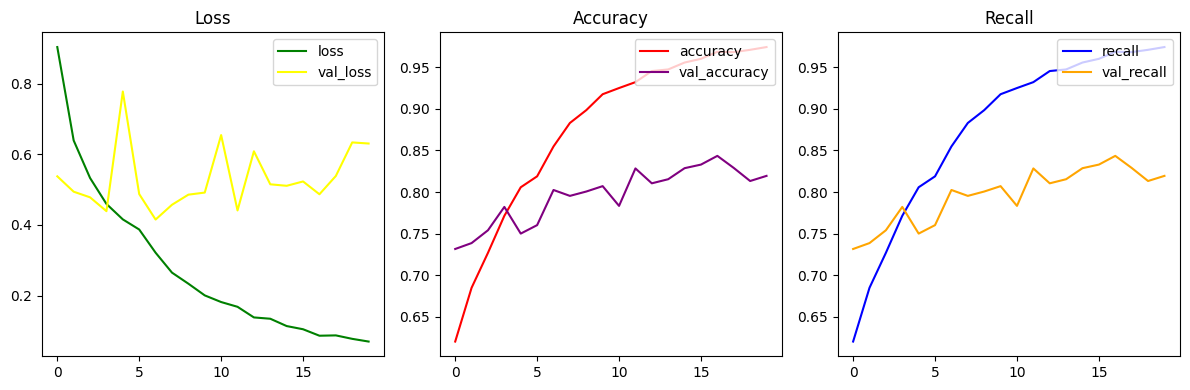

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_densenet_1_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_densenet_1_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_densenet_1_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_densenet_1_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_densenet_1_res.history['recall'], color='blue', label='recall')
axes[2].plot(calc_densenet_1_res.history['val_recall'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_densenet_1.save(ROOT + '/models/calc_densenet_1.keras')
# calc_densenet_1 = keras.models.load_model(ROOT + '/models/calc_densenet_1.keras')

In [ ]:
hist_df = pd.DataFrame(calc_densenet_1_res.history)
hist_df.to_csv(ROOT + '/history/calc_densenet_1_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_densenet_1.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 65s 12s/step - binary_accuracy: 0.6813 - loss: 1.1472 - recall: 0.6813
Loss:  1.1800808906555176
Accuracy:  0.6781914830207825
Recall:  0.6781914830207825


**Mass DenseNet Model 1**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/shawon10/plant-disease-classification-using-densenet121
def preprocess(image, label):
  image=tf.keras.applications.densenet.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

densenet = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))
input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)
x = densenet(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(2,activation = 'softmax')(x)
mass_densenet_1 = Model(input,output)
mass_densenet_1.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,823,062 (71.80 MB)

 Trainable params: 18,589,654 (70.91 MB)

 Non-trainable params: 233,408 (911.75 KB)

In [ ]:
mass_densenet_1.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_densenet_1_res = mass_densenet_1.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1182s 2s/step - binary_accuracy: 0.5526 - loss: 1.1279 - recall: 0.5526 - val_binary_accuracy: 0.6549 - val_loss: 0.6866 - val_recall: 0.6549
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 339s 868ms/step - binary_accuracy: 0.6153 - loss: 0.8645 - recall: 0.6153 - val_binary_accuracy: 0.6762 - val_loss: 0.7364 - val_recall: 0.6762
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 339s 868ms/step - binary_accuracy: 0.6482 - loss: 0.7210 - recall: 0.6482 - val_binary_accuracy: 0.6946 - val_loss: 0.6227 - val_recall: 0.6946
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 339s 868ms/step - binary_accuracy: 0.6865 - loss: 0.6096 - recall: 0.6865 - val_binary_accuracy: 0.7199 - val_loss: 0.5476 - val_recall: 0.7199
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 339s 869ms/step - binary_accuracy: 0.7299 - loss: 0.5172 - recall: 0.7299 - val_binary_accuracy: 0.7308 - val_loss: 0.5432 - val_recall: 0.7308
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 339s 869ms/step - binary_accuracy: 0.7682 

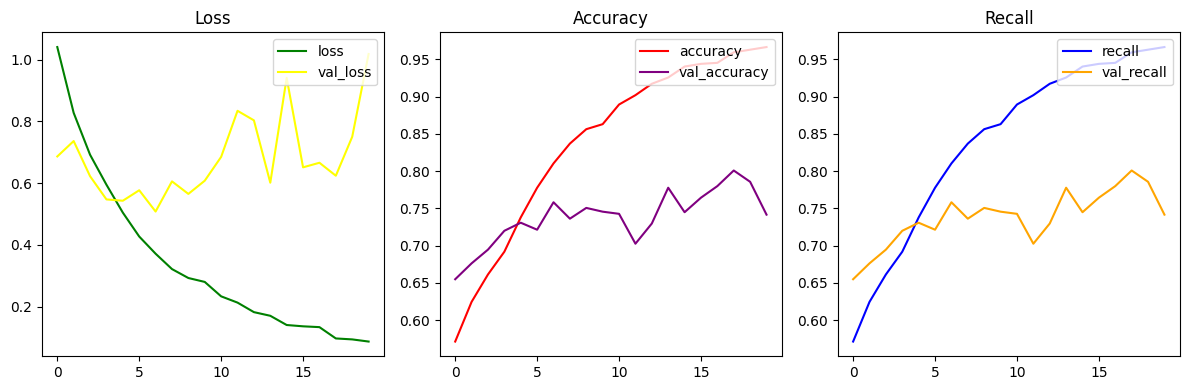

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_densenet_1_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_densenet_1_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_densenet_1_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_densenet_1_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_densenet_1_res.history['recall'], color='blue', label='recall')
axes[2].plot(mass_densenet_1_res.history['val_recall'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_densenet_1.save(ROOT + '/models/mass_densenet_1.keras')
# mass_densenet_1 = keras.models.load_model(ROOT + '/models/mass_densenet_1.keras')

In [ ]:
hist_df = pd.DataFrame(mass_densenet_1_res.history)
hist_df.to_csv(ROOT + '/history/mass_densenet_1_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_densenet_1.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - binary_accuracy: 0.6359 - loss: 1.6961 - recall: 0.6359
Loss:  1.7596116065979004
Accuracy:  0.6410934925079346
Recall:  0.6410934925079346


**Calcification DenseNet Model 2**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/shawon10/plant-disease-classification-using-densenet121
def preprocess(image, label):
  image=tf.keras.applications.densenet.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

densenet = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))
input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)
x = densenet(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(2,activation = 'softmax')(x)
calc_densenet_2 = Model(input,output)
calc_densenet_2.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,823,062 (71.80 MB)

 Trainable params: 18,589,654 (70.91 MB)

 Non-trainable params: 233,408 (911.75 KB)

In [ ]:
calc_densenet_2.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_densenet_2_res = calc_densenet_2.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1038s 5s/step - binary_accuracy: 0.6139 - loss: 1.0243 - recall_5: 0.6139 - val_binary_accuracy: 0.7250 - val_loss: 0.5764 - val_recall_5: 0.7250
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 99s 919ms/step - binary_accuracy: 0.6679 - loss: 0.8169 - recall_5: 0.6679 - val_binary_accuracy: 0.7526 - val_loss: 0.5123 - val_recall_5: 0.7526
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 99s 917ms/step - binary_accuracy: 0.6982 - loss: 0.7098 - recall_5: 0.6982 - val_binary_accuracy: 0.7368 - val_loss: 0.5767 - val_recall_5: 0.7368
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 99s 917ms/step - binary_accuracy: 0.7098 - loss: 0.6844 - recall_5: 0.7098 - val_binary_accuracy: 0.7461 - val_loss: 0.5215 - val_recall_5: 0.7461
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 99s 918ms/step - binary_accuracy: 0.7280 - loss: 0.6072 - recall_5: 0.7280 - val_binary_accuracy: 0.7382 - val_loss: 0.7507 - val_recall_5: 0.7382
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 99s 917ms/step - binary_ac

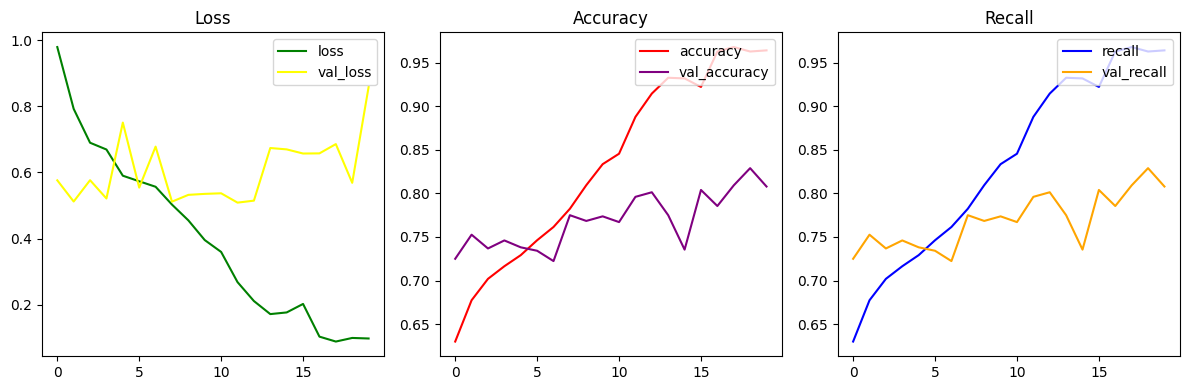

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_densenet_2_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_densenet_2_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_densenet_2_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_densenet_2_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_densenet_2_res.history['recall_5'], color='blue', label='recall')
axes[2].plot(calc_densenet_2_res.history['val_recall_5'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_densenet_2.save(ROOT + '/models/calc_densenet_2.keras')
# calc_densenet_2 = keras.models.load_model(ROOT + '/models/calc_densenet_2.keras')

In [ ]:
hist_df = pd.DataFrame(calc_densenet_2_res.history)
hist_df.to_csv(ROOT + '/history/calc_densenet_2_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_densenet_2.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - binary_accuracy: 0.6867 - loss: 1.8168 - recall_5: 0.6867
Loss:  1.8584988117218018
Accuracy:  0.6903225779533386
Recall:  0.6903225779533386


**Mass DenseNet Model 2**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/shawon10/plant-disease-classification-using-densenet121
def preprocess(image, label):
  image=tf.keras.applications.densenet.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

densenet = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))
input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)
x = densenet(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(2,activation = 'softmax')(x)
mass_densenet_2 = Model(input,output)
mass_densenet_2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,823,062 (71.80 MB)

 Trainable params: 18,589,654 (70.91 MB)

 Non-trainable params: 233,408 (911.75 KB)

In [ ]:
mass_densenet_2.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_densenet_2_res = mass_densenet_2.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1027s 5s/step - binary_accuracy: 0.5155 - loss: 1.2256 - recall_6: 0.5155 - val_binary_accuracy: 0.4850 - val_loss: 0.7462 - val_recall_6: 0.4850
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 108s 922ms/step - binary_accuracy: 0.5413 - loss: 1.0631 - recall_6: 0.5413 - val_binary_accuracy: 0.6077 - val_loss: 0.6834 - val_recall_6: 0.6077
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 108s 921ms/step - binary_accuracy: 0.5327 - loss: 0.9924 - recall_6: 0.5327 - val_binary_accuracy: 0.6029 - val_loss: 0.7140 - val_recall_6: 0.6029
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 108s 920ms/step - binary_accuracy: 0.5532 - loss: 0.9203 - recall_6: 0.5532 - val_binary_accuracy: 0.6137 - val_loss: 0.6730 - val_recall_6: 0.6137
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 108s 921ms/step - binary_accuracy: 0.5461 - loss: 0.9076 - recall_6: 0.5461 - val_binary_accuracy: 0.6149 - val_loss: 0.6605 - val_recall_6: 0.6149
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 108s 921ms/step - bina

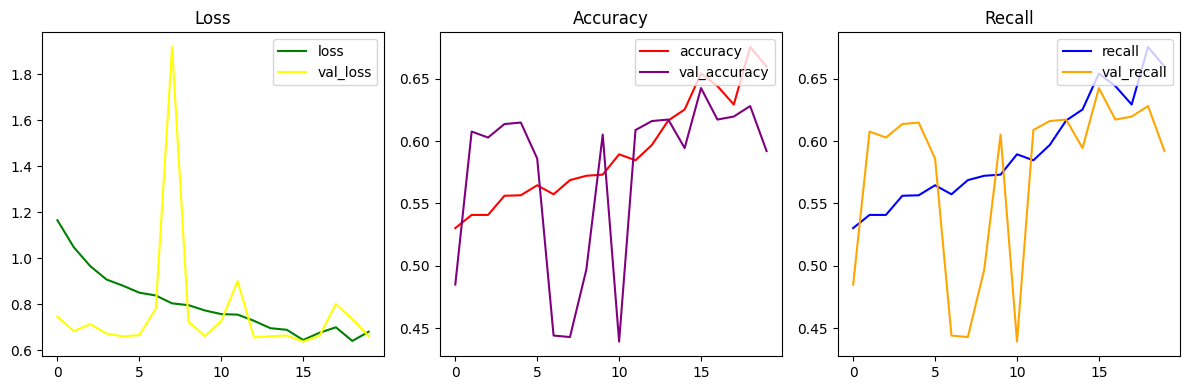

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_densenet_2_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_densenet_2_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_densenet_2_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_densenet_2_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_densenet_2_res.history['recall_6'], color='blue', label='recall')
axes[2].plot(mass_densenet_2_res.history['val_recall_6'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_densenet_2.save(ROOT + '/models/mass_densenet_2.keras')
# mass_densenet_2 = keras.models.load_model(ROOT + '/models/mass_densenet_2.keras')

In [ ]:
hist_df = pd.DataFrame(mass_densenet_2_res.history)
hist_df.to_csv(ROOT + '/history/mass_densenet_2_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_densenet_2.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - binary_accuracy: 0.5369 - loss: 0.7028 - recall_6: 0.5369
Loss:  0.6999845504760742
Accuracy:  0.539370059967041
Recall:  0.539370059967041


**Calcification DenseNet Model 3**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/shawon10/plant-disease-classification-using-densenet121
def preprocess(image, label):
  image=tf.keras.applications.densenet.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

densenet = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))
input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)
x = densenet(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(2,activation = 'softmax')(x)
calc_densenet_3 = Model(input,output)
calc_densenet_3.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,823,062 (71.80 MB)

 Trainable params: 18,589,654 (70.91 MB)

 Non-trainable params: 233,408 (911.75 KB)

In [ ]:
calc_densenet_3.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_densenet_3_res = calc_densenet_3.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 2732s 7s/step - binary_accuracy: 0.6114 - loss: 0.9565 - recall_1: 0.6114 - val_binary_accuracy: 0.7037 - val_loss: 0.7030 - val_recall_1: 0.7037
Epoch 2/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 273s 893ms/step - binary_accuracy: 0.6814 - loss: 0.6967 - recall_1: 0.6814 - val_binary_accuracy: 0.7374 - val_loss: 0.5756 - val_recall_1: 0.7374
Epoch 3/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 272s 893ms/step - binary_accuracy: 0.7093 - loss: 0.6321 - recall_1: 0.7093 - val_binary_accuracy: 0.7513 - val_loss: 0.4909 - val_recall_1: 0.7513
Epoch 4/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 272s 892ms/step - binary_accuracy: 0.7320 - loss: 0.5436 - recall_1: 0.7320 - val_binary_accuracy: 0.7587 - val_loss: 0.4843 - val_recall_1: 0.7587
Epoch 5/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 272s 892ms/step - binary_accuracy: 0.7488 - loss: 0.5083 - recall_1: 0.7488 - val_binary_accuracy: 0.7605 - val_loss: 0.4714 - val_recall_1: 0.7605
Epoch 6/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 272s 890ms/step - bina

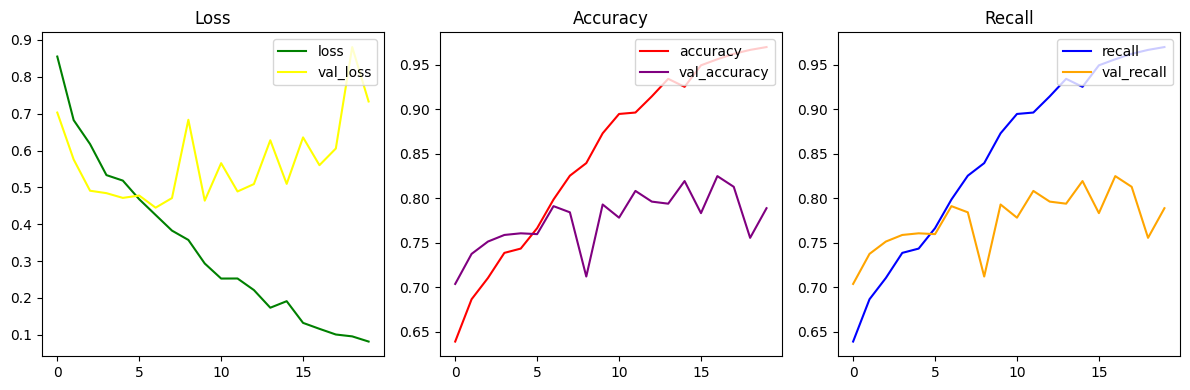

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_densenet_3_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_densenet_3_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_densenet_3_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_densenet_3_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_densenet_3_res.history['recall_1'], color='blue', label='recall')
axes[2].plot(calc_densenet_3_res.history['val_recall_1'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_densenet_3.save(ROOT + '/models/mass_densenet_3.keras')
# calc_densenet_3 = keras.models.load_model(ROOT + '/models/calc_densenet_3.keras')

In [ ]:
hist_df = pd.DataFrame(calc_densenet_3_res.history)
hist_df.to_csv(ROOT + '/history/calc_densenet_3_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_densenet_3.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

73/73 ━━━━━━━━━━━━━━━━━━━━ 408s 6s/step - binary_accuracy: 0.8290 - loss: 0.6707 - recall_1: 0.8290
Loss:  0.6930771470069885
Accuracy:  0.8289473652839661
Recall:  0.8289473652839661


**Mass Densenet Model 3**

In [ ]:
densenet.summary()

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/shawon10/plant-disease-classification-using-densenet121
def preprocess(image, label):
  image=tf.keras.applications.densenet.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

densenet = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))
input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)
x = densenet(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(2,activation = 'softmax')(x)
mass_densenet_3 = Model(input,output)
mass_densenet_3.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,823,062 (71.80 MB)

 Trainable params: 18,589,654 (70.91 MB)

 Non-trainable params: 233,408 (911.75 KB)

In [ ]:
mass_densenet_3.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_densenet_3_res = mass_densenet_3.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1019s 5s/step - binary_accuracy: 0.5011 - loss: 1.3234 - recall_5: 0.5011 - val_binary_accuracy: 0.4958 - val_loss: 0.7193 - val_recall_5: 0.4958
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 102s 867ms/step - binary_accuracy: 0.5254 - loss: 1.0724 - recall_5: 0.5254 - val_binary_accuracy: 0.6017 - val_loss: 0.7294 - val_recall_5: 0.6017
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 101s 864ms/step - binary_accuracy: 0.5431 - loss: 0.9958 - recall_5: 0.5431 - val_binary_accuracy: 0.6173 - val_loss: 0.6766 - val_recall_5: 0.6173
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 101s 864ms/step - binary_accuracy: 0.5432 - loss: 0.9335 - recall_5: 0.5432 - val_binary_accuracy: 0.6017 - val_loss: 0.6722 - val_recall_5: 0.6017
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 101s 864ms/step - binary_accuracy: 0.5598 - loss: 0.9087 - recall_5: 0.5598 - val_binary_accuracy: 0.6101 - val_loss: 0.9139 - val_recall_5: 0.6101
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 101s 863ms/step - bina

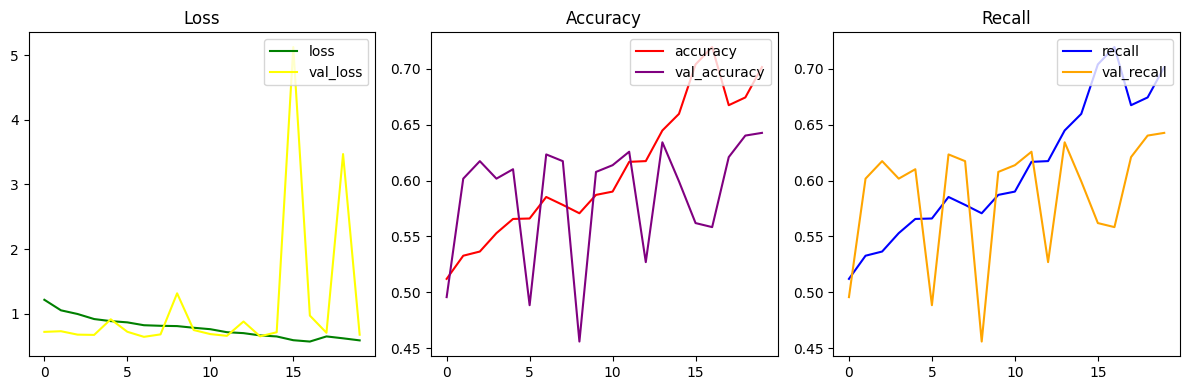

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_densenet_3_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_densenet_3_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_densenet_3_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_densenet_3_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_densenet_3_res.history['recall_5'], color='blue', label='recall')
axes[2].plot(mass_densenet_3_res.history['val_recall_5'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_densenet_3.save(ROOT + '/models/mass_densenet_3.keras')
# mass_densenet_3 = keras.models.load_model(ROOT + '/models/mass_densenet_3.keras')

In [ ]:
hist_df = pd.DataFrame(mass_densenet_3_res.history)
hist_df.to_csv(ROOT + '/history/mass_densenet_3_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_densenet_3.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - binary_accuracy: 0.5518 - loss: 0.9980 - recall_5: 0.5518
Loss:  1.0779675245285034
Accuracy:  0.5255905389785767
Recall:  0.5255905389785767


**Calc DenseNet Model 4**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/shawon10/plant-disease-classification-using-densenet121
def preprocess(image, label):
  image=tf.keras.applications.densenet.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

densenet = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))
input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)
x = densenet(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.03))(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.03))(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)

output = Dense(2,activation = 'softmax')(x)
calc_densenet_4 = Model(input,output)
calc_densenet_4.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,967,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,421,142 (77.90 MB)

 Trainable params: 20,191,830 (77.03 MB)

 Non-trainable params: 229,312 (895.75 KB)

In [ ]:
calc_densenet_4.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_densenet_4_res = calc_densenet_4.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1004s 5s/step - binary_accuracy: 0.6283 - loss: 42.4909 - recall_1: 0.6283 - val_binary_accuracy: 0.6560 - val_loss: 29.2659 - val_recall_1: 0.6560
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 97s 845ms/step - binary_accuracy: 0.7061 - loss: 26.1503 - recall_1: 0.7061 - val_binary_accuracy: 0.3539 - val_loss: 18.6730 - val_recall_1: 0.3539
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 97s 843ms/step - binary_accuracy: 0.7440 - loss: 16.6014 - recall_1: 0.7440 - val_binary_accuracy: 0.6893 - val_loss: 12.0757 - val_recall_1: 0.6893
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 98s 846ms/step - binary_accuracy: 0.7326 - loss: 10.9630 - recall_1: 0.7326 - val_binary_accuracy: 0.6498 - val_loss: 12.8186 - val_recall_1: 0.6498
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 98s 847ms/step - binary_accuracy: 0.7651 - loss: 7.5014 - recall_1: 0.7651 - val_binary_accuracy: 0.7398 - val_loss: 5.8082 - val_recall_1: 0.7398
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 98s 846ms/step - b

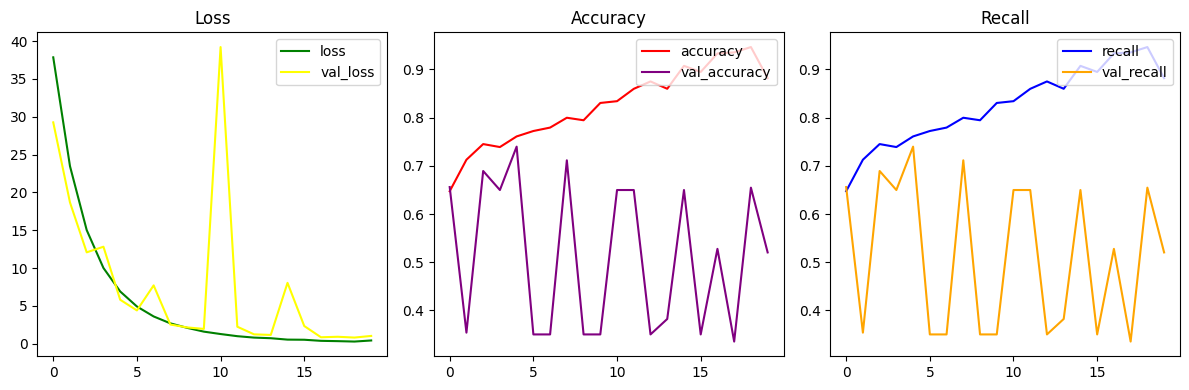

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_densenet_4_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_densenet_4_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_densenet_4_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_densenet_4_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_densenet_4_res.history['recall_1'], color='blue', label='recall')
axes[2].plot(calc_densenet_4_res.history['val_recall_1'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_densenet_4.save(ROOT + '/models/calc_densenet_4.keras')
# calc_densenet_4 = keras.models.load_model(ROOT + '/models/calc_densenet_4.keras')

In [ ]:
hist_df = pd.DataFrame(calc_densenet_4_res.history)
hist_df.to_csv(ROOT + '/history/calc_densenet_4_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_densenet_4.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - binary_accuracy: 0.4537 - loss: 1.1670 - recall_1: 0.4537
Loss:  1.1557824611663818
Accuracy:  0.46035805344581604
Recall:  0.46035805344581604


**Mass DenseNet Model 4**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/shawon10/plant-disease-classification-using-densenet121
def preprocess(image, label):
  image=tf.keras.applications.densenet.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

densenet = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))
input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)
x = densenet(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(2,activation = 'softmax')(x)
mass_densenet_4 = Model(input,output)
mass_densenet_4.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,823,062 (71.80 MB)

 Trainable params: 18,589,654 (70.91 MB)

 Non-trainable params: 233,408 (911.75 KB)

In [ ]:
mass_densenet_4.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_densenet_4_res = mass_densenet_4.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1714s 10s/step - binary_accuracy: 0.5227 - loss: 1.2336 - recall: 0.5227 - val_binary_accuracy: 0.4761 - val_loss: 0.9839 - val_recall: 0.4761
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 110s 837ms/step - binary_accuracy: 0.5278 - loss: 1.0816 - recall: 0.5278 - val_binary_accuracy: 0.5249 - val_loss: 0.7912 - val_recall: 0.5249
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 108s 832ms/step - binary_accuracy: 0.5266 - loss: 0.9728 - recall: 0.5266 - val_binary_accuracy: 0.6030 - val_loss: 0.8450 - val_recall: 0.6030
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 108s 831ms/step - binary_accuracy: 0.5398 - loss: 0.9142 - recall: 0.5398 - val_binary_accuracy: 0.5857 - val_loss: 0.7512 - val_recall: 0.5857
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 108s 831ms/step - binary_accuracy: 0.5592 - loss: 0.8505 - recall: 0.5592 - val_binary_accuracy: 0.5922 - val_loss: 0.7825 - val_recall: 0.5922
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 108s 832ms/step - binary_accuracy: 0.5619

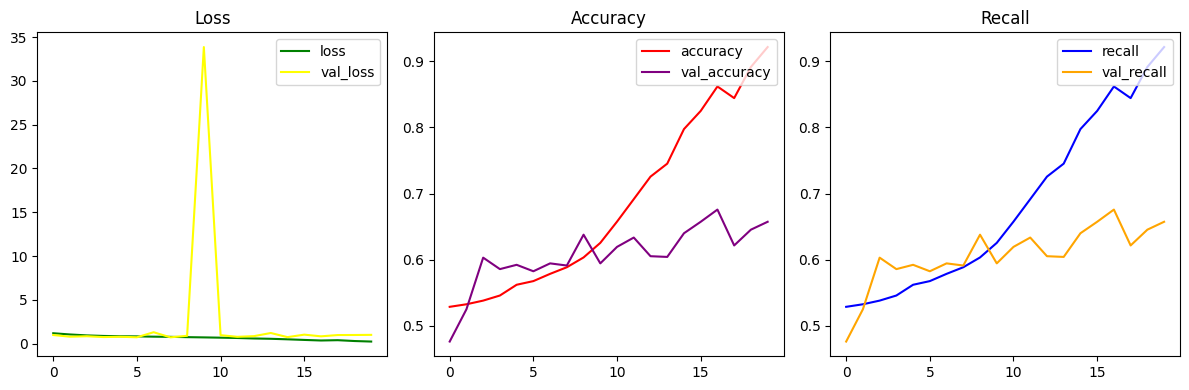

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_densenet_4_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_densenet_4_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_densenet_4_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_densenet_4_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_densenet_4_res.history['recall'], color='blue', label='recall')
axes[2].plot(mass_densenet_4_res.history['val_recall'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_densenet_4.save(ROOT + '/models/mass_densenet_4.keras')
# mass_densenet_4 = keras.models.load_model(ROOT + '/models/mass_densenet_4.keras')

In [ ]:
hist_df = pd.DataFrame(mass_densenet_4_res.history)
hist_df.to_csv(ROOT + '/history/mass_densenet_4_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_densenet_4.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

**Calcification DenseNet Model 5**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/shawon10/plant-disease-classification-using-densenet121
def preprocess(image, label):
  image=tf.keras.applications.densenet.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

densenet = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))
input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)
x = densenet(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.03))(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.03))(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)

output = Dense(2,activation = 'softmax')(x)
calc_densenet_5 = Model(input,output)
calc_densenet_5.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,967,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,421,142 (77.90 MB)

 Trainable params: 20,191,830 (77.03 MB)

 Non-trainable params: 229,312 (895.75 KB)

In [ ]:
calc_densenet_5.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_densenet_5_res = calc_densenet_5.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1532s 8s/step - binary_accuracy: 0.6244 - loss: 41.9863 - recall: 0.6244 - val_binary_accuracy: 0.6386 - val_loss: 28.0790 - val_recall: 0.6386
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 122s 928ms/step - binary_accuracy: 0.7628 - loss: 24.5129 - recall: 0.7628 - val_binary_accuracy: 0.5750 - val_loss: 18.2772 - val_recall: 0.5750
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 121s 921ms/step - binary_accuracy: 0.8419 - loss: 14.9054 - recall: 0.8419 - val_binary_accuracy: 0.7799 - val_loss: 10.9210 - val_recall: 0.7799
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 121s 923ms/step - binary_accuracy: 0.9175 - loss: 9.3827 - recall: 0.9175 - val_binary_accuracy: 0.8231 - val_loss: 7.0556 - val_recall: 0.8231
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 121s 923ms/step - binary_accuracy: 0.9427 - loss: 6.1369 - recall: 0.9427 - val_binary_accuracy: 0.7929 - val_loss: 4.8986 - val_recall: 0.7929
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 121s 923ms/step - binary_accuracy: 0

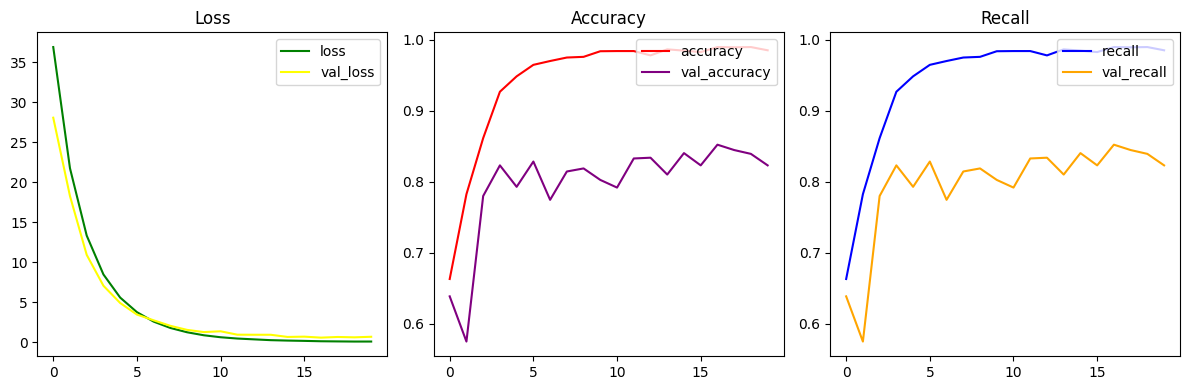

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_densenet_5_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_densenet_5_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_densenet_5_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_densenet_5_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_densenet_5_res.history['recall'], color='blue', label='recall')
axes[2].plot(calc_densenet_5_res.history['val_recall'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_densenet_5.save(ROOT + '/models/calc_densenet_5.keras')
# calc_densenet_5 = keras.models.load_model(ROOT + '/models/calc_densenet_5.keras')

In [ ]:
hist_df = pd.DataFrame(calc_densenet_5_res.history)
hist_df.to_csv(ROOT + '/history/calc_densenet_5_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_densenet_5.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step - binary_accuracy: 0.6575 - loss: 1.5059 - recall: 0.6575
Loss:  1.6070724725723267
Accuracy:  0.6533742547035217
Recall:  0.6533742547035217


**Mass DenseNet Model 5**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/shawon10/plant-disease-classification-using-densenet121
def preprocess(image, label):
  image=tf.keras.applications.densenet.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

densenet = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))
input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)
x = densenet(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(2,activation = 'softmax')(x)
mass_densenet_5 = Model(input,output)
mass_densenet_5.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,823,062 (71.80 MB)

 Trainable params: 18,589,654 (70.91 MB)

 Non-trainable params: 233,408 (911.75 KB)

In [ ]:
mass_densenet_5.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_densenet_5_res = mass_densenet_5.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 966s 4s/step - binary_accuracy: 0.6003 - loss: 1.0185 - recall_2: 0.6003 - val_binary_accuracy: 0.7025 - val_loss: 0.5981 - val_recall_2: 0.7025
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 106s 946ms/step - binary_accuracy: 0.7102 - loss: 0.7687 - recall_2: 0.7102 - val_binary_accuracy: 0.7519 - val_loss: 0.5574 - val_recall_2: 0.7519
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 106s 948ms/step - binary_accuracy: 0.7572 - loss: 0.6142 - recall_2: 0.7572 - val_binary_accuracy: 0.7532 - val_loss: 0.5764 - val_recall_2: 0.7532
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 106s 944ms/step - binary_accuracy: 0.8252 - loss: 0.4822 - recall_2: 0.8252 - val_binary_accuracy: 0.7873 - val_loss: 0.5912 - val_recall_2: 0.7873
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 106s 945ms/step - binary_accuracy: 0.8772 - loss: 0.3295 - recall_2: 0.8772 - val_binary_accuracy: 0.7835 - val_loss: 0.7045 - val_recall_2: 0.7835
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 106s 944ms/step - binar

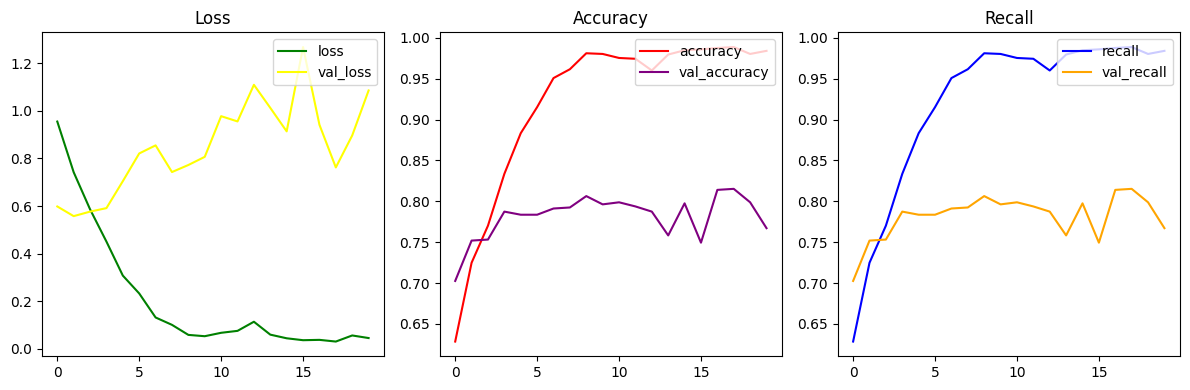

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_densenet_5_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_densenet_5_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_densenet_5_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_densenet_5_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_densenet_5_res.history['recall_2'], color='blue', label='recall')
axes[2].plot(mass_densenet_5_res.history['val_recall_2'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_densenet_5.save(ROOT + '/models/mass_densenet_5.keras')
# mass_densenet_5 = keras.models.load_model(ROOT + '/models/mass_densenet_5.keras')

In [ ]:
hist_df = pd.DataFrame(mass_densenet_5_res.history)
hist_df.to_csv(ROOT + '/history/mass_densenet_5_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_densenet_5.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - binary_accuracy: 0.7621 - loss: 1.3113 - recall_2: 0.7621
Loss:  1.4887093305587769
Accuracy:  0.7354497313499451
Recall:  0.7354497313499451


**Calcification DenseNet Model 6**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/shawon10/plant-disease-classification-using-densenet121
def preprocess(image, label):
  image=tf.keras.applications.densenet.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

densenet = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))
input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)
x = densenet(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.03))(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.03))(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)

output = Dense(2,activation = 'softmax')(x)
calc_densenet_6 = Model(input,output)
calc_densenet_6.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1024)           │     1,967,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,421,142 (77.90 MB)

 Trainable params: 20,191,830 (77.03 MB)

 Non-trainable params: 229,312 (895.75 KB)

In [ ]:
calc_densenet_6.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_densenet_6_res = calc_densenet_6.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 944s 4s/step - binary_accuracy: 0.6251 - loss: 41.9139 - recall_11: 0.6251 - val_binary_accuracy: 0.6882 - val_loss: 27.6475 - val_recall_11: 0.6882
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 114s 864ms/step - binary_accuracy: 0.7312 - loss: 24.5010 - recall_11: 0.7312 - val_binary_accuracy: 0.7152 - val_loss: 16.9227 - val_recall_11: 0.7152
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 120s 910ms/step - binary_accuracy: 0.8009 - loss: 14.9630 - recall_11: 0.8009 - val_binary_accuracy: 0.7670 - val_loss: 10.7025 - val_recall_11: 0.7670
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 124s 945ms/step - binary_accuracy: 0.8500 - loss: 9.5220 - recall_11: 0.8500 - val_binary_accuracy: 0.7594 - val_loss: 7.1620 - val_recall_11: 0.7594
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 125s 946ms/step - binary_accuracy: 0.8828 - loss: 6.2820 - recall_11: 0.8828 - val_binary_accuracy: 0.7098 - val_loss: 5.4394 - val_recall_11: 0.7098
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 125s 94

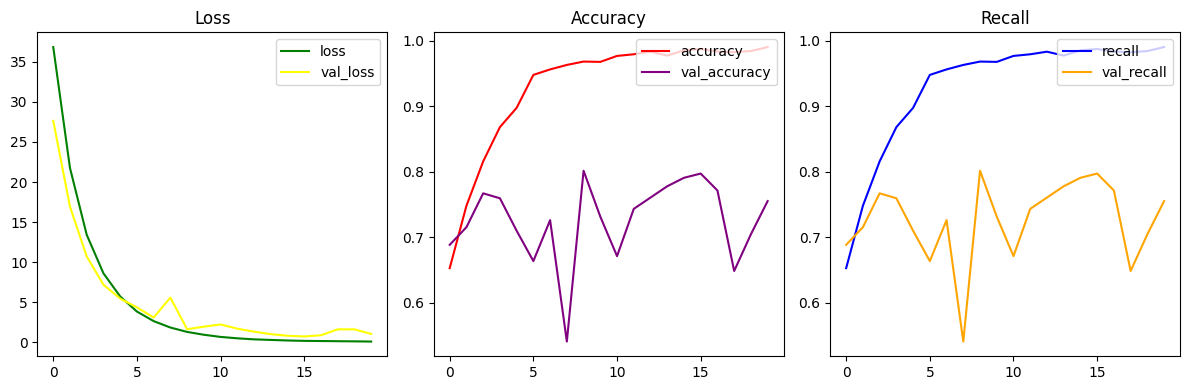

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_densenet_6_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_densenet_6_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_densenet_6_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_densenet_6_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_densenet_6_res.history['recall_11'], color='blue', label='recall')
axes[2].plot(calc_densenet_6_res.history['val_recall_11'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_densenet_6.save(ROOT + '/models/calc_densenet_6.keras')
# calc_densenet_6 = keras.models.load_model(ROOT + '/models/calc_densenet_6.keras')

In [ ]:
hist_df = pd.DataFrame(calc_densenet_6_res.history)
hist_df.to_csv(ROOT + '/history/calc_densenet_6_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_densenet_6.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - binary_accuracy: 0.6420 - loss: 1.6840 - recall_11: 0.6420
Loss:  1.7088357210159302
Accuracy:  0.6441717743873596
Recall:  0.6441717743873596


**Mass DenseNet Model 6**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/shawon10/plant-disease-classification-using-densenet121
def preprocess(image, label):
  image=tf.keras.applications.densenet.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

densenet = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))
input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)
x = densenet(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(2,activation = 'softmax')(x)
mass_densenet_6 = Model(input,output)
mass_densenet_6.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,823,062 (71.80 MB)

 Trainable params: 18,589,654 (70.91 MB)

 Non-trainable params: 233,408 (911.75 KB)

In [ ]:
mass_densenet_6.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_densenet_6_res = mass_densenet_6.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 3988s 6s/step - binary_accuracy: 0.5629 - loss: 1.0697 - recall: 0.5629 - val_binary_accuracy: 0.6479 - val_loss: 0.8780 - val_recall: 0.6479
Epoch 2/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 465s 817ms/step - binary_accuracy: 0.6366 - loss: 0.7313 - recall: 0.6366 - val_binary_accuracy: 0.6407 - val_loss: 0.6538 - val_recall: 0.6407
Epoch 3/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 464s 816ms/step - binary_accuracy: 0.6779 - loss: 0.5971 - recall: 0.6779 - val_binary_accuracy: 0.6388 - val_loss: 0.6232 - val_recall: 0.6388
Epoch 4/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 464s 817ms/step - binary_accuracy: 0.7195 - loss: 0.5280 - recall: 0.7195 - val_binary_accuracy: 0.7366 - val_loss: 0.5319 - val_recall: 0.7366
Epoch 5/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 464s 816ms/step - binary_accuracy: 0.7644 - loss: 0.4639 - recall: 0.7644 - val_binary_accuracy: 0.7322 - val_loss: 0.5661 - val_recall: 0.7322
Epoch 6/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 463s 816ms/step - binary_accuracy: 0.8189 

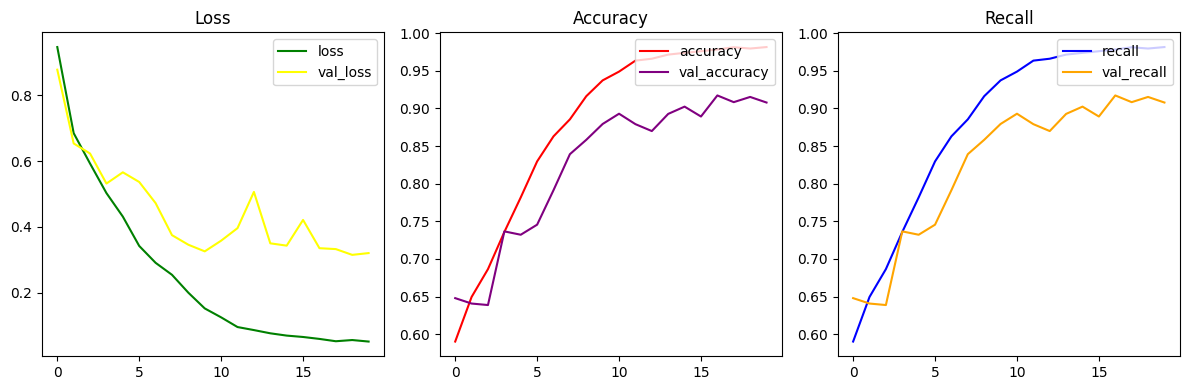

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_densenet_6_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_densenet_6_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_densenet_6_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_densenet_6_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_densenet_6_res.history['recall'], color='blue', label='recall')
axes[2].plot(mass_densenet_6_res.history['val_recall'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_densenet_6.save(ROOT + '/models/mass_densenet_6.keras')
# mass_densenet_6 = keras.models.load_model(ROOT + '/models/mass_densenet_6.keras')

In [ ]:
hist_df = pd.DataFrame(mass_densenet_6_res.history)
hist_df.to_csv(ROOT + '/history/mass_densenet_6_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_densenet_6.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

16/16 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step - binary_accuracy: 0.9522 - loss: 0.1107 - recall: 0.9522
Loss:  0.12467264384031296
Accuracy:  0.9488692283630371
Recall:  0.9488692283630371


**Combined DenseNet Model**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/shawon10/plant-disease-classification-using-densenet121
def preprocess(image, label):
  image=tf.keras.applications.densenet.preprocess_input(image)
  return image, label

combined_train = combined_train.map(preprocess)
combined_val = combined_val.map(preprocess)
combined_test = combined_test.map(preprocess)

densenet = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))
input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)
x = densenet(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(2,activation = 'softmax')(x)
combined_densenet_1 = Model(input,output)
combined_densenet_1.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,823,062 (71.80 MB)

 Trainable params: 18,589,654 (70.91 MB)

 Non-trainable params: 233,408 (911.75 KB)

In [ ]:
combined_densenet_1.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
combined_densenet_1_res = combined_densenet_1.fit(combined_train, epochs=20, verbose=1, validation_data=combined_val)

Epoch 1/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 1373s 2s/step - binary_accuracy: 0.5859 - loss: 1.0102 - recall_12: 0.5859 - val_binary_accuracy: 0.6869 - val_loss: 0.6040 - val_recall_12: 0.6869
Epoch 2/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 518s 918ms/step - binary_accuracy: 0.6545 - loss: 0.6488 - recall_12: 0.6545 - val_binary_accuracy: 0.6934 - val_loss: 0.5778 - val_recall_12: 0.6934
Epoch 3/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 518s 917ms/step - binary_accuracy: 0.6947 - loss: 0.5824 - recall_12: 0.6947 - val_binary_accuracy: 0.7181 - val_loss: 0.5389 - val_recall_12: 0.7181
Epoch 4/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 517s 917ms/step - binary_accuracy: 0.7198 - loss: 0.5314 - recall_12: 0.7198 - val_binary_accuracy: 0.7166 - val_loss: 0.5574 - val_recall_12: 0.7166
Epoch 5/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 517s 917ms/step - binary_accuracy: 0.7424 - loss: 0.4976 - recall_12: 0.7424 - val_binary_accuracy: 0.6921 - val_loss: 0.5976 - val_recall_12: 0.6921
Epoch 6/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 517s 916ms/s

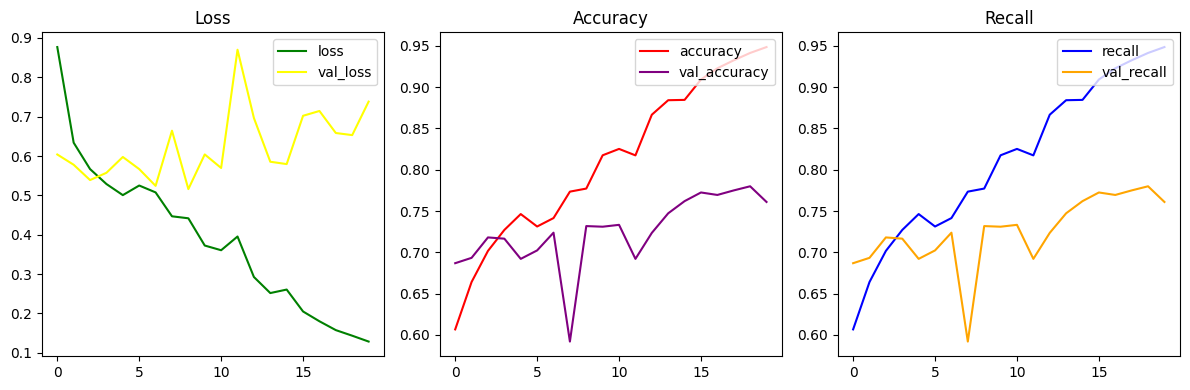

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(combined_densenet_1_res.history['loss'], color='green', label='loss')
axes[0].plot(combined_densenet_1_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(combined_densenet_1_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(combined_densenet_1_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(combined_densenet_1_res.history['recall_12'], color='blue', label='recall')
axes[2].plot(combined_densenet_1_res.history['val_recall_12'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
combined_densenet_1.save(ROOT + '/models/combined_densenet_1.keras')
# combined_densenet_1 = keras.models.load_model(ROOT + '/models/combined_densenet_1.keras')

In [ ]:
hist_df = pd.DataFrame(combined_densenet_1_res.history)
hist_df.to_csv(ROOT + '/history/combined_densenet_1_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
loss, accuracy, recall = combined_densenet_1.evaluate(combined_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)
print("Recall: ", recall)

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - binary_accuracy: 0.6190 - loss: 1.5541 - recall_12: 0.6190
Loss:  1.5516422986984253
Accuracy:  0.6259191036224365
Recall:  0.6259191036224365


# **ResNet**

**Calcification ResNet Model 1**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/muhammadfaizan65/clahe-medical-imaging-classification-using-resnet5
def preprocess(image, label):
  image=tf.keras.applications.resnet.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False

calc_resnet_1 = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

calc_resnet_1.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
calc_resnet_1.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_resnet_1_res = calc_resnet_1.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 116s 216ms/step - binary_accuracy: 0.6327 - loss: 0.7018 - recall_2: 0.6327 - val_binary_accuracy: 0.7202 - val_loss: 0.5394 - val_recall_2: 0.7202
Epoch 2/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 83s 182ms/step - binary_accuracy: 0.6993 - loss: 0.5634 - recall_2: 0.6993 - val_binary_accuracy: 0.7267 - val_loss: 0.5241 - val_recall_2: 0.7267
Epoch 3/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 83s 181ms/step - binary_accuracy: 0.7136 - loss: 0.5420 - recall_2: 0.7136 - val_binary_accuracy: 0.7328 - val_loss: 0.5127 - val_recall_2: 0.7328
Epoch 4/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 83s 180ms/step - binary_accuracy: 0.7238 - loss: 0.5302 - recall_2: 0.7238 - val_binary_accuracy: 0.7414 - val_loss: 0.5041 - val_recall_2: 0.7414
Epoch 5/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 83s 181ms/step - binary_accuracy: 0.7337 - loss: 0.5174 - recall_2: 0.7337 - val_binary_accuracy: 0.7421 - val_loss: 0.4963 - val_recall_2: 0.7421
Epoch 6/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 83s 181ms/step - binary_

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_resnet_1_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_resnet_1_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_resnet_1_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_resnet_1_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_resnet_1_res.history['recall_2'], color='blue', label='recall')
axes[2].plot(calc_resnet_1_res.history['val_recall_2'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
calc_resnet_1.save(ROOT + '/models/calc_resnet_1.keras')
# calc_resnet_1 = keras.models.load_model(ROOT + '/models/calc_resnet_1.keras')

In [ ]:
hist_df = pd.DataFrame(calc_resnet_1_res.history)
hist_df.to_csv(ROOT + '/history/calc_resnet_1_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_resnet_1.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - binary_accuracy: 0.6405 - loss: 0.6939 - recall_2: 0.6405
Loss:  0.6770623922348022
Accuracy:  0.6569148898124695
Recall:  0.6569148898124695


**Mass ResNet Model 1**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/muhammadfaizan65/clahe-medical-imaging-classification-using-resnet5
def preprocess(image, label):
  image=tf.keras.applications.resnet.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False

mass_resnet_1 = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

mass_resnet_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
mass_resnet_1.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_resnet_1_res = mass_resnet_1.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 94s 212ms/step - binary_accuracy: 0.5592 - loss: 0.7734 - recall_3: 0.5592 - val_binary_accuracy: 0.6238 - val_loss: 0.6375 - val_recall_3: 0.6238
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 71s 182ms/step - binary_accuracy: 0.6241 - loss: 0.6445 - recall_3: 0.6241 - val_binary_accuracy: 0.6455 - val_loss: 0.6228 - val_recall_3: 0.6455
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 71s 180ms/step - binary_accuracy: 0.6474 - loss: 0.6231 - recall_3: 0.6474 - val_binary_accuracy: 0.6578 - val_loss: 0.6107 - val_recall_3: 0.6578
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 71s 180ms/step - binary_accuracy: 0.6568 - loss: 0.6109 - recall_3: 0.6568 - val_binary_accuracy: 0.6643 - val_loss: 0.6028 - val_recall_3: 0.6643
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 71s 180ms/step - binary_accuracy: 0.6651 - loss: 0.6032 - recall_3: 0.6651 - val_binary_accuracy: 0.6592 - val_loss: 0.6021 - val_recall_3: 0.6592
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 71s 181ms/step - binary_a

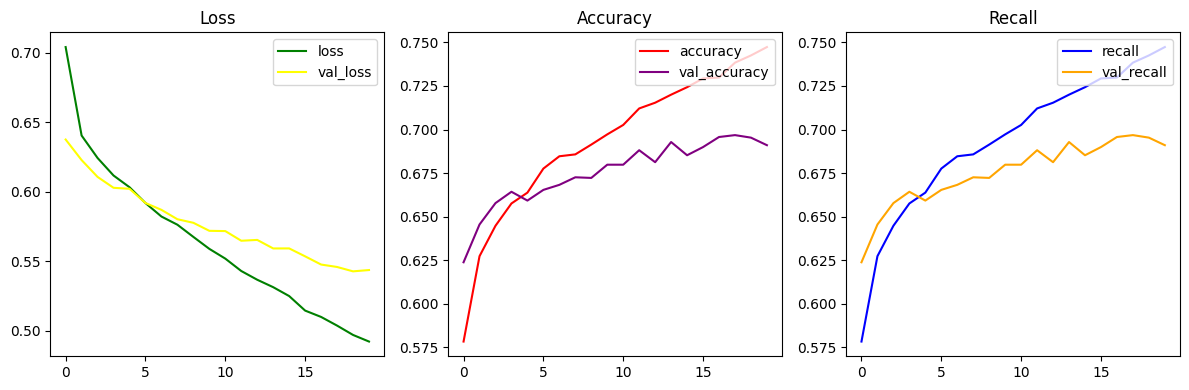

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_resnet_1_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_resnet_1_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_resnet_1_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_resnet_1_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_resnet_1_res.history['recall_3'], color='blue', label='recall')
axes[2].plot(mass_resnet_1_res.history['val_recall_3'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_resnet_1.save(ROOT + '/models/mass_resnet_1.keras')
# mass_resnet_1 = keras.models.load_model(ROOT + '/models/mass_resnet_1.keras')

In [ ]:
hist_df = pd.DataFrame(mass_resnet_1_res.history)
hist_df.to_csv(ROOT + '/history/mass_resnet_1_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_resnet_1.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 480ms/step - binary_accuracy: 0.6357 - loss: 0.6718 - recall_3: 0.6357
Loss:  0.6582276821136475
Accuracy:  0.6463844776153564
Recall:  0.6463844776153564


**Calcification ResNet Model 2**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/muhammadfaizan65/clahe-medical-imaging-classification-using-resnet5
def preprocess(image, label):
  image=tf.keras.applications.resnet.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False

calc_resnet_2 = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

calc_resnet_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
calc_resnet_2.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_resnet_2_res = calc_resnet_2.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 270ms/step - binary_accuracy: 0.6448 - loss: 0.7665 - recall_2: 0.6448 - val_binary_accuracy: 0.7526 - val_loss: 0.5130 - val_recall_2: 0.7526
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - binary_accuracy: 0.7279 - loss: 0.5582 - recall_2: 0.7279 - val_binary_accuracy: 0.7539 - val_loss: 0.5043 - val_recall_2: 0.7539
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - binary_accuracy: 0.7434 - loss: 0.5284 - recall_2: 0.7434 - val_binary_accuracy: 0.7579 - val_loss: 0.4983 - val_recall_2: 0.7579
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - binary_accuracy: 0.7502 - loss: 0.5236 - recall_2: 0.7502 - val_binary_accuracy: 0.7566 - val_loss: 0.4918 - val_recall_2: 0.7566
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - binary_accuracy: 0.7508 - loss: 0.5146 - recall_2: 0.7508 - val_binary_accuracy: 0.7513 - val_loss: 0.4887 - val_recall_2: 0.7513
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - binary_a

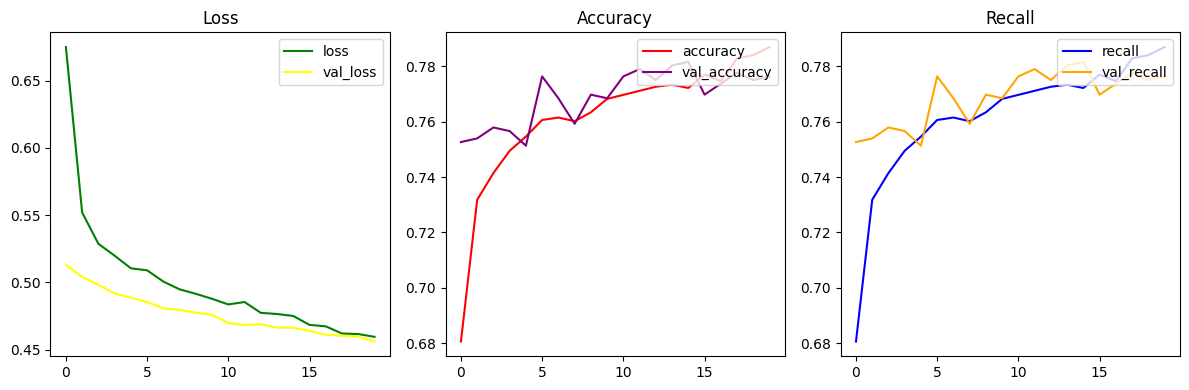

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_resnet_2_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_resnet_2_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_resnet_2_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_resnet_2_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_resnet_2_res.history['recall_2'], color='blue', label='recall')
axes[2].plot(calc_resnet_2_res.history['val_recall_2'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_resnet_2.save(ROOT + '/models/calc_resnet_2.keras')
# calc_resnet_2 = keras.models.load_model(ROOT + '/models/calc_resnet_2.keras')

In [ ]:
hist_df = pd.DataFrame(calc_resnet_2_res.history)
hist_df.to_csv(ROOT + '/history/calc_resnet_2_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_resnet_2.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 415ms/step - binary_accuracy: 0.6913 - loss: 0.6537 - recall_2: 0.6913
Loss:  0.5865524411201477
Accuracy:  0.7182795405387878
Recall:  0.7182795405387878


**Mass ResNet Model 2**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/muhammadfaizan65/clahe-medical-imaging-classification-using-resnet5
def preprocess(image, label):
  image=tf.keras.applications.resnet.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False

mass_resnet_2 = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

mass_resnet_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
mass_resnet_2.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_resnet_2_res = mass_resnet_2.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 42s 265ms/step - binary_accuracy: 0.5114 - loss: 1.1109 - recall_4: 0.5114 - val_binary_accuracy: 0.6053 - val_loss: 0.6672 - val_recall_4: 0.6053
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 189ms/step - binary_accuracy: 0.5627 - loss: 0.6929 - recall_4: 0.5627 - val_binary_accuracy: 0.6029 - val_loss: 0.6680 - val_recall_4: 0.6029
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 189ms/step - binary_accuracy: 0.5697 - loss: 0.6801 - recall_4: 0.5697 - val_binary_accuracy: 0.6053 - val_loss: 0.6692 - val_recall_4: 0.6053
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 184ms/step - binary_accuracy: 0.5781 - loss: 0.6764 - recall_4: 0.5781 - val_binary_accuracy: 0.6017 - val_loss: 0.6675 - val_recall_4: 0.6017
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - binary_accuracy: 0.5730 - loss: 0.6785 - recall_4: 0.5730 - val_binary_accuracy: 0.6137 - val_loss: 0.6642 - val_recall_4: 0.6137
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - binary_a

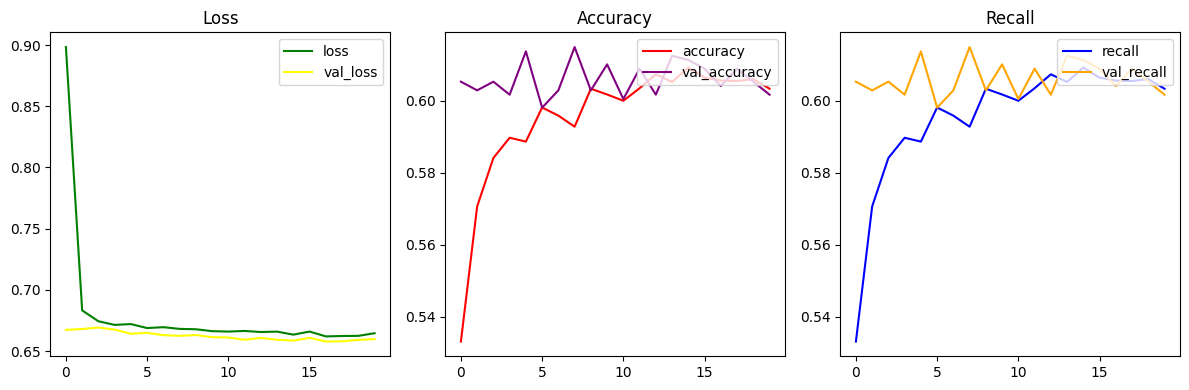

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_resnet_2_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_resnet_2_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_resnet_2_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_resnet_2_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_resnet_2_res.history['recall_4'], color='blue', label='recall')
axes[2].plot(mass_resnet_2_res.history['val_recall_4'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_resnet_2.save(ROOT + '/models/mass_resnet_2.keras')
# mass_resnet_2 = keras.models.load_model(ROOT + '/models/mass_resnet_2.keras')

In [ ]:
hist_df = pd.DataFrame(mass_resnet_2_res.history)
hist_df.to_csv(ROOT + '/history/mass_resnet_2_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_resnet_2.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 445ms/step - binary_accuracy: 0.5314 - loss: 0.7078 - recall_4: 0.5314
Loss:  0.7020259499549866
Accuracy:  0.537401556968689
Recall:  0.537401556968689


**Calcification ResNet Model 3**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/muhammadfaizan65/clahe-medical-imaging-classification-using-resnet5
def preprocess(image, label):
  image=tf.keras.applications.resnet.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False

calc_resnet_3 = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

calc_resnet_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
calc_resnet_3.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_resnet_3_res = calc_resnet_3.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 45s 325ms/step - binary_accuracy: 0.6565 - loss: 0.7131 - recall_3: 0.6565 - val_binary_accuracy: 0.7539 - val_loss: 0.5140 - val_recall_3: 0.7539
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - binary_accuracy: 0.7365 - loss: 0.5468 - recall_3: 0.7365 - val_binary_accuracy: 0.7566 - val_loss: 0.5050 - val_recall_3: 0.7566
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - binary_accuracy: 0.7499 - loss: 0.5322 - recall_3: 0.7499 - val_binary_accuracy: 0.7618 - val_loss: 0.5002 - val_recall_3: 0.7618
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - binary_accuracy: 0.7592 - loss: 0.5126 - recall_3: 0.7592 - val_binary_accuracy: 0.7645 - val_loss: 0.4950 - val_recall_3: 0.7645
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - binary_accuracy: 0.7492 - loss: 0.5105 - recall_3: 0.7492 - val_binary_accuracy: 0.7671 - val_loss: 0.4897 - val_recall_3: 0.7671
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - binary_a

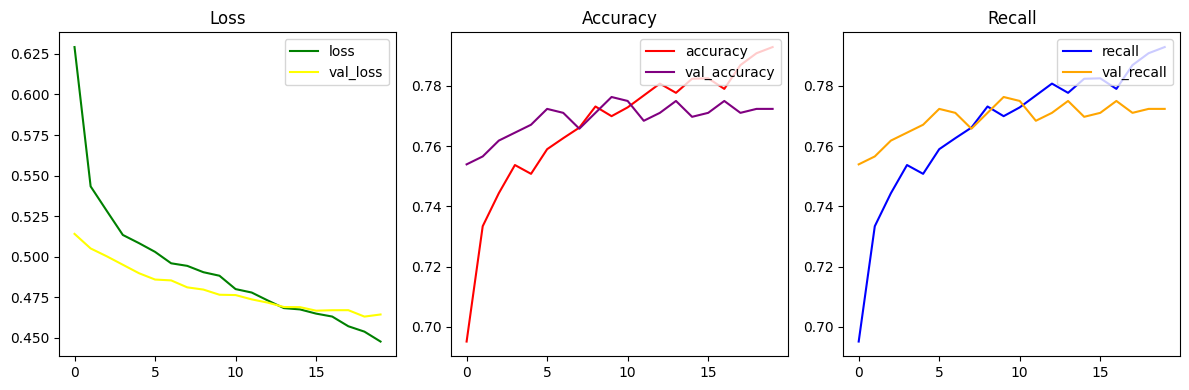

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_resnet_3_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_resnet_3_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_resnet_3_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_resnet_3_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_resnet_3_res.history['recall_3'], color='blue', label='recall')
axes[2].plot(calc_resnet_3_res.history['val_recall_3'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_resnet_3.save(ROOT + '/models/calc_resnet_3.keras')
# calc_resnet_3 = keras.models.load_model(ROOT + '/models/calc_resnet_3.keras')

In [ ]:
hist_df = pd.DataFrame(calc_resnet_3_res.history)
hist_df.to_csv(ROOT + '/history/calc_resnet_3_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_resnet_3.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 603ms/step - binary_accuracy: 0.7364 - loss: 0.5459 - recall_3: 0.7364
Loss:  0.580077588558197
Accuracy:  0.7161290049552917
Recall:  0.7161290049552917


**Mass ResNet Model 3**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/muhammadfaizan65/clahe-medical-imaging-classification-using-resnet5
def preprocess(image, label):
  image=tf.keras.applications.resnet.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False

mass_resnet_3 = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

mass_resnet_3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
mass_resnet_3.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_resnet_3_res = mass_resnet_3.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 50s 335ms/step - binary_accuracy: 0.5248 - loss: 0.8828 - recall_4: 0.5248 - val_binary_accuracy: 0.6053 - val_loss: 0.6625 - val_recall_4: 0.6053
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - binary_accuracy: 0.5896 - loss: 0.6768 - recall_4: 0.5896 - val_binary_accuracy: 0.6173 - val_loss: 0.6571 - val_recall_4: 0.6173
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - binary_accuracy: 0.6035 - loss: 0.6648 - recall_4: 0.6035 - val_binary_accuracy: 0.6233 - val_loss: 0.6574 - val_recall_4: 0.6233
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - binary_accuracy: 0.5975 - loss: 0.6694 - recall_4: 0.5975 - val_binary_accuracy: 0.6185 - val_loss: 0.6557 - val_recall_4: 0.6185
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - binary_accuracy: 0.5988 - loss: 0.6694 - recall_4: 0.5988 - val_binary_accuracy: 0.6233 - val_loss: 0.6531 - val_recall_4: 0.6233
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - binary_a

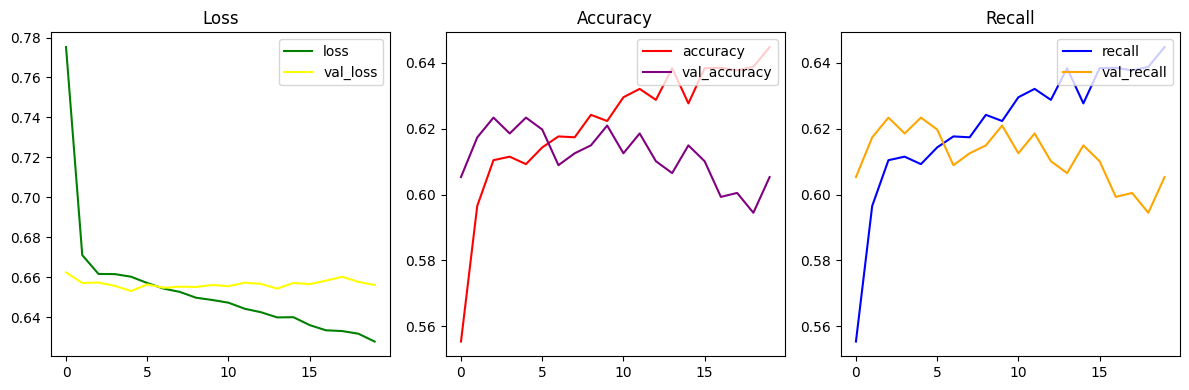

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_resnet_3_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_resnet_3_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_resnet_3_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_resnet_3_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_resnet_3_res.history['recall_4'], color='blue', label='recall')
axes[2].plot(mass_resnet_3_res.history['val_recall_4'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_resnet_3.save(ROOT + '/models/mass_resnet_3.keras')
# mass_resnet_3 = keras.models.load_model(ROOT + '/models/mass_resnet_3.keras')

In [ ]:
hist_df = pd.DataFrame(mass_resnet_3_res.history)
hist_df.to_csv(ROOT + '/history/mass_resnet_3_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_resnet_3.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - binary_accuracy: 0.6185 - loss: 0.6957 - recall_4: 0.6185
Loss:  0.7056832909584045
Accuracy:  0.586614191532135
Recall:  0.586614191532135


**Calcification ResNet Model 4**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/muhammadfaizan65/clahe-medical-imaging-classification-using-resnet5
def preprocess(image, label):
  image=tf.keras.applications.resnet.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False

calc_resnet_4 = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

calc_resnet_4.summary()

In [ ]:
calc_resnet_4.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_resnet_4_res = calc_resnet_4.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_resnet_4_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_resnet_4_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_resnet_4_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_resnet_4_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_resnet_4_res.history['recall_2'], color='blue', label='recall')
axes[2].plot(calc_resnet_4_res.history['val_recall_2'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_resnet_4.save(ROOT + '/models/calc_resnet_4.keras')
# calc_resnet_4 = keras.models.load_model(ROOT + '/models/calc_resnet_4.keras')

In [ ]:
hist_df = pd.DataFrame(calc_resnet_4_res.history)
hist_df.to_csv(ROOT + '/history/calc_resnet_4_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_resnet_4.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

**Mass ResNet Model 4**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/muhammadfaizan65/clahe-medical-imaging-classification-using-resnet5
def preprocess(image, label):
  image=tf.keras.applications.resnet.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False

mass_resnet_4 = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

mass_resnet_4.summary()

In [ ]:
mass_resnet_4.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_resnet_4_res = mass_resnet_4.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_resnet_4_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_resnet_4_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_resnet_4_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_resnet_4_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_resnet_4_res.history['recall_2'], color='blue', label='recall')
axes[2].plot(mass_resnet_4_res.history['val_recall_2'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_resnet_4.save(ROOT + '/models/mass_resnet_4.keras')
# mass_resnet_4 = keras.models.load_model(ROOT + '/models/mass_resnet_4.keras')

In [ ]:
hist_df = pd.DataFrame(mass_resnet_4_res.history)
hist_df.to_csv(ROOT + '/history/mass_resnet_4_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_resnet_4.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

**Calcification ResNet Model 5**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/muhammadfaizan65/clahe-medical-imaging-classification-using-resnet5
def preprocess(image, label):
  image=tf.keras.applications.resnet.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False

calc_resnet_5 = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

calc_resnet_5.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
calc_resnet_5.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_resnet_5_res = calc_resnet_5.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 657ms/step - binary_accuracy: 0.6320 - loss: 0.7148 - recall: 0.6320 - val_binary_accuracy: 0.7346 - val_loss: 0.5062 - val_recall: 0.7346
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 188ms/step - binary_accuracy: 0.7035 - loss: 0.5269 - recall: 0.7035 - val_binary_accuracy: 0.7443 - val_loss: 0.4874 - val_recall: 0.7443
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 186ms/step - binary_accuracy: 0.7342 - loss: 0.4905 - recall: 0.7342 - val_binary_accuracy: 0.7422 - val_loss: 0.4753 - val_recall: 0.7422
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 188ms/step - binary_accuracy: 0.7496 - loss: 0.4715 - recall: 0.7496 - val_binary_accuracy: 0.7573 - val_loss: 0.4593 - val_recall: 0.7573
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 189ms/step - binary_accuracy: 0.7547 - loss: 0.4530 - recall: 0.7547 - val_binary_accuracy: 0.7562 - val_loss: 0.4502 - val_recall: 0.7562
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 187ms/step - binary_accuracy: 0.7638 - l

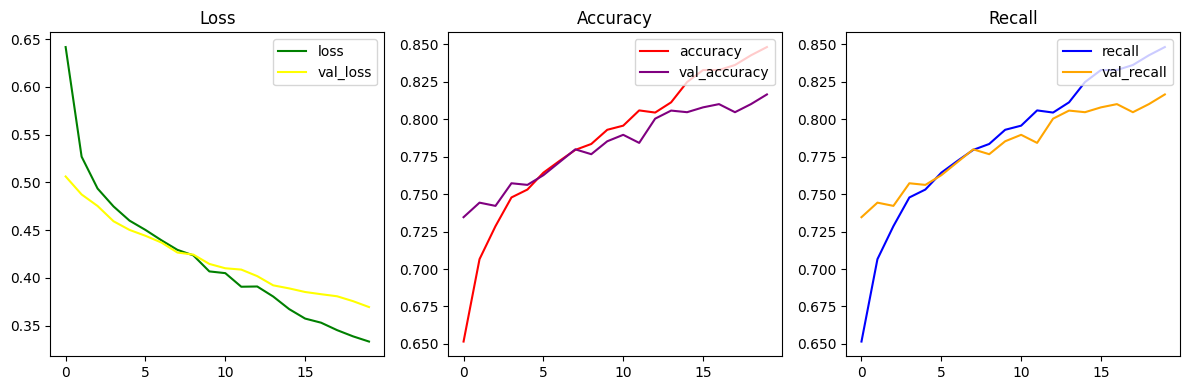

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_resnet_5_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_resnet_5_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_resnet_5_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_resnet_5_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_resnet_5_res.history['recall'], color='blue', label='recall')
axes[2].plot(calc_resnet_5_res.history['val_recall'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_resnet_5.save(ROOT + '/models/calc_resnet_5.keras')
# calc_resnet_5 = keras.models.load_model(ROOT + '/models/calc_resnet_5.keras')

In [ ]:
hist_df = pd.DataFrame(calc_resnet_5_res.history)
hist_df.to_csv(ROOT + '/history/calc_resnet_5_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_resnet_5.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 720ms/step - binary_accuracy: 0.6876 - loss: 0.5980 - recall: 0.6876
Loss:  0.6001259088516235
Accuracy:  0.6809815764427185
Recall:  0.6809815764427185


**Mass ResNet Model 5**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/muhammadfaizan65/clahe-medical-imaging-classification-using-resnet5
def preprocess(image, label):
  image=tf.keras.applications.resnet.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False

mass_resnet_5 = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

mass_resnet_5.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
mass_resnet_5.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_resnet_5_res = mass_resnet_5.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 587s 5s/step - binary_accuracy: 0.5442 - loss: 0.8909 - recall_1: 0.5442 - val_binary_accuracy: 0.6937 - val_loss: 0.5948 - val_recall_1: 0.6937
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step - binary_accuracy: 0.6529 - loss: 0.6295 - recall_1: 0.6529 - val_binary_accuracy: 0.7165 - val_loss: 0.5747 - val_recall_1: 0.7165
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - binary_accuracy: 0.6913 - loss: 0.5858 - recall_1: 0.6913 - val_binary_accuracy: 0.7203 - val_loss: 0.5611 - val_recall_1: 0.7203
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - binary_accuracy: 0.7210 - loss: 0.5633 - recall_1: 0.7210 - val_binary_accuracy: 0.7291 - val_loss: 0.5487 - val_recall_1: 0.7291
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - binary_accuracy: 0.7158 - loss: 0.5484 - recall_1: 0.7158 - val_binary_accuracy: 0.7291 - val_loss: 0.5358 - val_recall_1: 0.7291
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - binary_acc

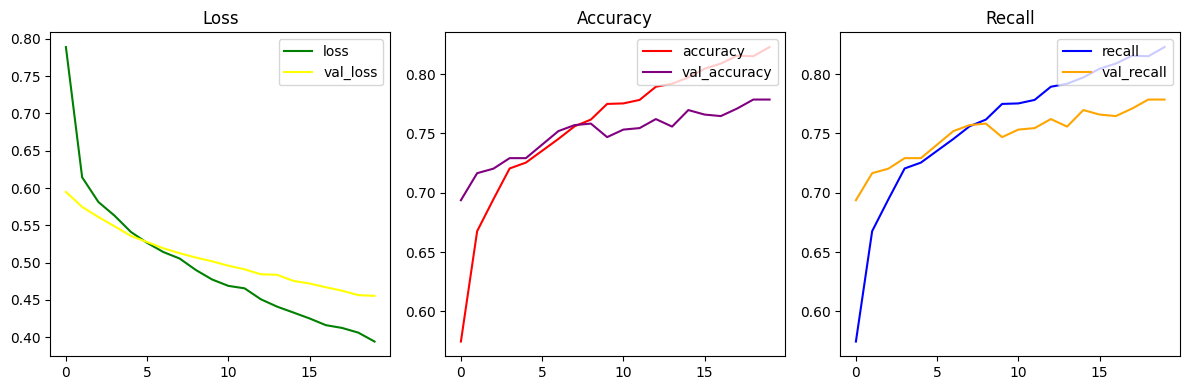

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_resnet_5_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_resnet_5_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_resnet_5_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_resnet_5_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_resnet_5_res.history['recall_1'], color='blue', label='recall')
axes[2].plot(mass_resnet_5_res.history['val_recall_1'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_resnet_5.save(ROOT + '/models/mass_resnet_5.keras')
# mass_resnet_5 = keras.models.load_model(ROOT + '/models/mass_resnet_5.keras')

In [ ]:
hist_df = pd.DataFrame(mass_resnet_5_res.history)
hist_df.to_csv(ROOT + '/history/mass_resnet_5_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_resnet_5.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - binary_accuracy: 0.7068 - loss: 0.5977 - recall_1: 0.7068
Loss:  0.59458988904953
Accuracy:  0.7037037014961243
Recall:  0.7037037014961243


**Calcification ResNet Model 6**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/muhammadfaizan65/clahe-medical-imaging-classification-using-resnet5
def preprocess(image, label):
  image=tf.keras.applications.resnet.preprocess_input(image)
  return image, label

calc_train = calc_train.map(preprocess)
calc_val = calc_val.map(preprocess)
calc_test = calc_test.map(preprocess)

resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False

calc_resnet_6 = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

calc_resnet_6.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
calc_resnet_6.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
calc_resnet_6_res = calc_resnet_6.fit(calc_train, epochs=20, verbose=1, validation_data=calc_val)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - binary_accuracy: 0.6178 - loss: 0.7521 - recall_5: 0.6178 - val_binary_accuracy: 0.7206 - val_loss: 0.5182 - val_recall_5: 0.7206
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - binary_accuracy: 0.6824 - loss: 0.5511 - recall_5: 0.6824 - val_binary_accuracy: 0.7282 - val_loss: 0.4936 - val_recall_5: 0.7282
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 194ms/step - binary_accuracy: 0.7190 - loss: 0.5114 - recall_5: 0.7190 - val_binary_accuracy: 0.7346 - val_loss: 0.4869 - val_recall_5: 0.7346
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 191ms/step - binary_accuracy: 0.7237 - loss: 0.4946 - recall_5: 0.7237 - val_binary_accuracy: 0.7465 - val_loss: 0.4714 - val_recall_5: 0.7465
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 185ms/step - binary_accuracy: 0.7446 - loss: 0.4730 - recall_5: 0.7446 - val_binary_accuracy: 0.7551 - val_loss: 0.4618 - val_recall_5: 0.7551
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 188ms/step - binary_a

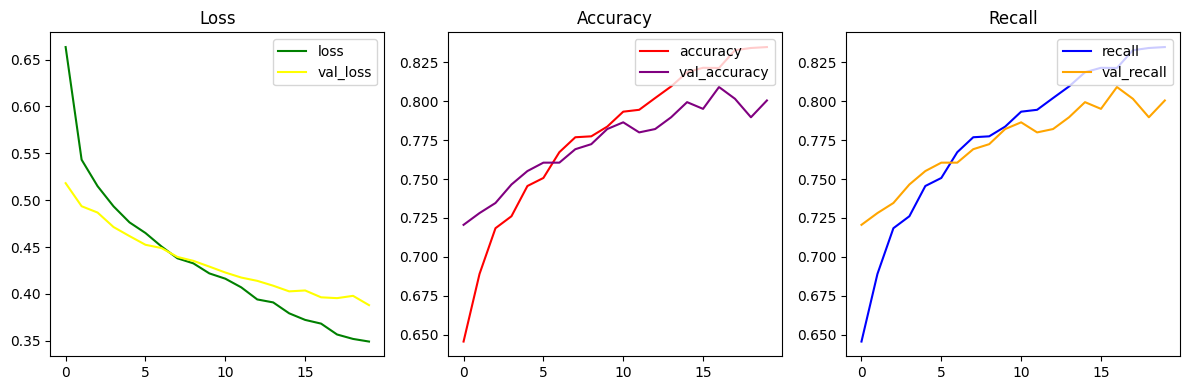

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(calc_resnet_6_res.history['loss'], color='green', label='loss')
axes[0].plot(calc_resnet_6_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(calc_resnet_6_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(calc_resnet_6_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(calc_resnet_6_res.history['recall_5'], color='blue', label='recall')
axes[2].plot(calc_resnet_6_res.history['val_recall_5'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
calc_resnet_6.save(ROOT + '/models/calc_resnet_6.keras')
# calc_resnet_6 = keras.models.load_model(ROOT + '/models/calc_resnet_6.keras')

In [ ]:
hist_df = pd.DataFrame(calc_resnet_6_res.history)
hist_df.to_csv(ROOT + '/history/calc_resnet_6_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
calc_loss, calc_accuracy, calc_recall = calc_resnet_6.evaluate(calc_test)
print("Loss: ", calc_loss)
print("Accuracy: ", calc_accuracy)
print("Recall: ", calc_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - binary_accuracy: 0.6903 - loss: 0.5909 - recall_5: 0.6903
Loss:  0.5882406234741211
Accuracy:  0.696319043636322
Recall:  0.696319043636322


**Mass ResNet Model 6**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/muhammadfaizan65/clahe-medical-imaging-classification-using-resnet5
def preprocess(image, label):
  image=tf.keras.applications.resnet.preprocess_input(image)
  return image, label

mass_train = mass_train.map(preprocess)
mass_val = mass_val.map(preprocess)
mass_test = mass_test.map(preprocess)

resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False

mass_resnet_6 = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

mass_resnet_6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
mass_resnet_6.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
mass_resnet_6_res = mass_resnet_6.fit(mass_train, epochs=20, verbose=1, validation_data=mass_val)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - binary_accuracy: 0.5038 - loss: 0.8275 - recall_6: 0.5038 - val_binary_accuracy: 0.5367 - val_loss: 0.6888 - val_recall_6: 0.5367
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - binary_accuracy: 0.5169 - loss: 0.7106 - recall_6: 0.5169 - val_binary_accuracy: 0.5481 - val_loss: 0.6820 - val_recall_6: 0.5481
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - binary_accuracy: 0.5428 - loss: 0.6853 - recall_6: 0.5428 - val_binary_accuracy: 0.5430 - val_loss: 0.6830 - val_recall_6: 0.5430
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - binary_accuracy: 0.5581 - loss: 0.6808 - recall_6: 0.5581 - val_binary_accuracy: 0.5557 - val_loss: 0.6775 - val_recall_6: 0.5557
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - binary_accuracy: 0.5897 - loss: 0.6699 - recall_6: 0.5897 - val_binary_accuracy: 0.5886 - val_loss: 0.6744 - val_recall_6: 0.5886
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - binary_a

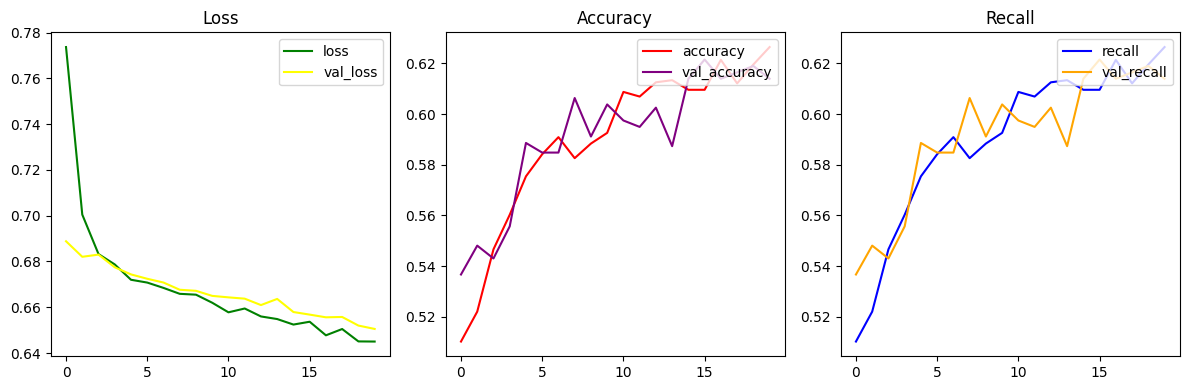

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(mass_resnet_6_res.history['loss'], color='green', label='loss')
axes[0].plot(mass_resnet_6_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(mass_resnet_6_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(mass_resnet_6_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(mass_resnet_6_res.history['recall_6'], color='blue', label='recall')
axes[2].plot(mass_resnet_6_res.history['val_recall_6'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
mass_resnet_6.save(ROOT + '/models/mass_resnet_6.keras')
# mass_resnet_6 = keras.models.load_model(ROOT + '/models/mass_resnet_6.keras')

In [ ]:
hist_df = pd.DataFrame(mass_resnet_6_res.history)
hist_df.to_csv(ROOT + '/history/mass_resnet_6_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
mass_loss, mass_accuracy, mass_recall = mass_resnet_6.evaluate(mass_test)
print("Loss: ", mass_loss)
print("Accuracy: ", mass_accuracy)
print("Recall: ", mass_recall)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 640ms/step - binary_accuracy: 0.6363 - loss: 0.6493 - recall_6: 0.6363
Loss:  0.6577693819999695
Accuracy:  0.6137565970420837
Recall:  0.6137565970420837


**Combined ResNet Model**

In [ ]:
# I borrowed the model architecture from here: https://www.kaggle.com/code/muhammadfaizan65/clahe-medical-imaging-classification-using-resnet5
def preprocess(image, label):
  image=tf.keras.applications.resnet.preprocess_input(image)
  return image, label

combined_train = combined_train.map(preprocess)
combined_val = combined_val.map(preprocess)
combined_test = combined_test.map(preprocess)

resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False

combined_resnet_1 = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

combined_resnet_1.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
combined_resnet_1.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
combined_resnet_1_res = combined_resnet_1.fit(combined_train, epochs=20, verbose=1, validation_data=combined_val)

Epoch 1/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 2302s 4s/step - binary_accuracy: 0.6088 - loss: 0.7114 - recall: 0.6088 - val_binary_accuracy: 0.6926 - val_loss: 0.5714 - val_recall: 0.6926
Epoch 2/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 96s 170ms/step - binary_accuracy: 0.6776 - loss: 0.5821 - recall: 0.6776 - val_binary_accuracy: 0.7028 - val_loss: 0.5580 - val_recall: 0.7028
Epoch 3/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 96s 169ms/step - binary_accuracy: 0.6894 - loss: 0.5669 - recall: 0.6894 - val_binary_accuracy: 0.7056 - val_loss: 0.5505 - val_recall: 0.7056
Epoch 4/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 95s 169ms/step - binary_accuracy: 0.7047 - loss: 0.5535 - recall: 0.7047 - val_binary_accuracy: 0.7066 - val_loss: 0.5460 - val_recall: 0.7066
Epoch 5/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 95s 169ms/step - binary_accuracy: 0.7060 - loss: 0.5463 - recall: 0.7060 - val_binary_accuracy: 0.7053 - val_loss: 0.5387 - val_recall: 0.7053
Epoch 6/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 95s 169ms/step - binary_accuracy: 0.7140 - los

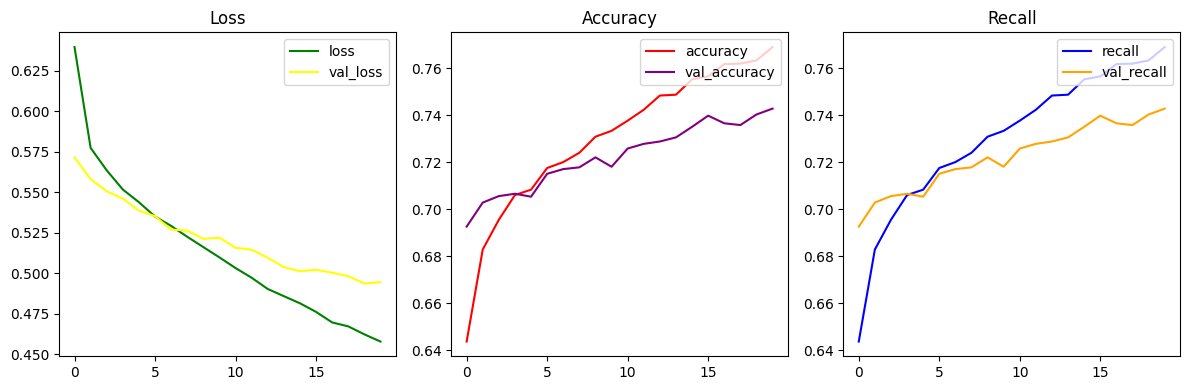

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(combined_resnet_1_res.history['loss'], color='green', label='loss')
axes[0].plot(combined_resnet_1_res.history['val_loss'], color='yellow', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

axes[1].plot(combined_resnet_1_res.history['binary_accuracy'], color='red', label='accuracy')
axes[1].plot(combined_resnet_1_res.history['val_binary_accuracy'], color='purple', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc='upper right')

axes[2].plot(combined_resnet_1_res.history['recall'], color='blue', label='recall')
axes[2].plot(combined_resnet_1_res.history['val_recall'], color='orange', label='val_recall')
axes[2].set_title('Recall')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
combined_resnet_1.save(ROOT + '/models/combined_resnet_1.keras')
# combined_resnet_1 = keras.models.load_model(ROOT + '/models/combined_resnet_1.keras')

In [ ]:
hist_df = pd.DataFrame(combined_resnet_1_res.history)
hist_df.to_csv(ROOT + '/history/combined_resnet_1_history.csv')

In [ ]:
# Evaluate based on accuracy and recall metrics
loss, accuracy, recall = combined_resnet_1.evaluate(combined_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)
print("Recall: ", recall)

17/17 ━━━━━━━━━━━━━━━━━━━━ 100s 6s/step - binary_accuracy: 0.6614 - loss: 0.6475 - recall: 0.6614
Loss:  0.645963728427887
Accuracy:  0.6626838445663452
Recall:  0.6626838445663452
